In [1]:
from scipy import io
import GPy
import numpy as np
import matplotlib.pyplot as plt
import pylab as pb

In [2]:
def build_XI(input_list):
    num_outputs = len(input_list)
#     Y = np.vstack(output_list)
    I = np.hstack( [np.repeat(j,_x.shape[0]) for _x,j in zip(input_list,range(num_outputs))] )
    X = np.vstack(input_list)
    X = np.hstack([X,I[:,None]])
    I = {'output_index':I[:,None]}
    return X,I

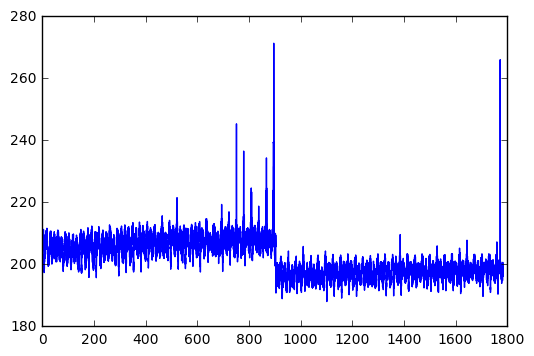

In [3]:
mat_file1 = io.loadmat('2014_Dataset3.mat')
t = mat_file1['t']
p1 = mat_file1['p1']
p2 = mat_file1['p2']
x = np.arange(0,len(p2)/10,0.1)[:,None]
plt.plot(x,p2)
plt.show()

In [4]:
import pickle
f = open('d:/hyperparameter3','rb')
gp = pickle.load(f)
f.close()

In [5]:
kern = gp.kern.copy()

# EVT-GP


In [10]:
def rbf(X,xt,m):
    Xt = xt*np.ones(len(X))[:,None]
    k = ((X-Xt)**2)/(2*(2*m.kern.ICM0.rbf.lengthscale[0])**2)
    ke = np.exp(-k)
    n = np.sum(ke)
    return n

def z_score(n):
    alpha = (2*np.log(n))**(-0.5)
    beta = (2*np.log(n))**(0.5) - (np.log(np.log(n)+np.log(2*np.pi)))/(2*(2*np.log(n))**0.5)
    zp = beta-alpha*np.log(-np.log(0.98))
    return zp

In [7]:
def plot_2outputs(m,xlim,x_1,x_2):
    fig = pb.figure(figsize=(12,8))
    #Output 1
    ax1 = fig.add_subplot(211)
    ax1.set_xlim(xlim)
    ax1.set_title('Output 1')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],which_data_rows=slice(0,len(x_1)),ax=ax1)

    #Output 2
    ax2 = fig.add_subplot(212)
    ax2.set_xlim(xlim)
    ax2.set_title('Output 2')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],which_data_rows=slice(len(x_1),len(x_1)+len(x_2)),ax=ax2)

In [8]:
def plot_3outputs(m,xlim,x_1,x_2,con_ue,con_le,n):
    fig = pb.figure(figsize=(12,12))
    #Output 1
    ax1 = fig.add_subplot(311)
    ax1.set_xlim(xlim)
    ax1.set_ylim([2.9,3.0])
    ax1.set_title('Output 1')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],which_data_rows=slice(0,len(x_1)),ax=ax1,legend=False)

    #Output 2
    ax2 = fig.add_subplot(312)
    ax2.set_xlim(xlim)
    ax2.set_ylim([180,280])
    ax2.set_title('Output 2')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],which_data_rows=slice(len(x_1),len(x_1)+len(x_2)),ax=ax2,legend=False)
#     ax2.plot(x[jt],con_ue,'red')
#     ax2.plot(x[jt],con_le,'red')
    
    ax3 = fig.add_subplot(313)
    ax3.set_xlim([892,900])
    ax3.set_ylim([180,280])
    ax3.plot(x[test_points],p2[test_points],'kx')
    ax3.plot(x[anomal_points],p2[anomal_points],'kx',color='orange')
    ax3.plot(x[jt],con_ue,'red')
    ax3.plot(x[jt],con_le,'red')
    
    s = 'fig {}.png'.format(n)
    fig.savefig(s)

In [9]:
def Mahalanobis_distance(model,x_test,p2):
    X,I = build_XI([x_test,x_test])
    mean, variance = model.predict(X, full_cov=True, Y_metadata=I)
    l = len(x_test)
    MD2 = np.dot(np.dot(np.transpose(p2-mean[l:2*l]),np.linalg.inv(variance[l:2*l,l:2*l])),p2-mean[l:2*l])
    
    return MD2

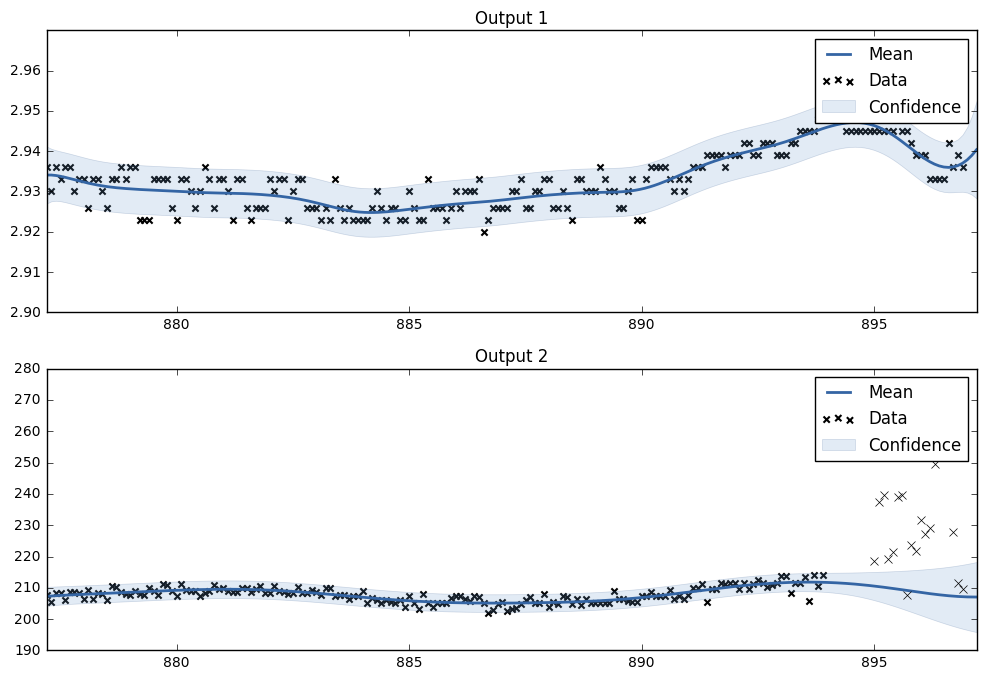

In [11]:
mul = GPy.models.GPCoregionalizedRegression([x[8772:8970],x[8772:8940]],[p1[8772:8970],p2[8772:8940]],kernel = kern)
mul['.*Gaussian_noise_0.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_0.variance)
mul['.*Gaussian_noise_1.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_1.variance)
plot_2outputs(mul, xlim=(x[8772],x[8972]),x_1=x[8772:8970],x_2=x[8772:8950])
plt.plot(x[8950:8970],p2[8950:8970],'kx')
plt.show()

0


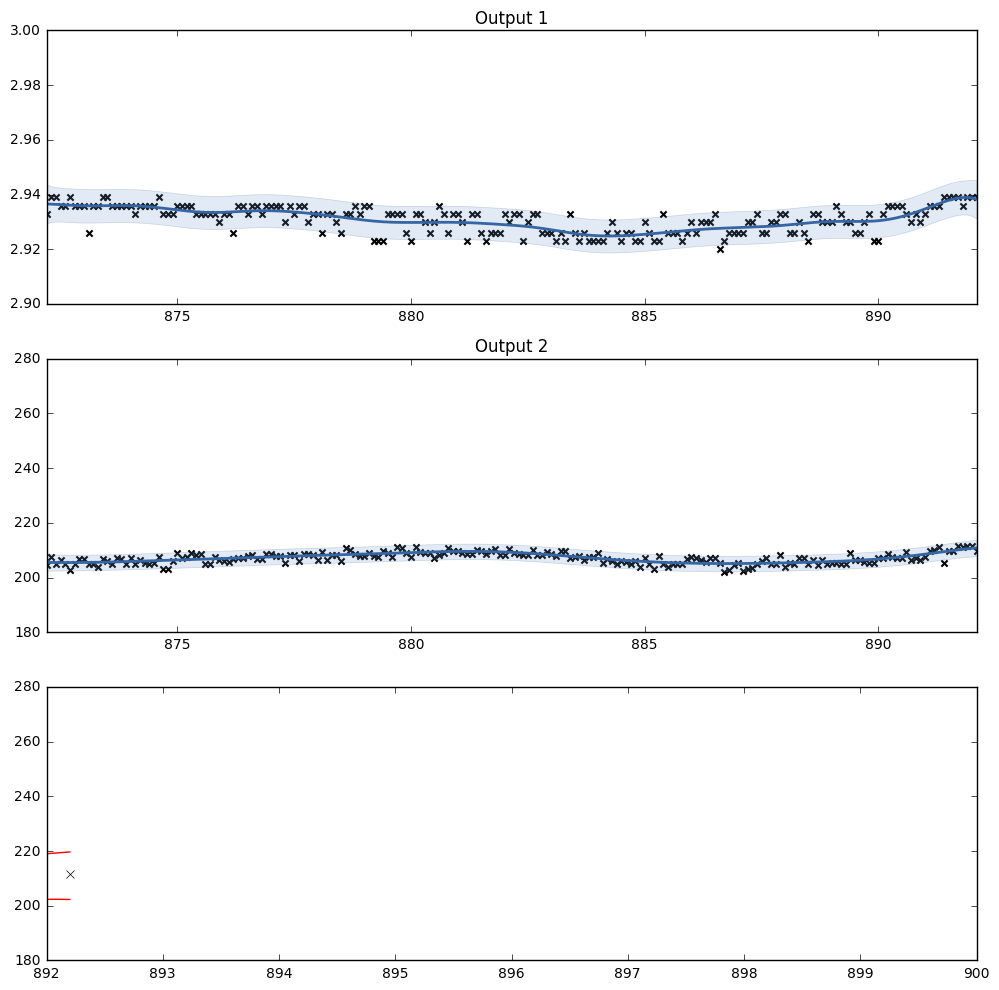

1


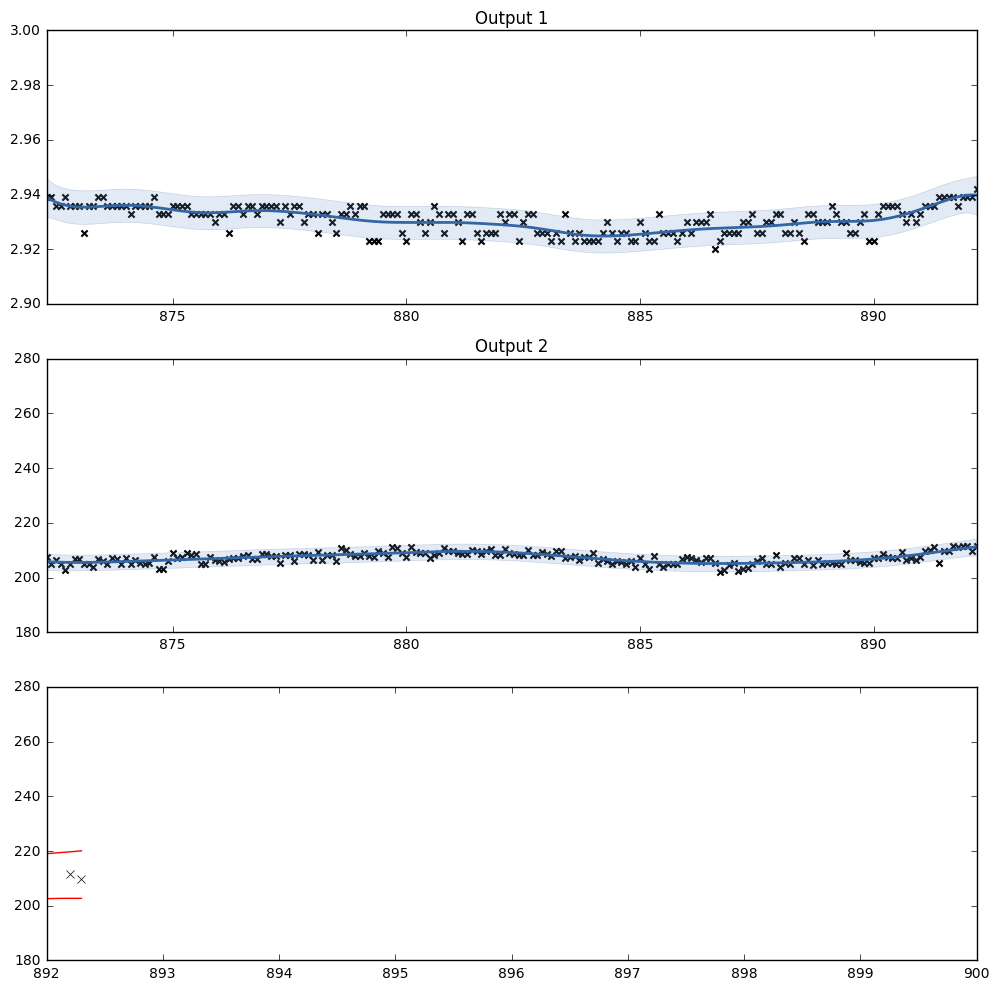

2


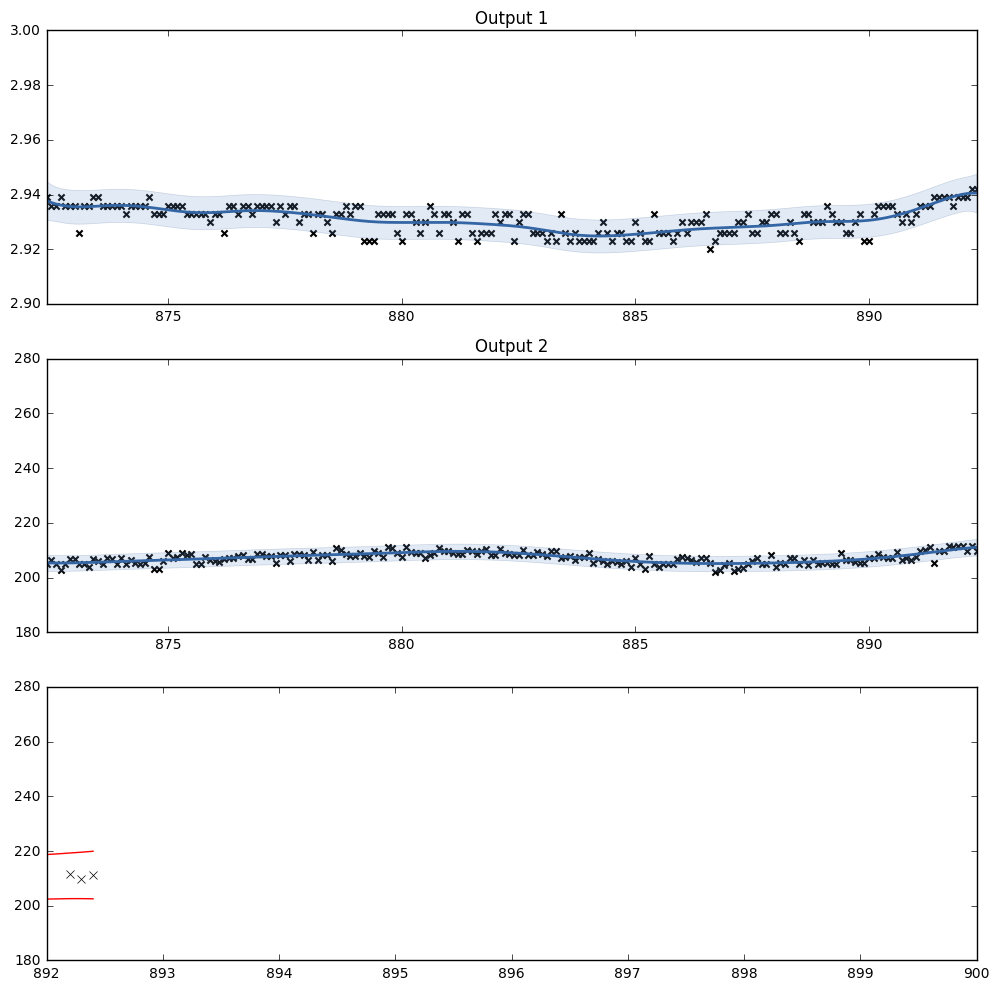

3


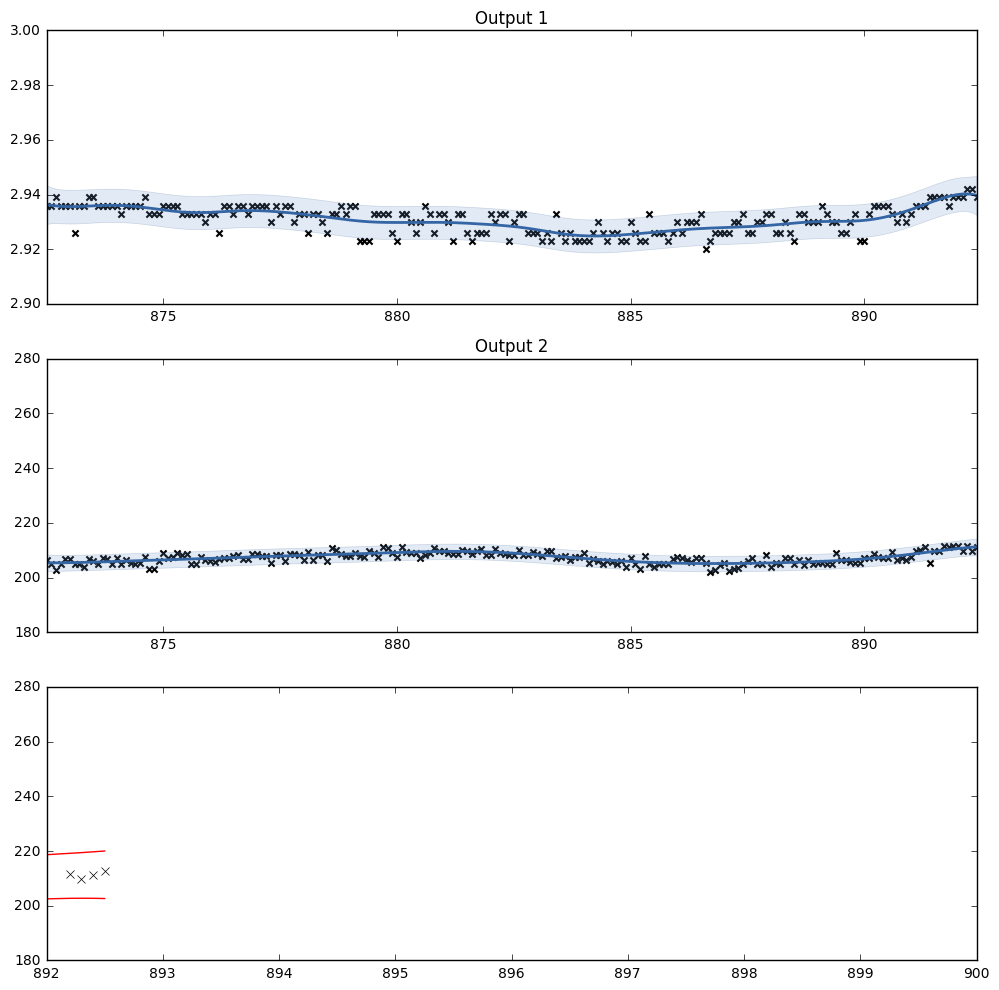

4


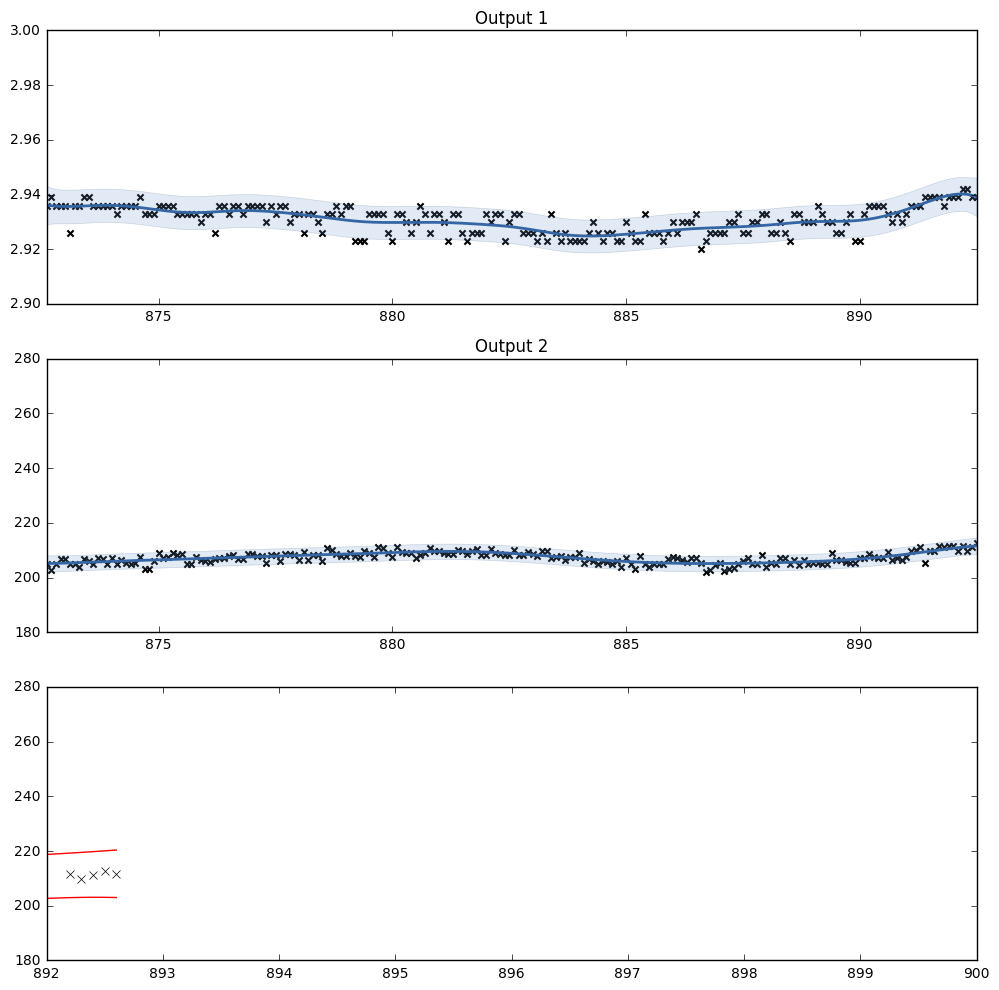

5


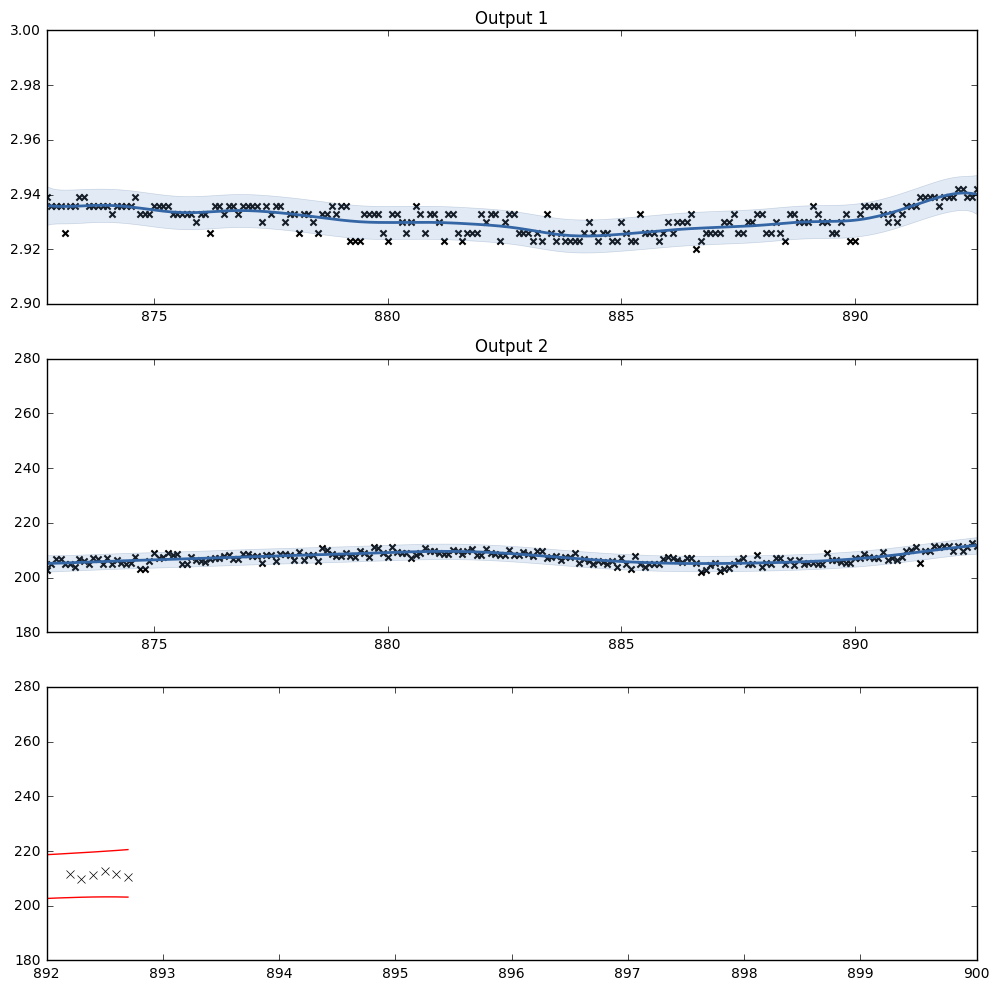

6


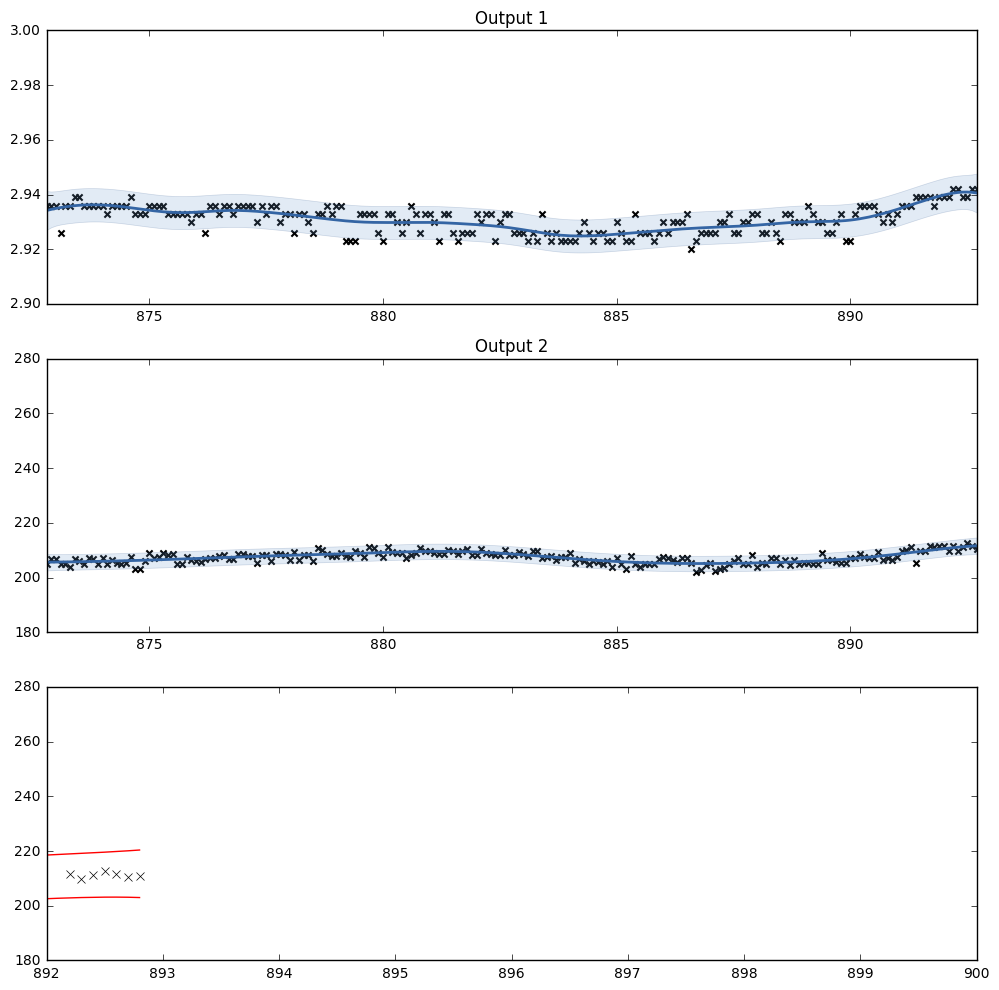

7


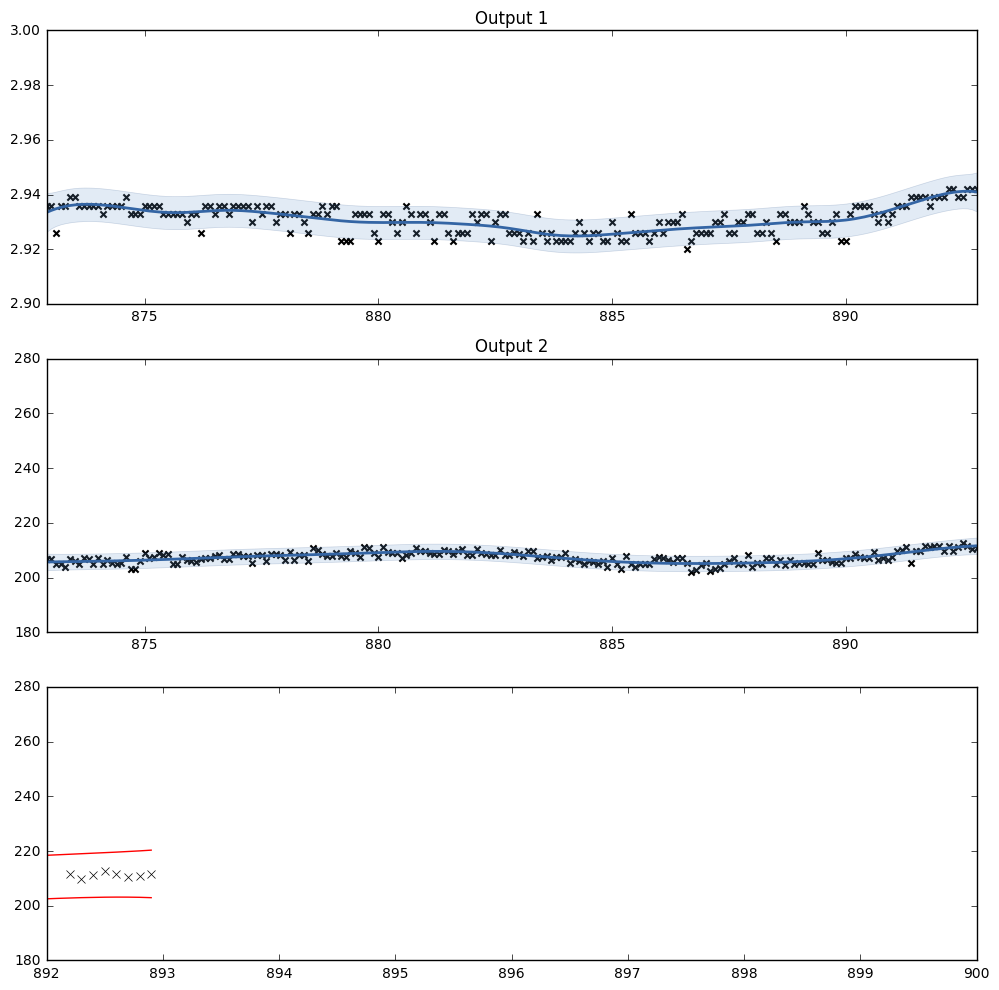

8


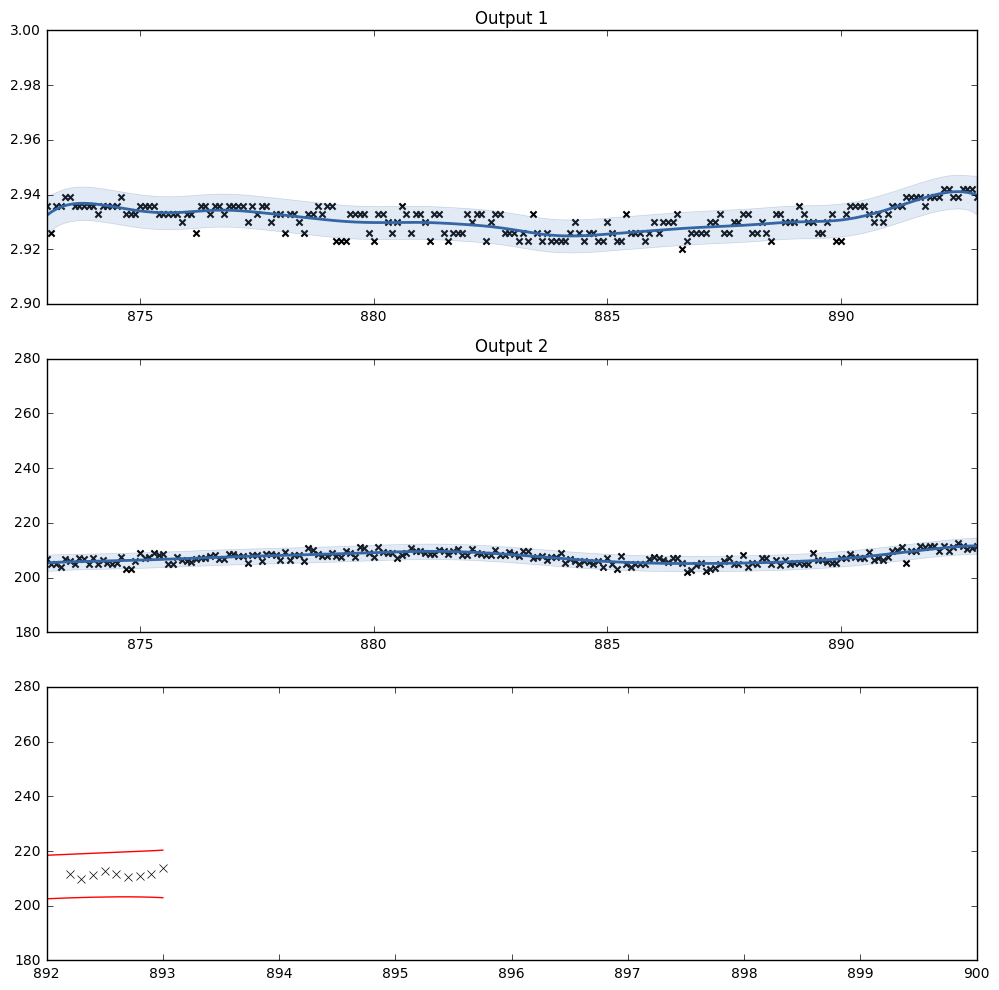

9


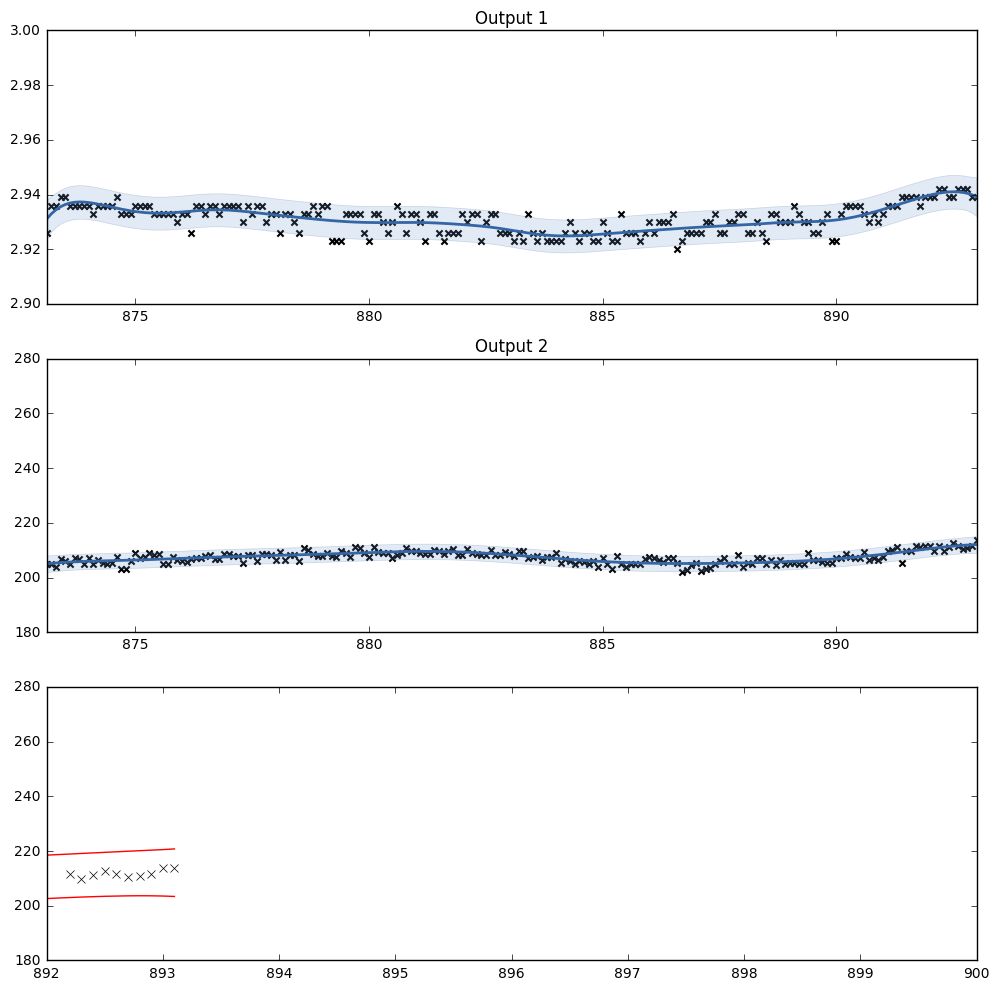

10


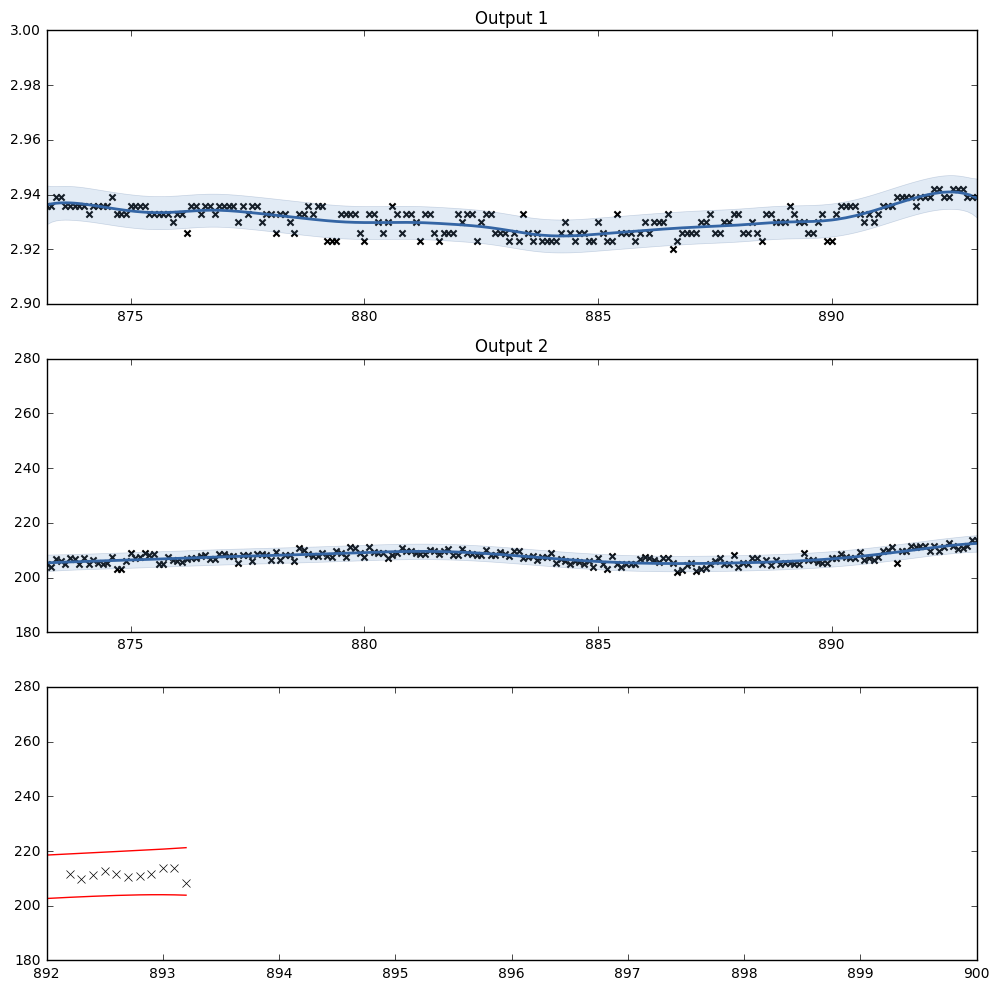

11


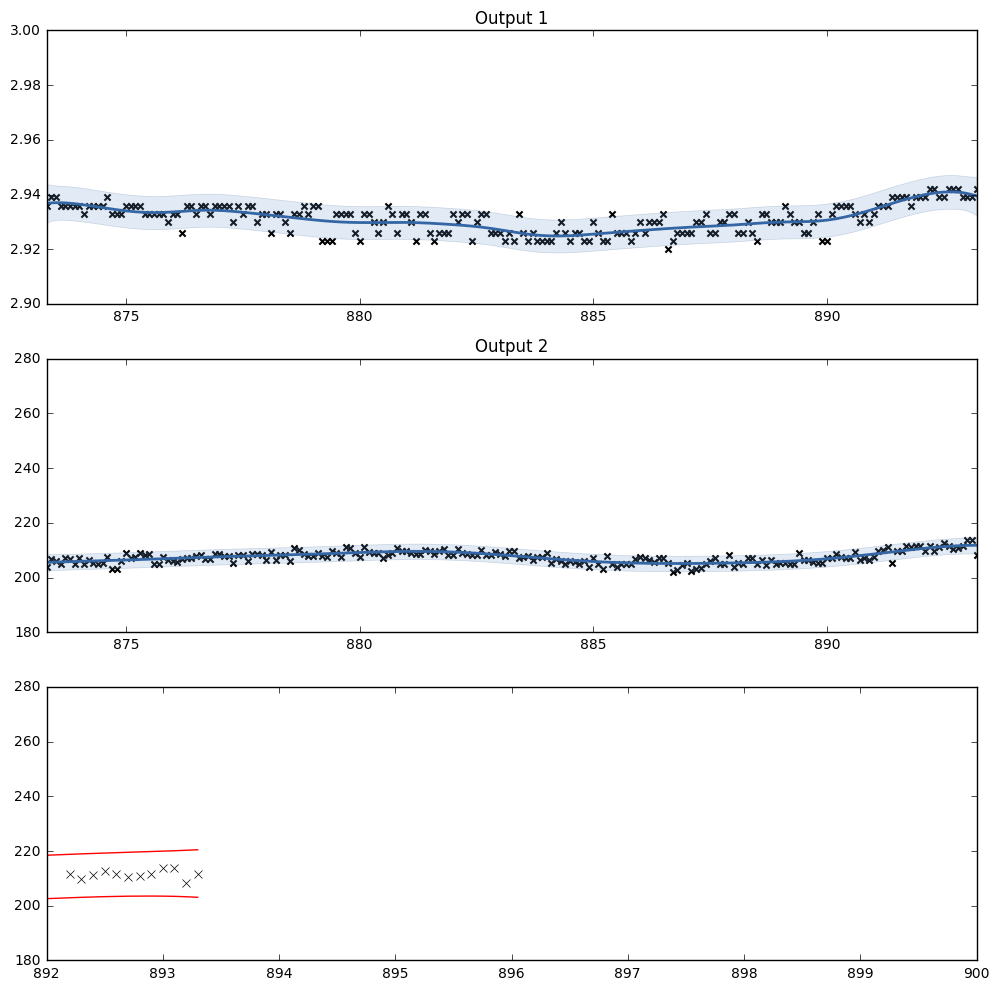

12


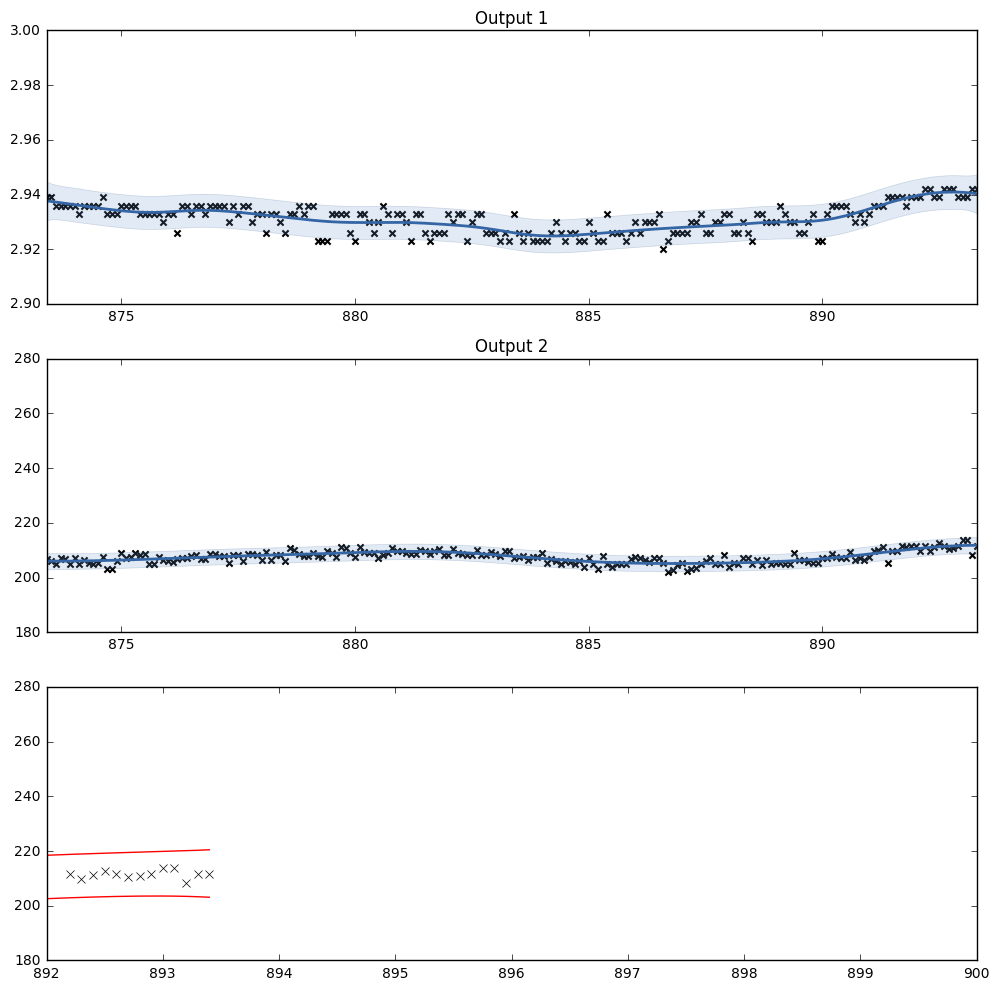

13


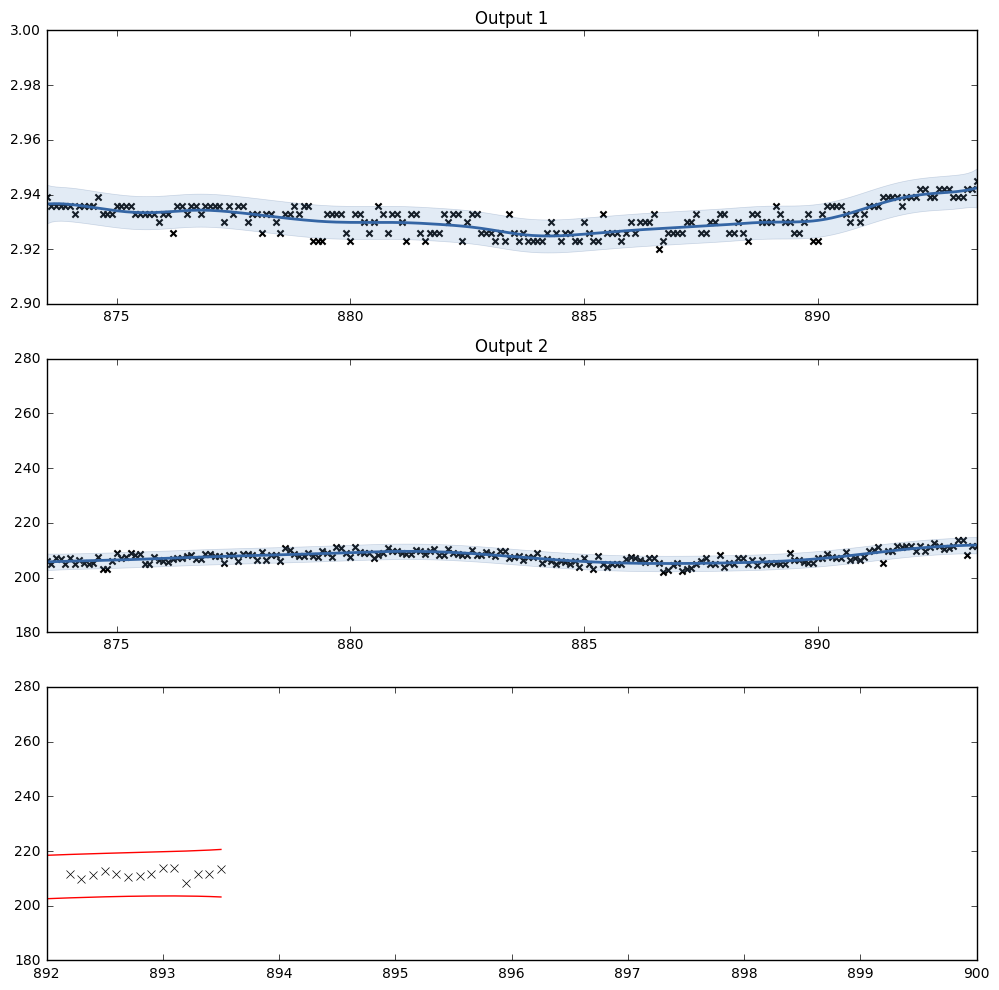

14


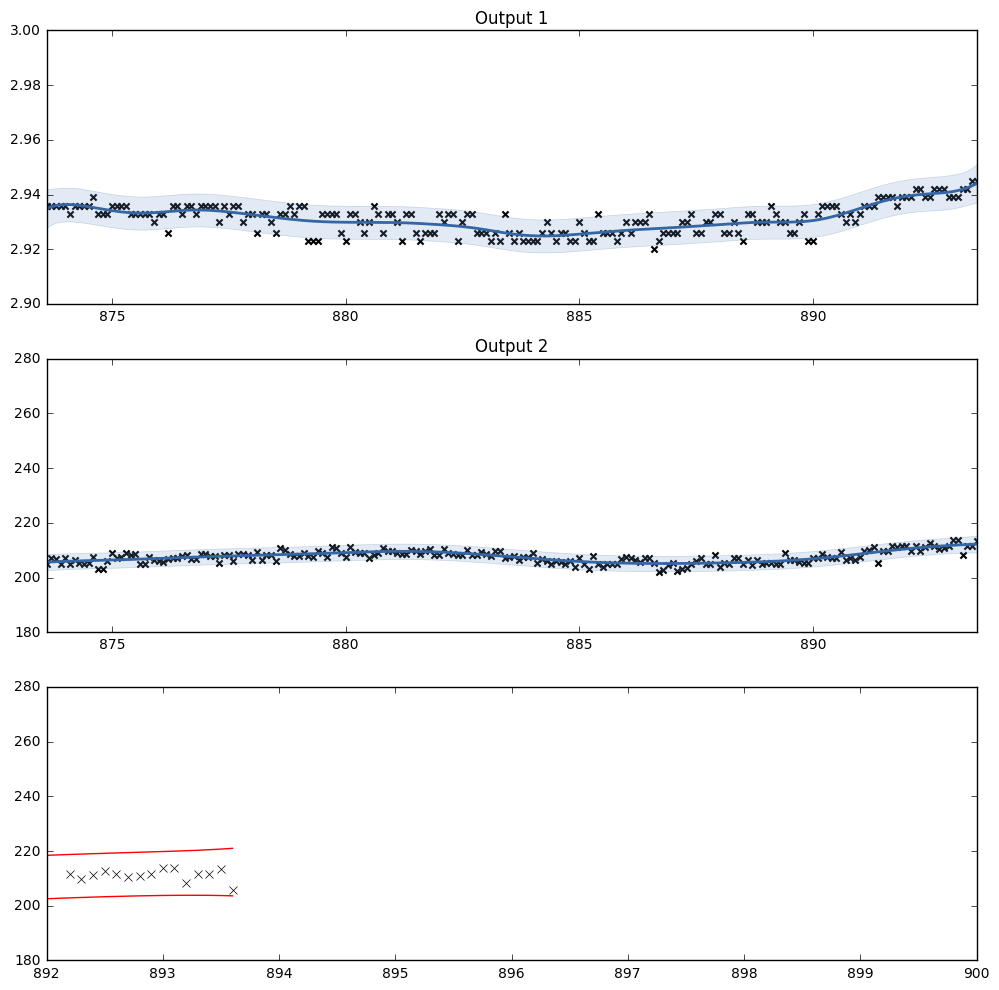

15


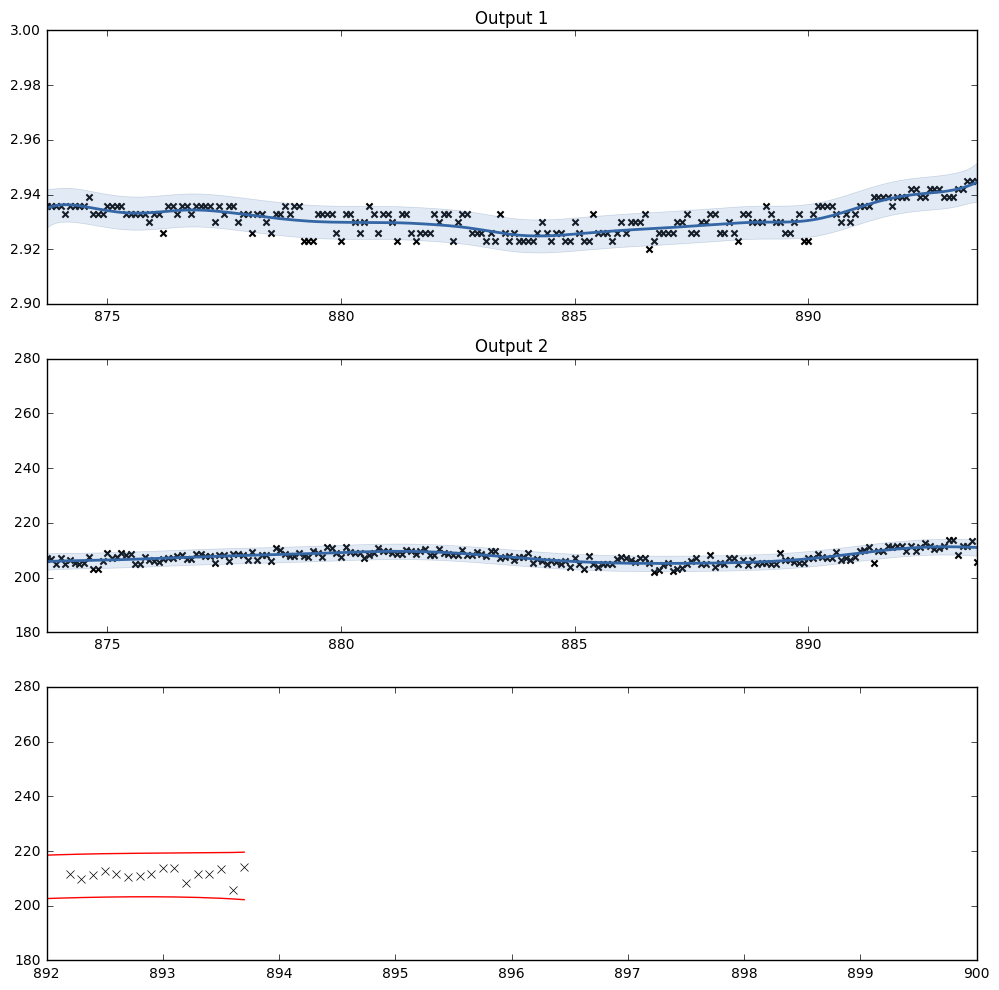

16


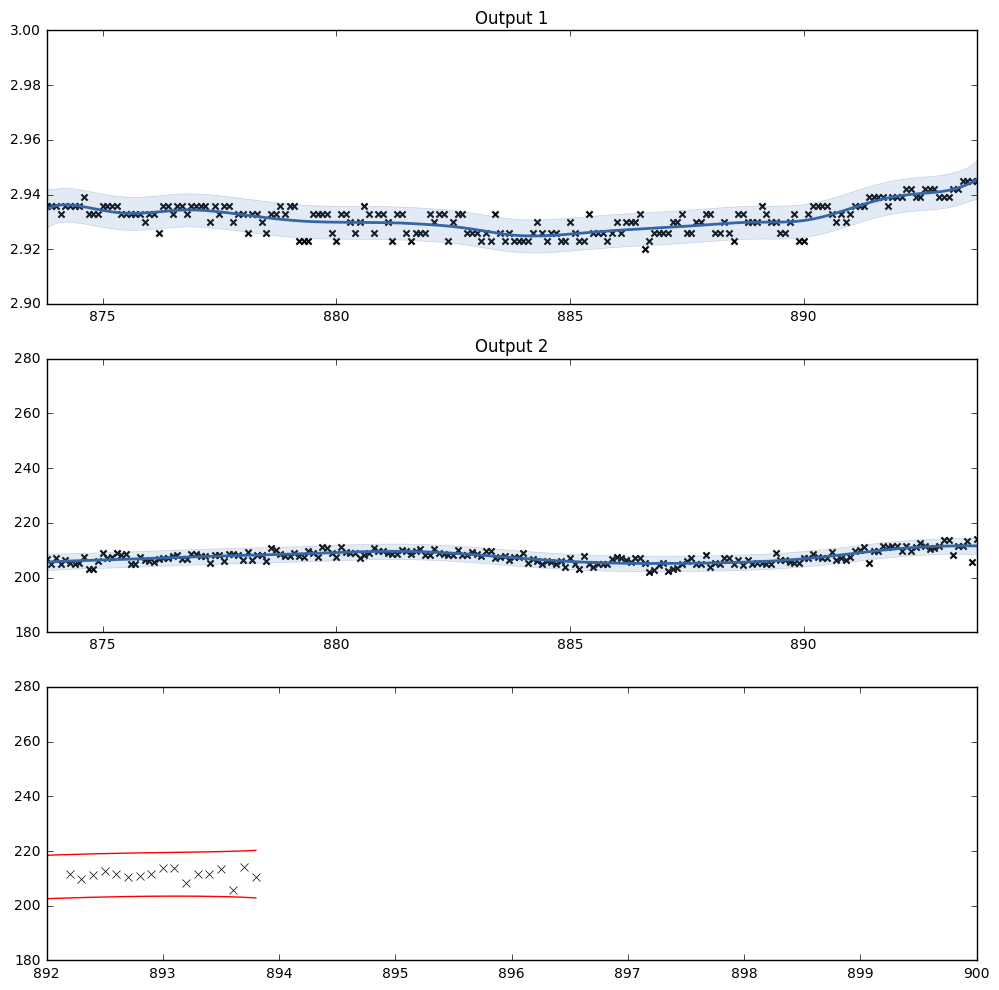

17


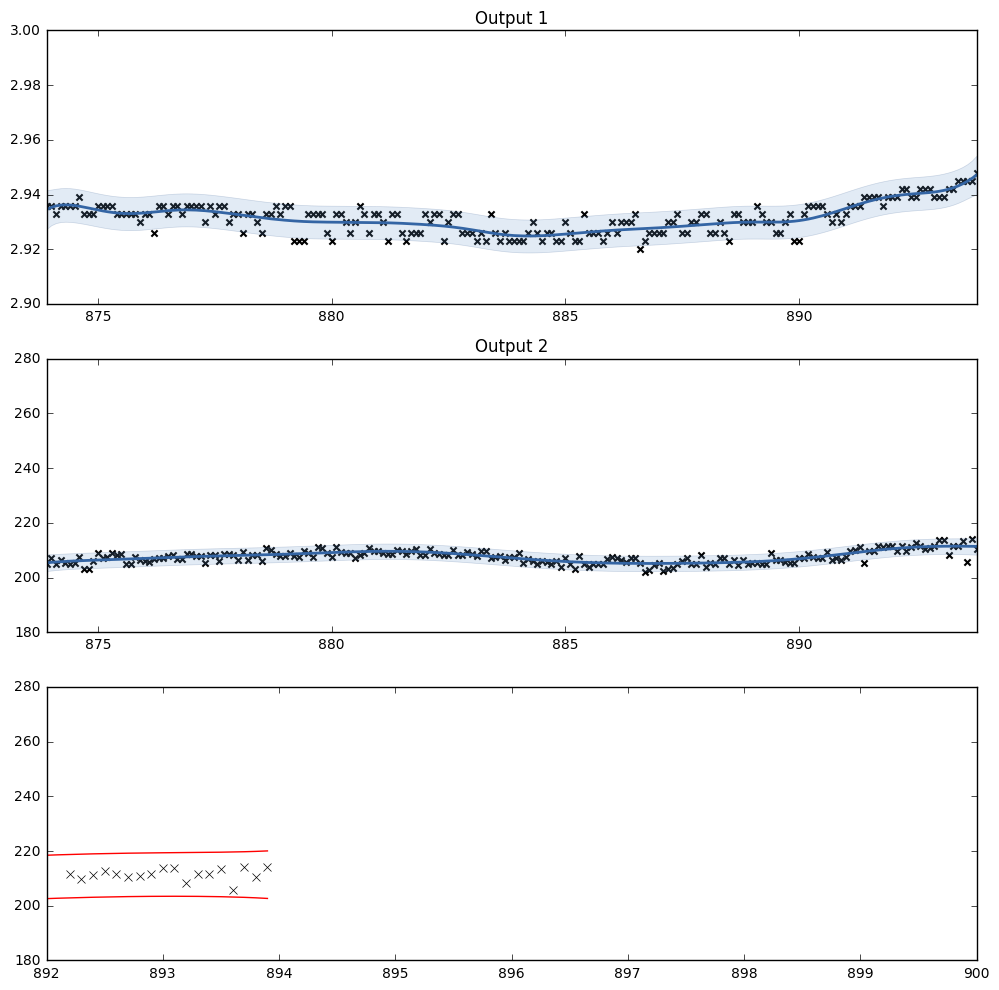

18


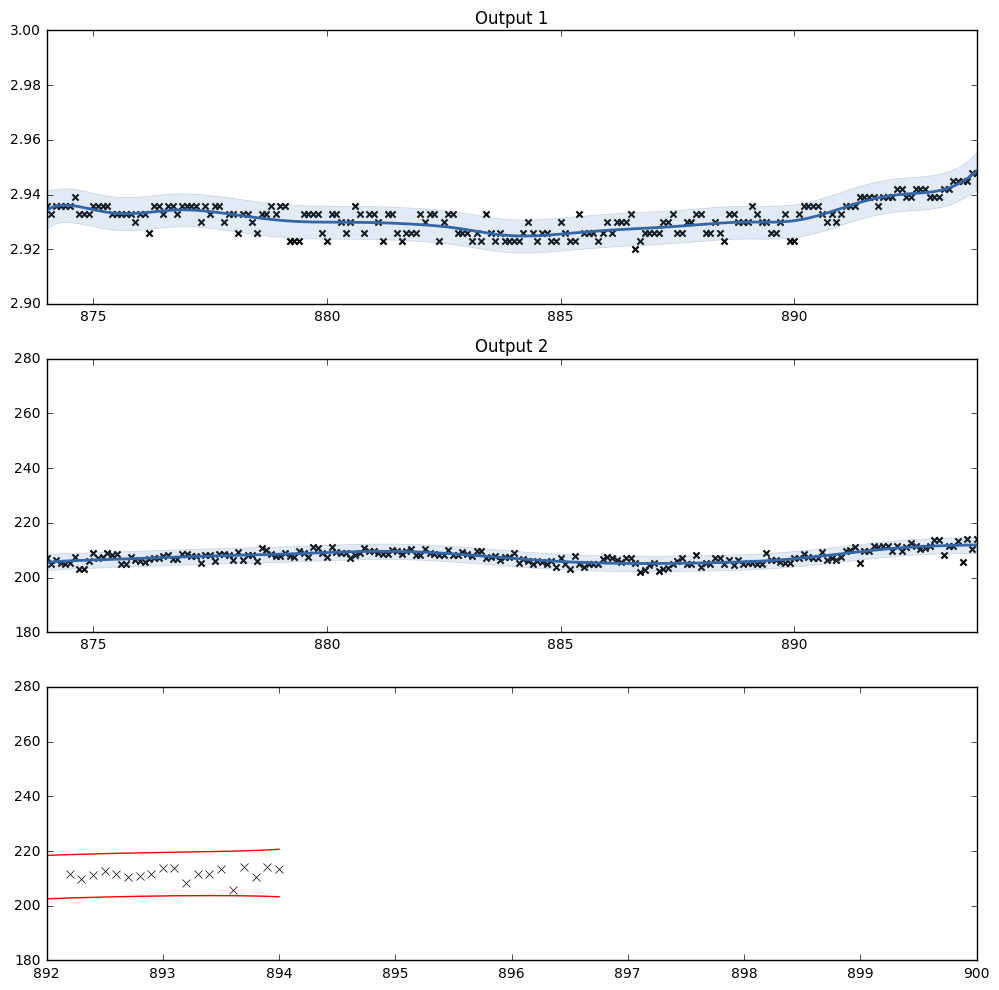

19


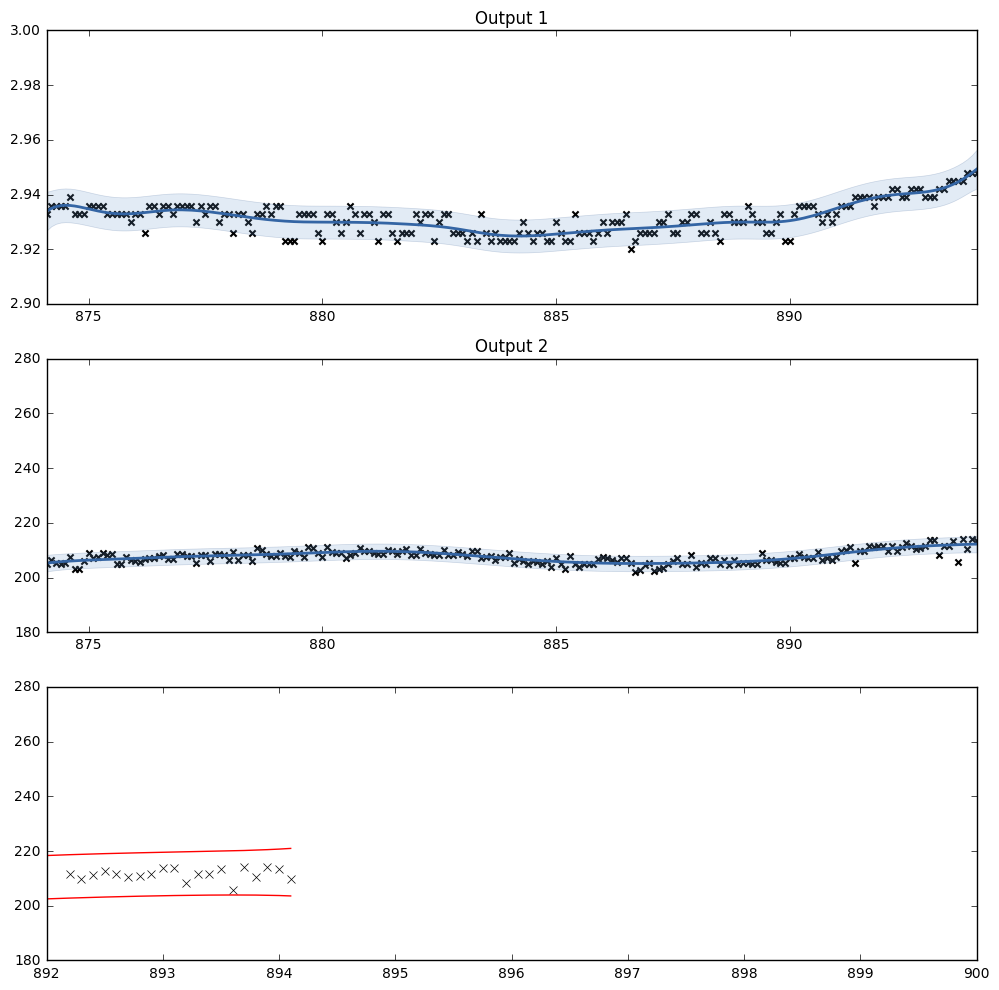

20


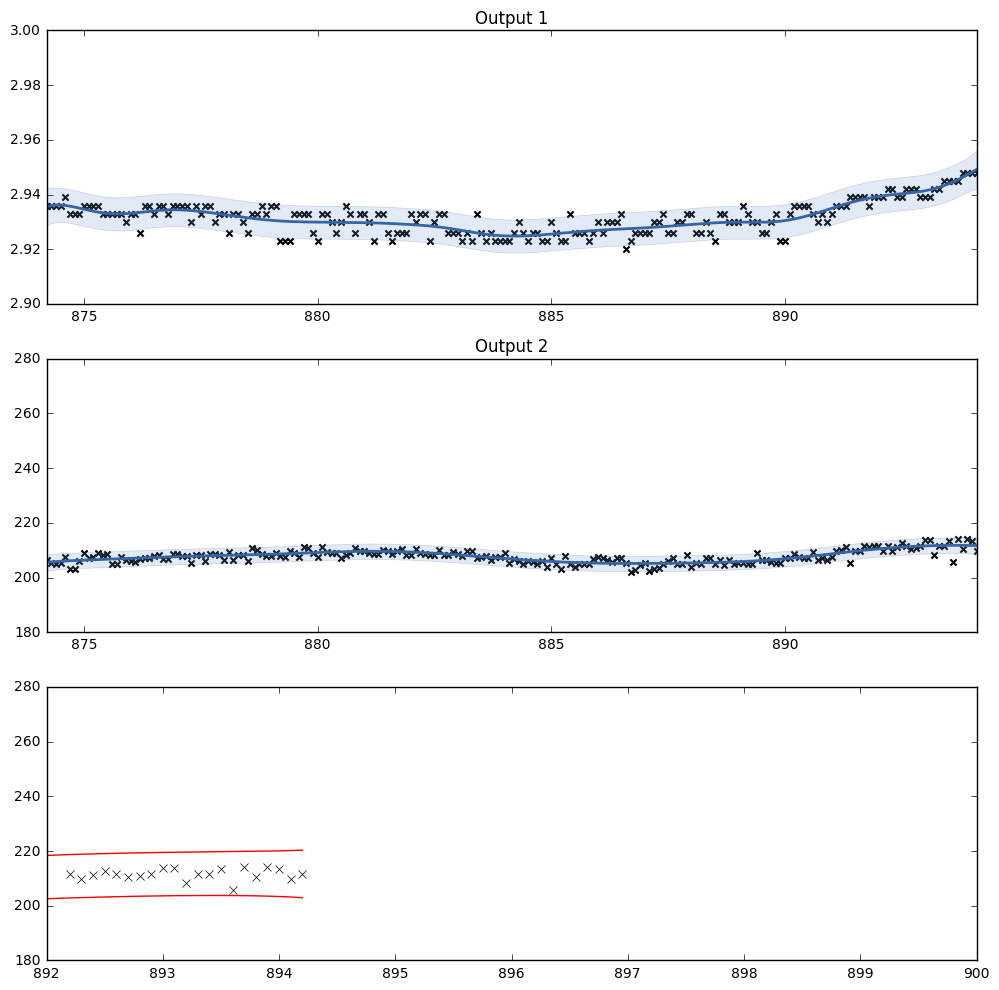

21


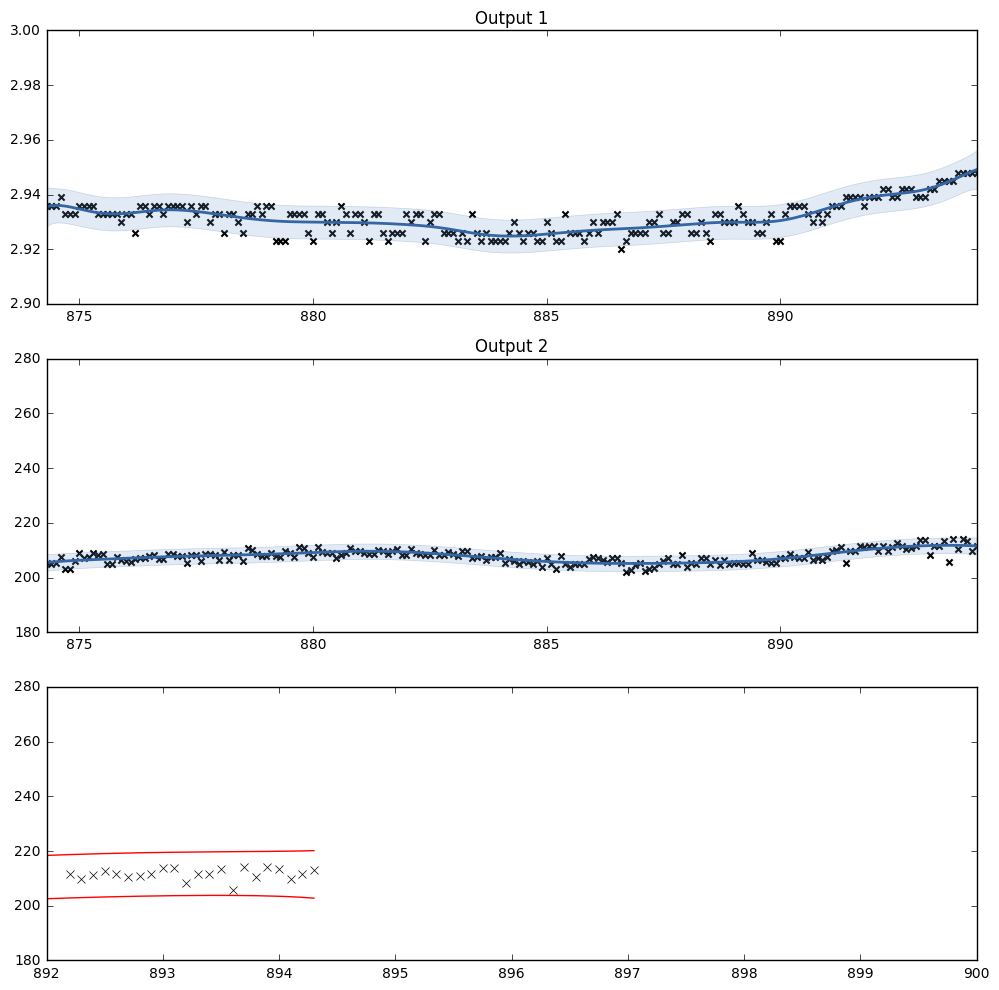

22


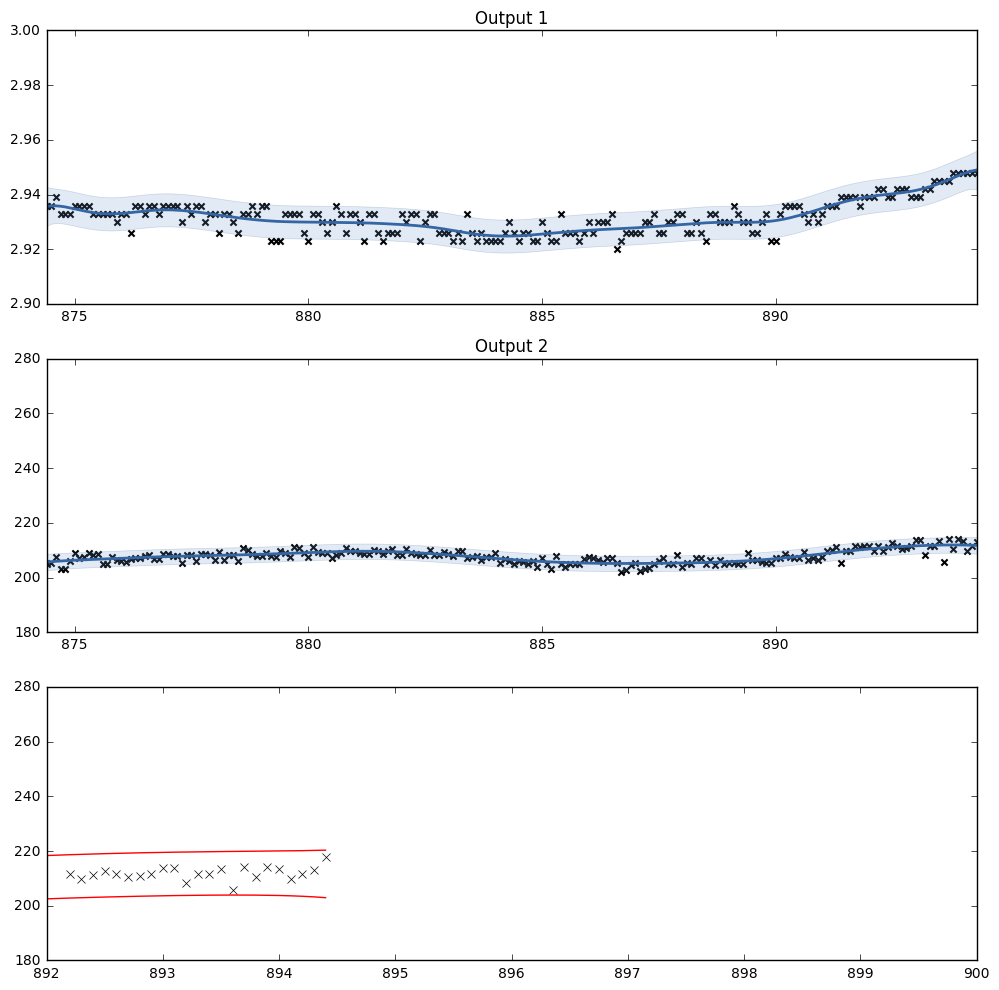

23


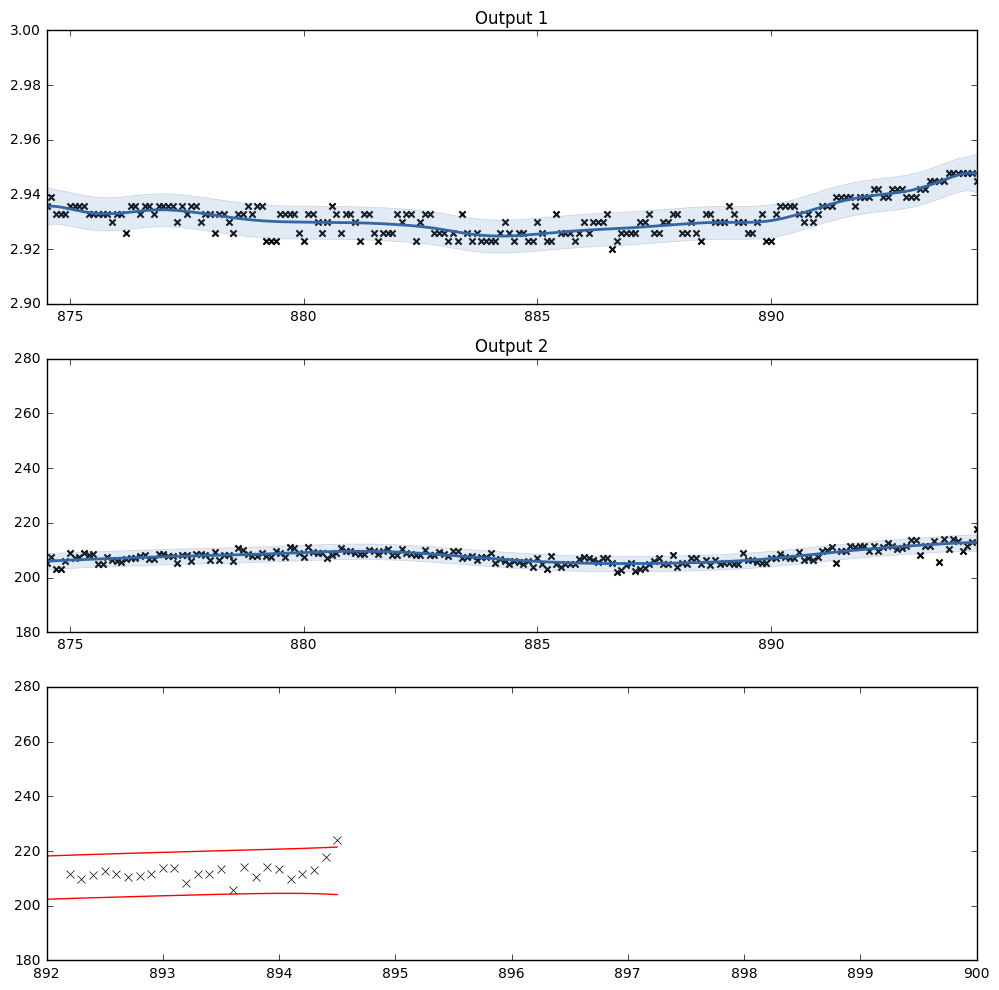

24


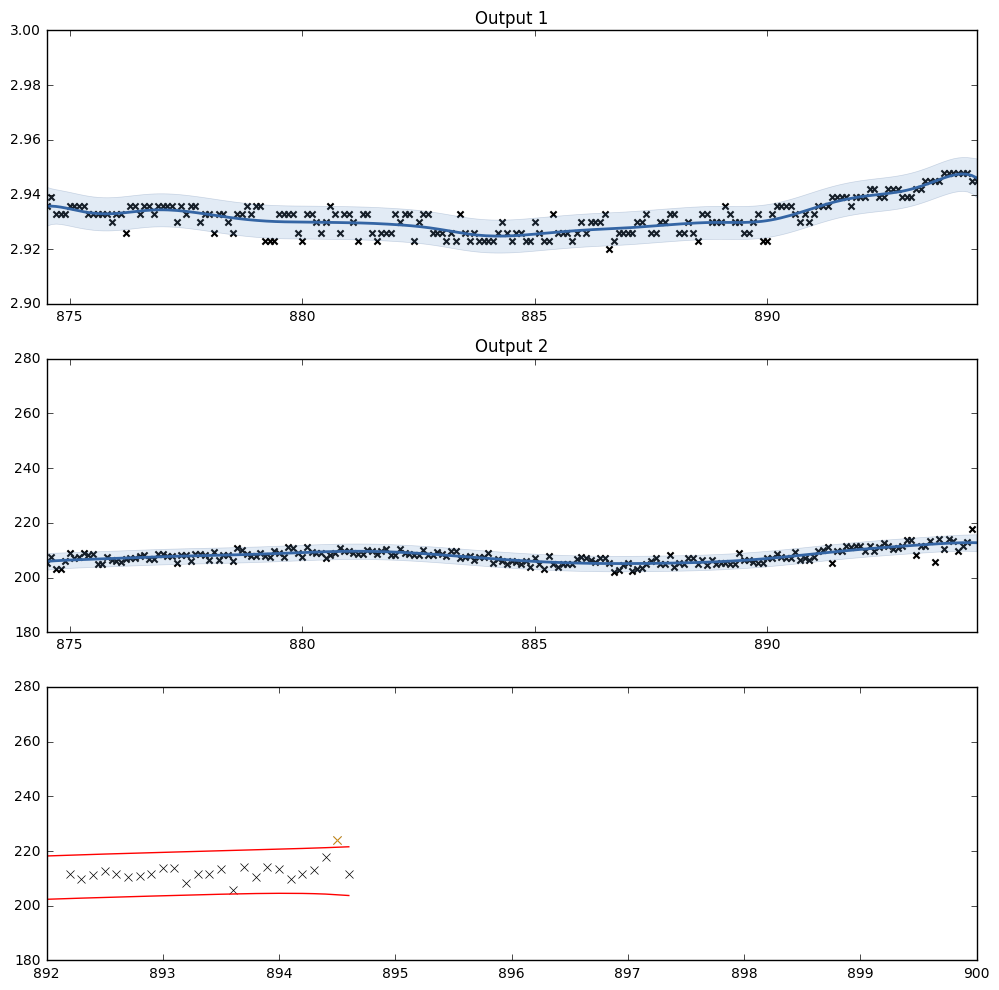

25


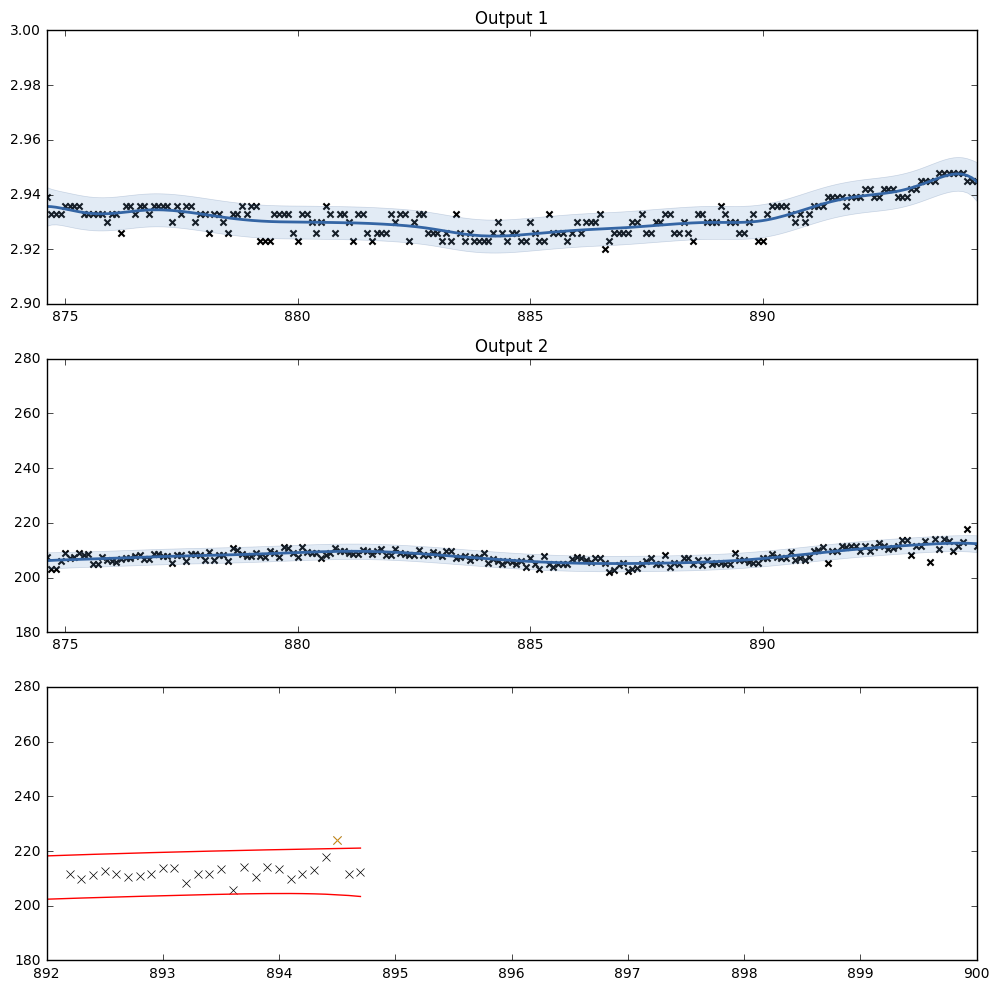

26


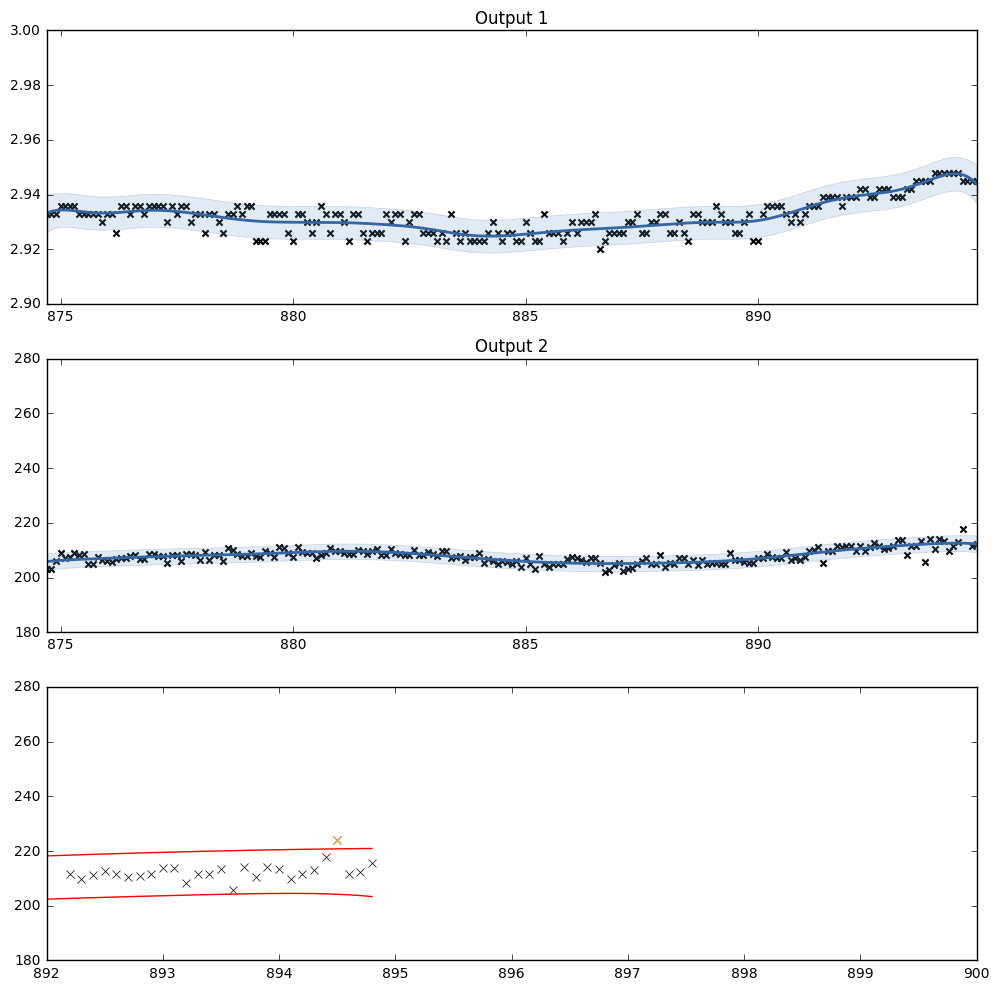

27


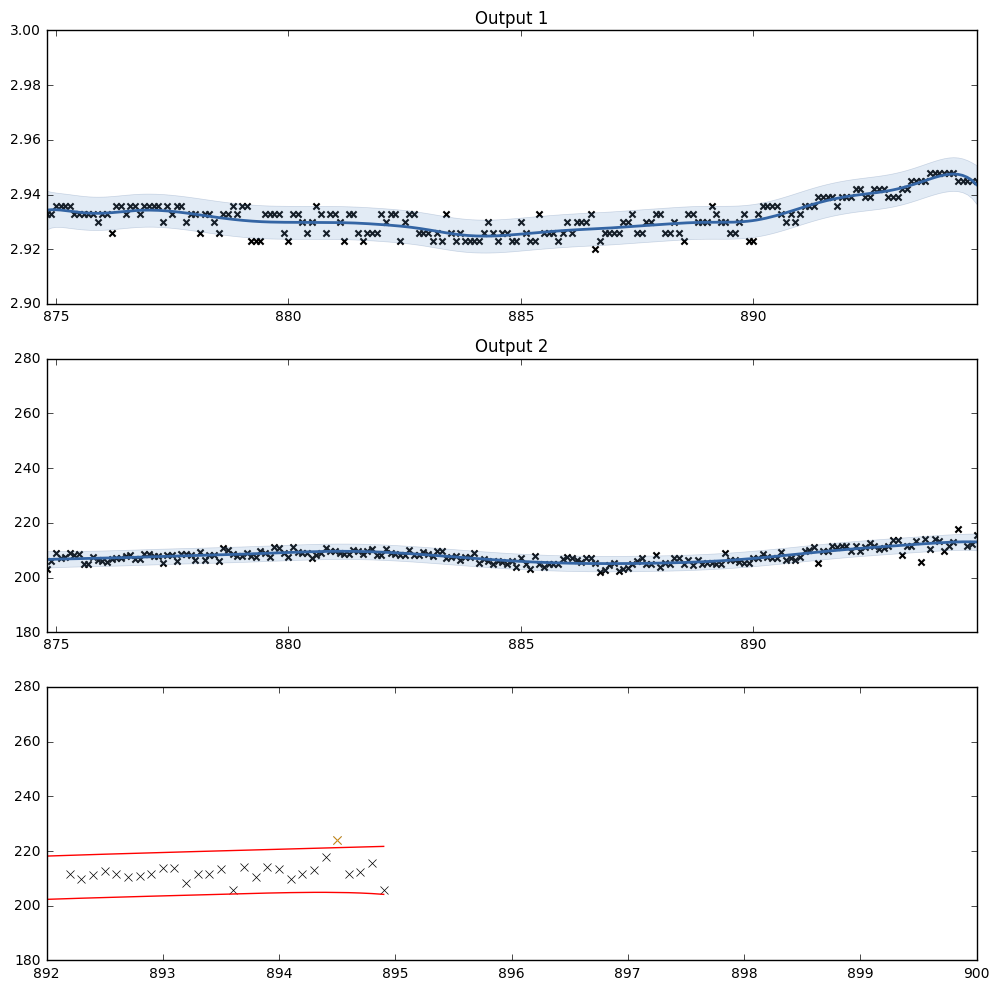

28


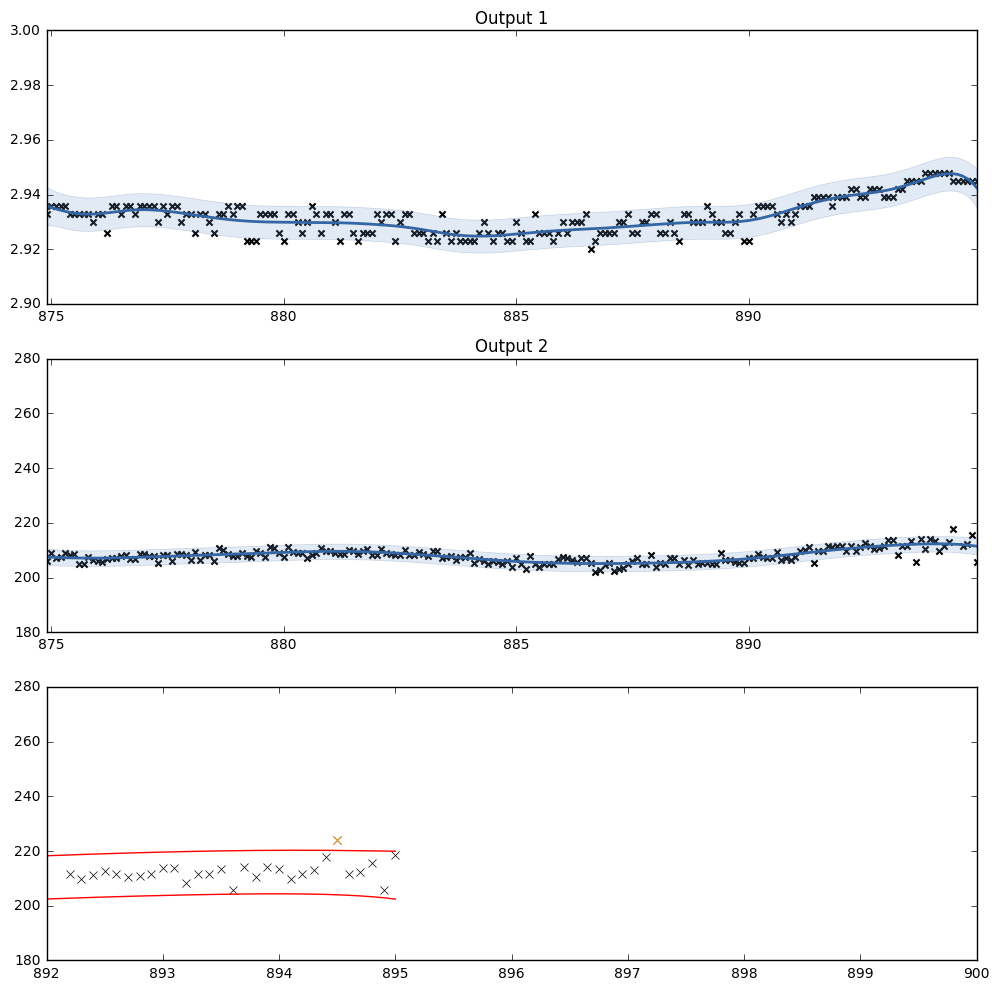

29


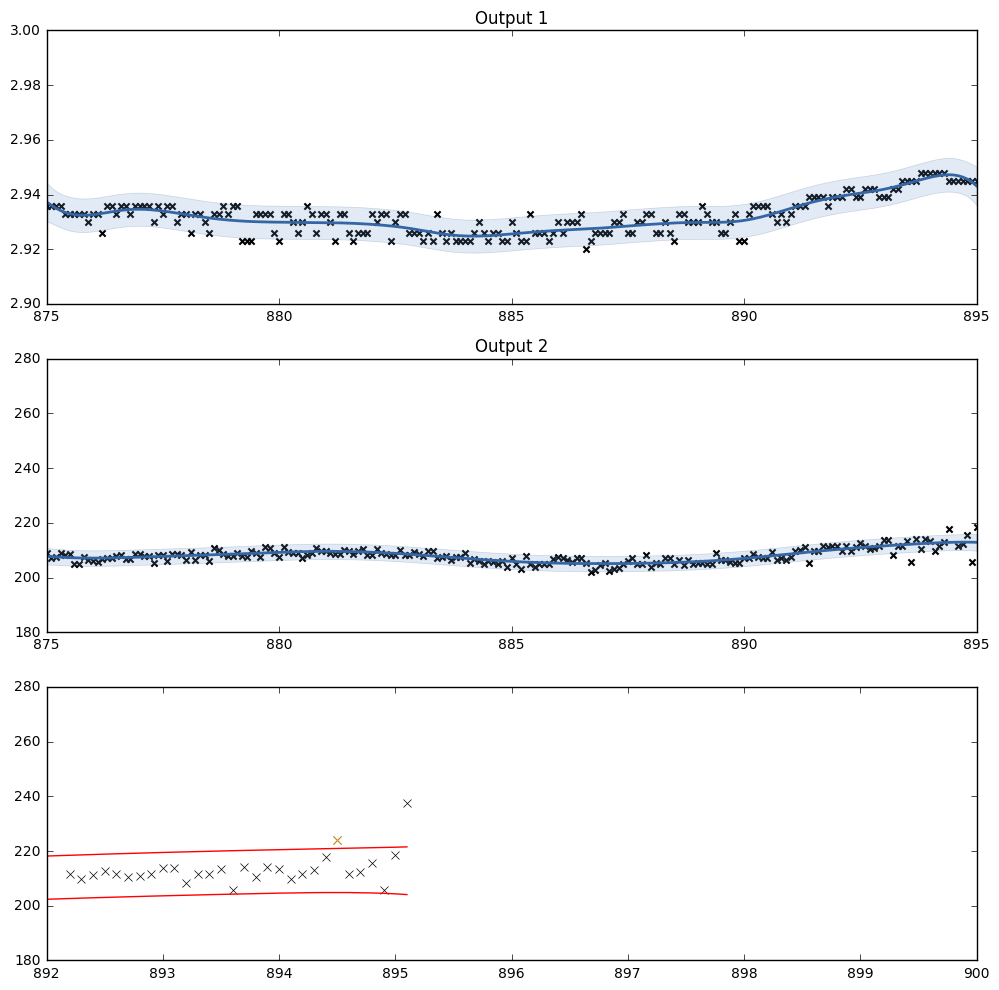

30


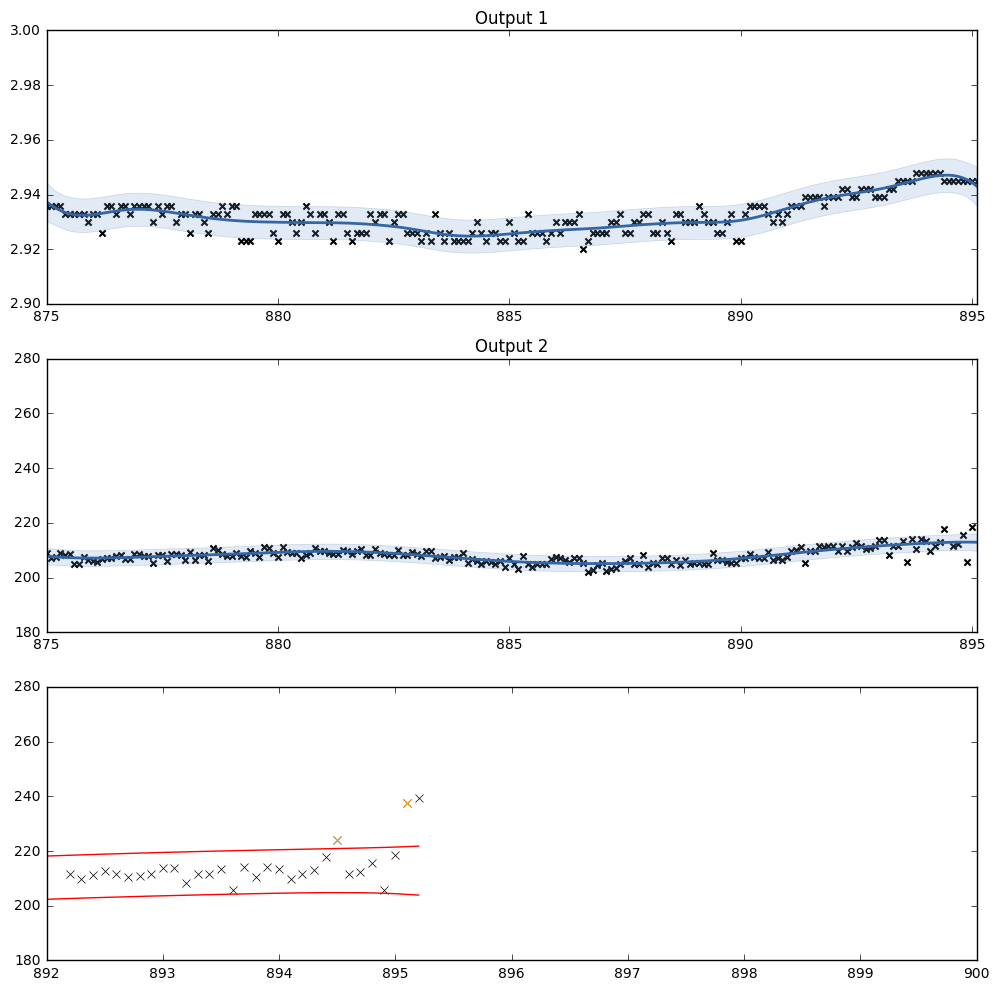

31


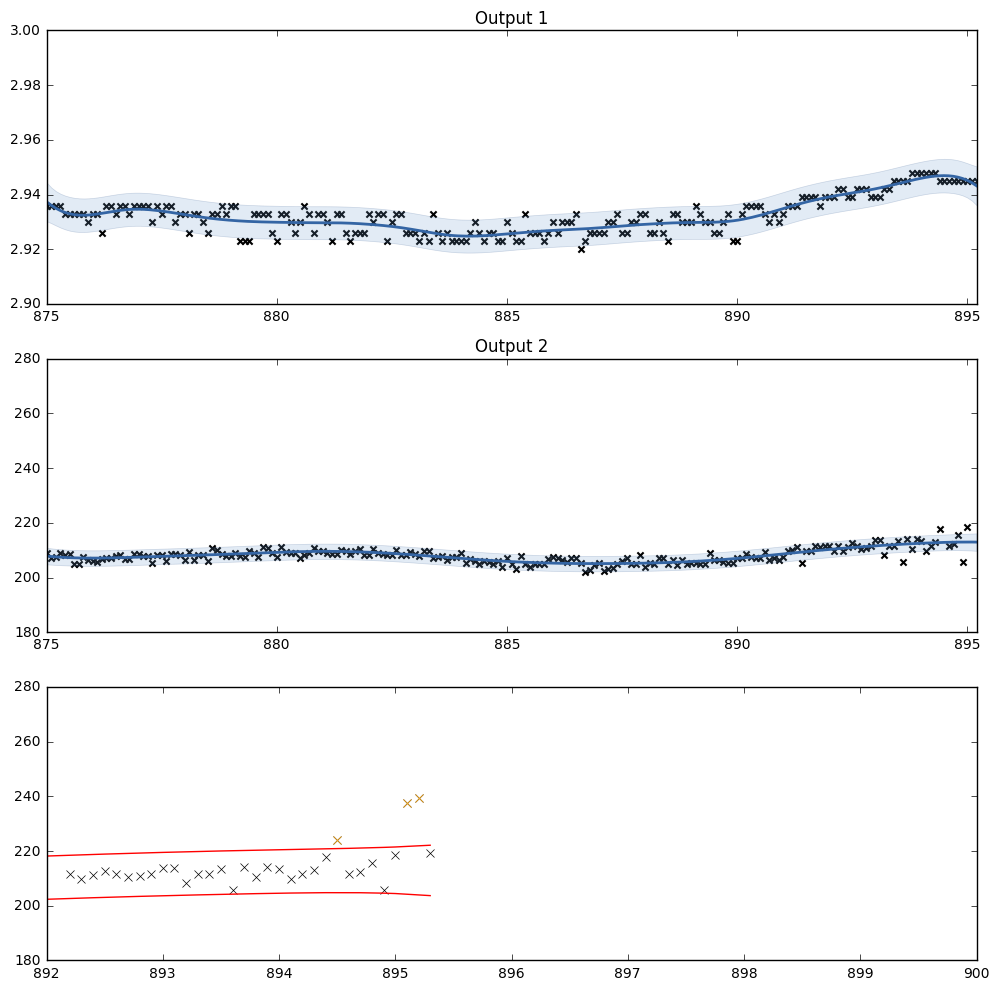

32


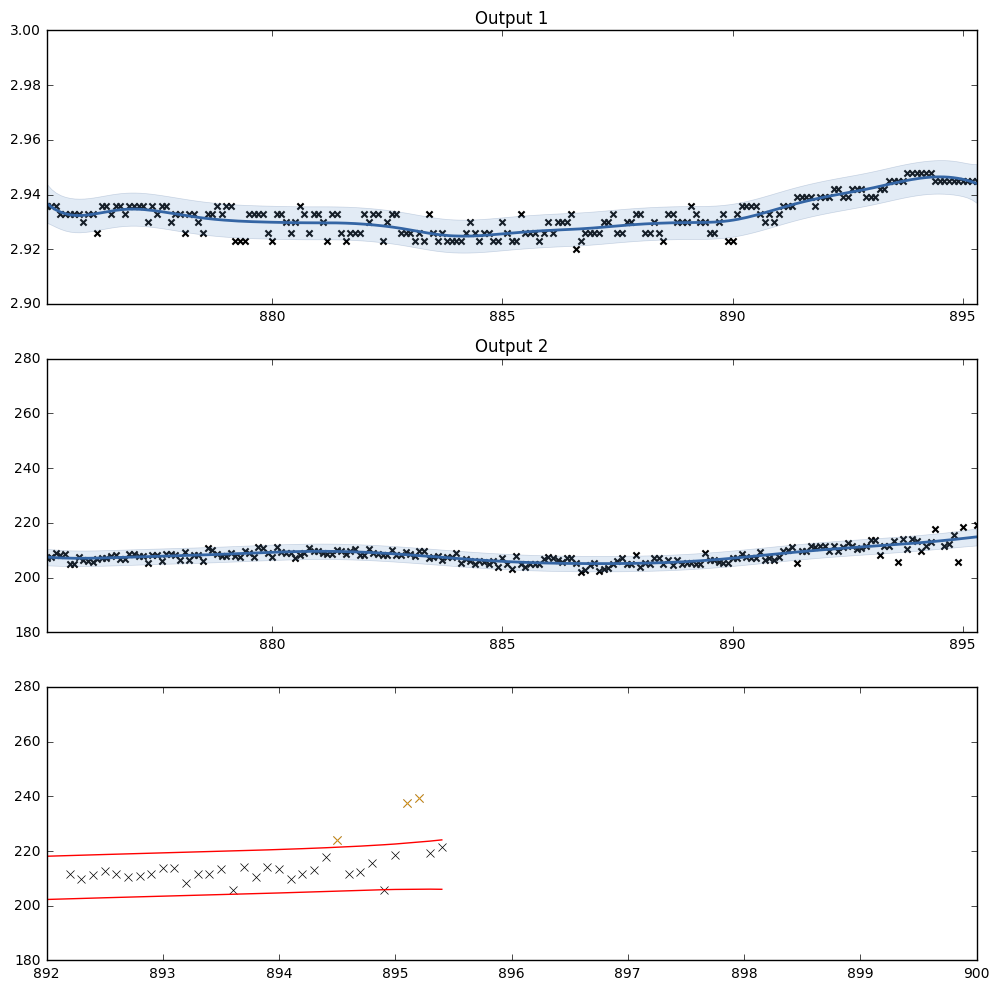

33


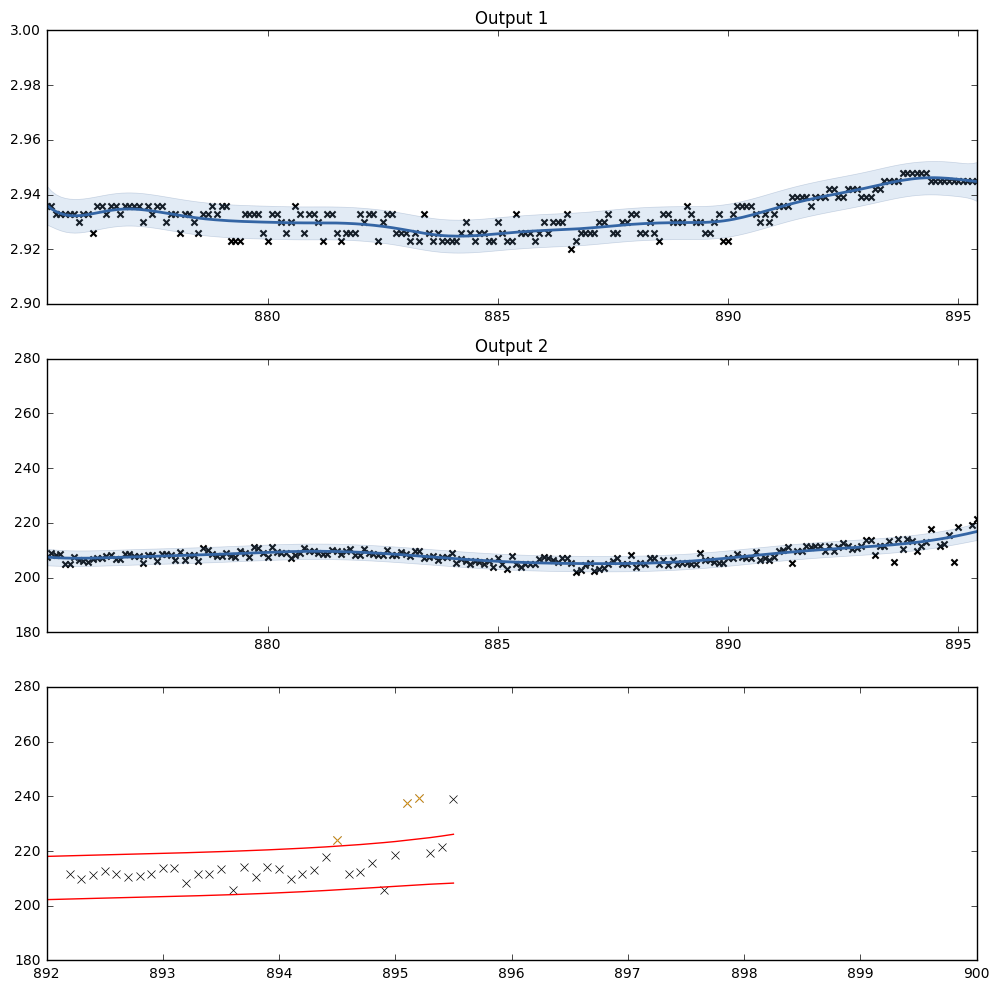

34


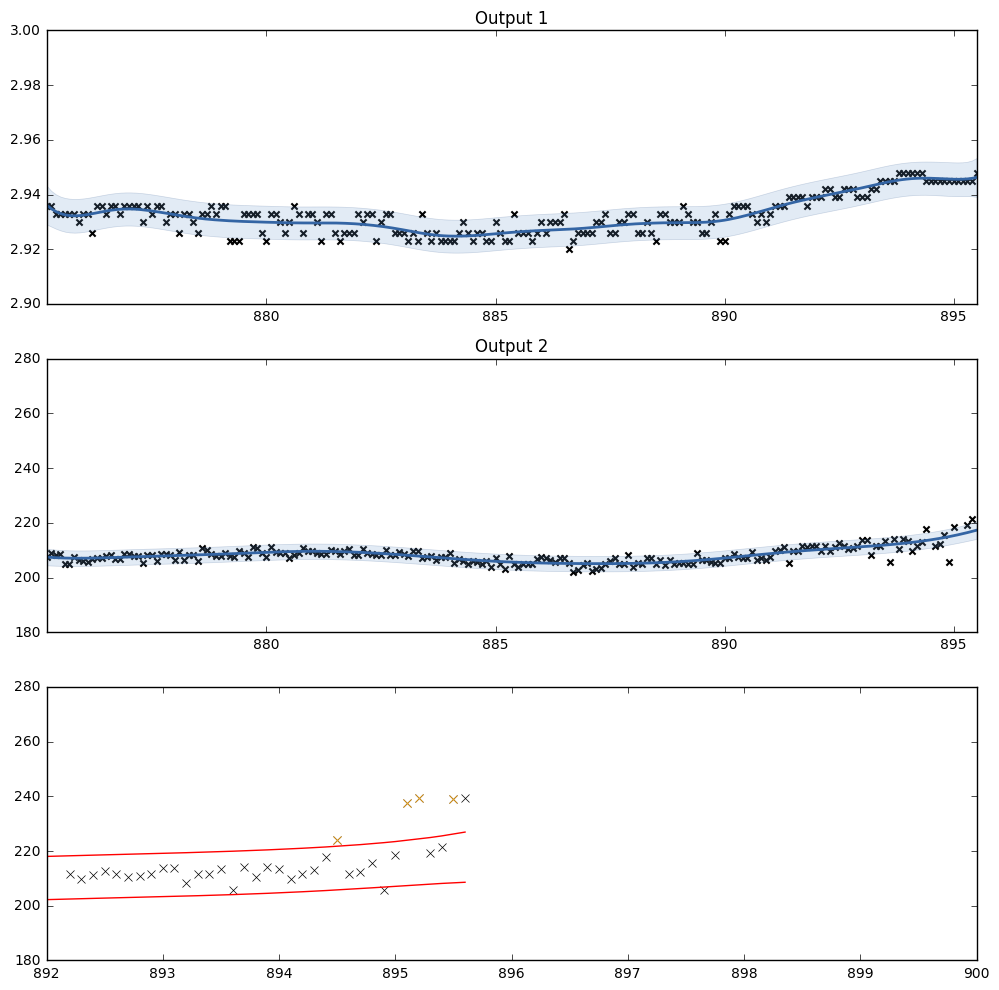

35


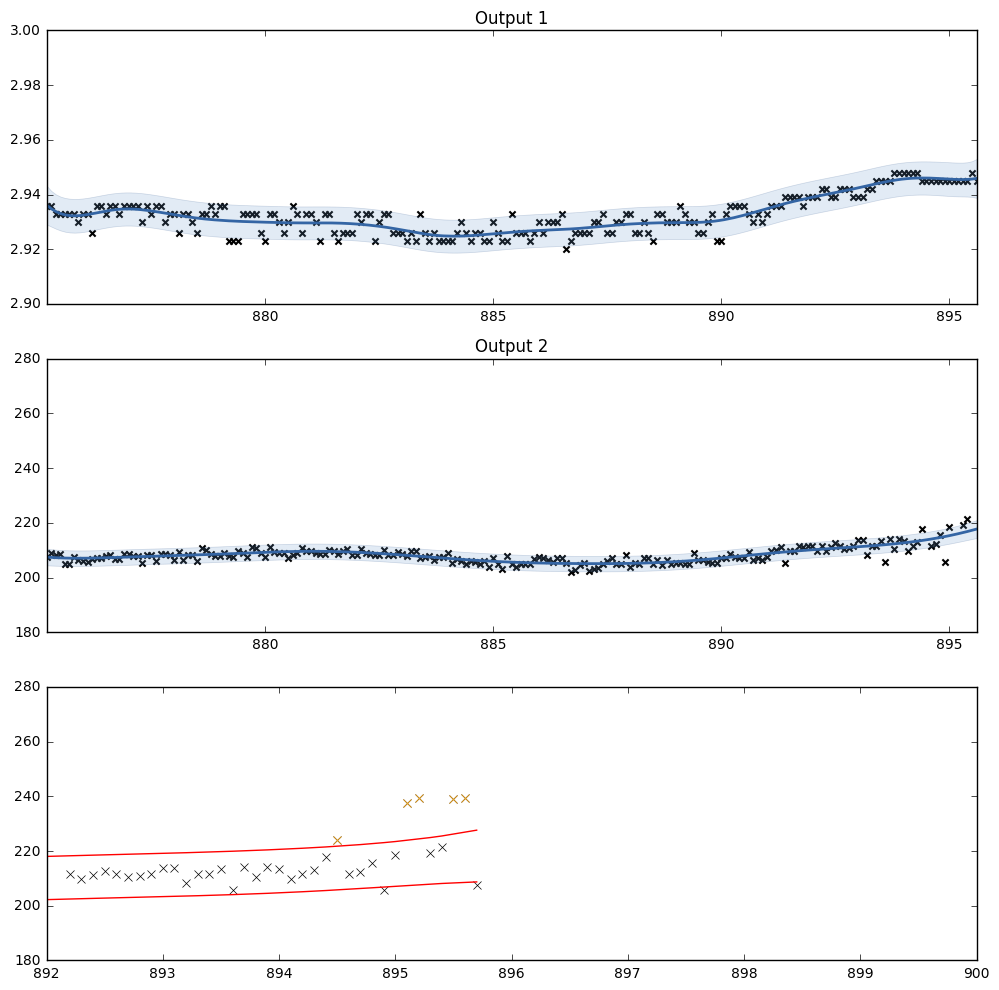

36


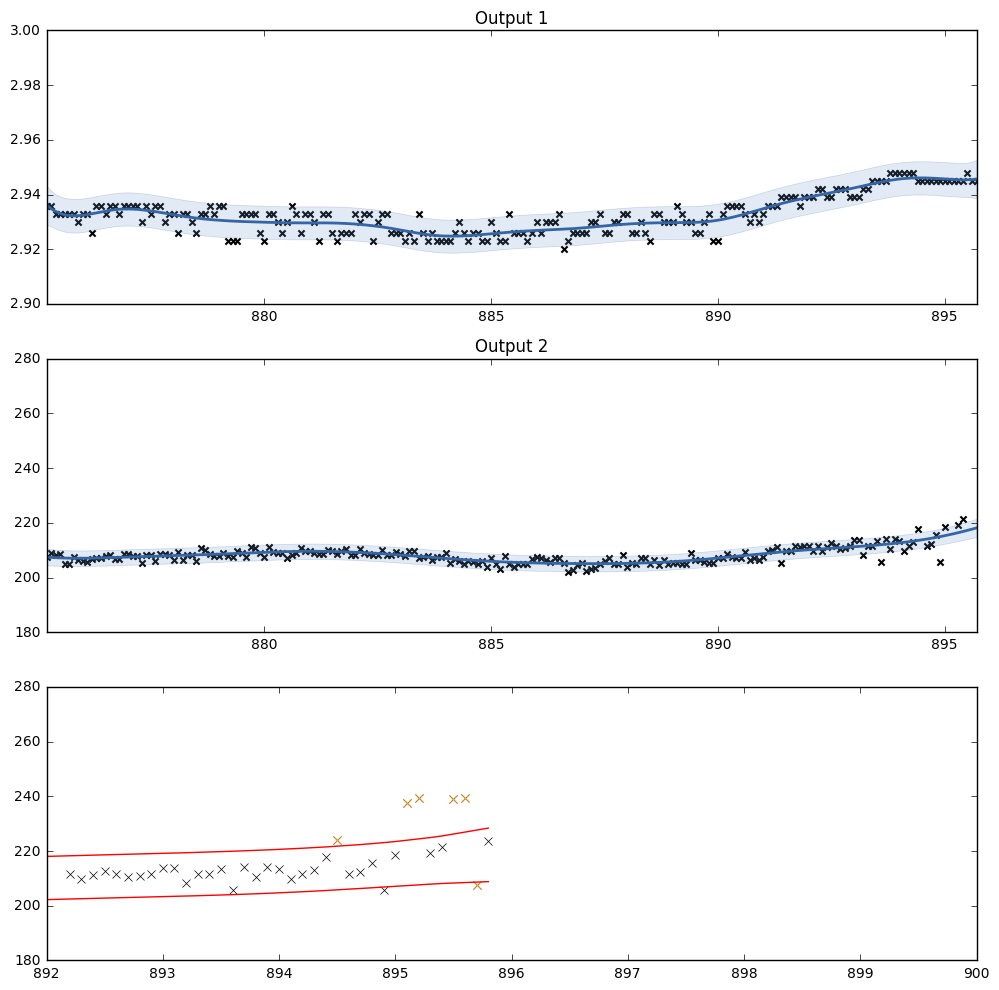

37


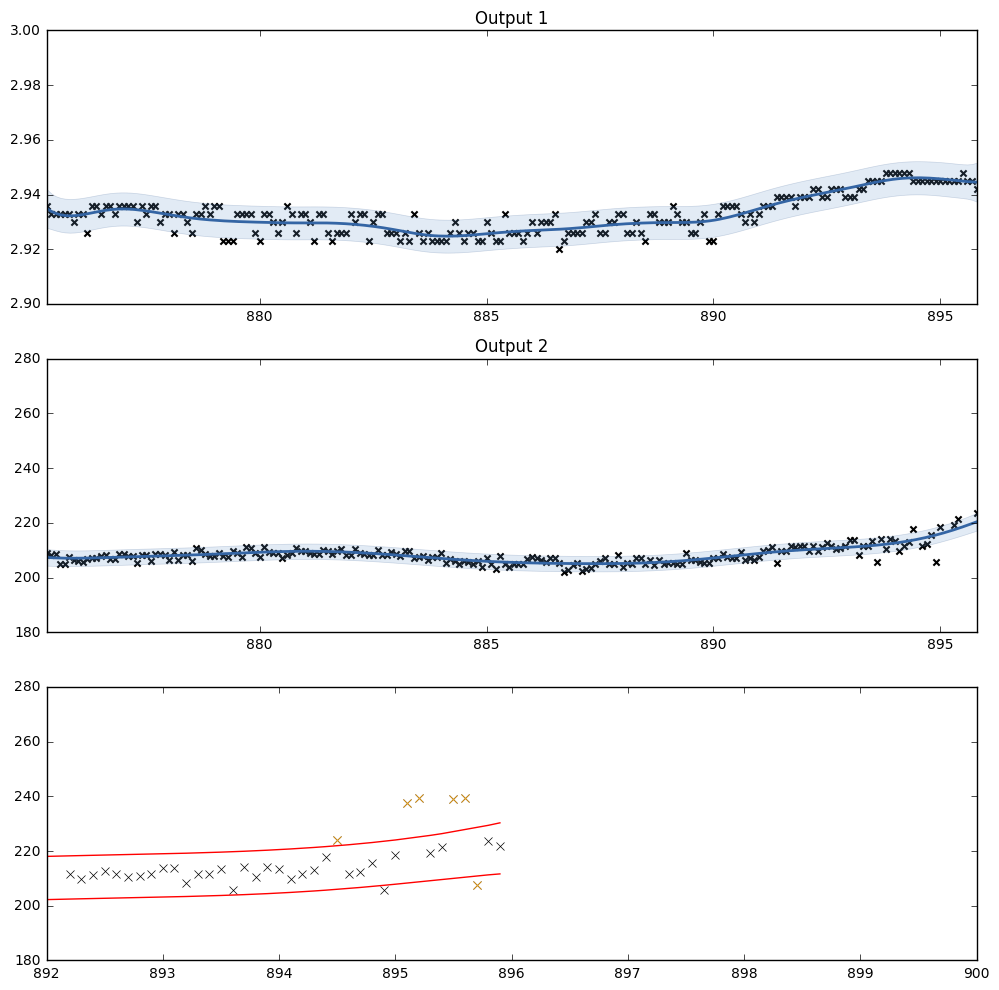

38


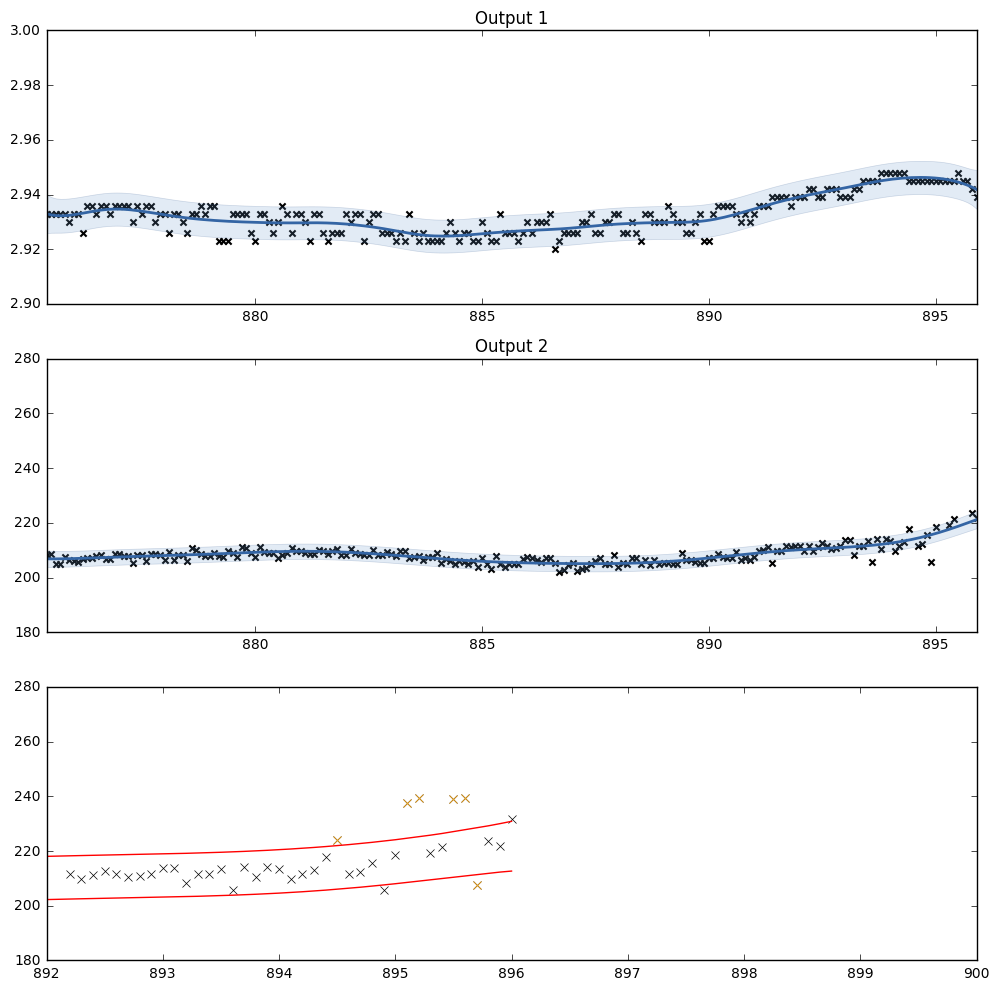

39


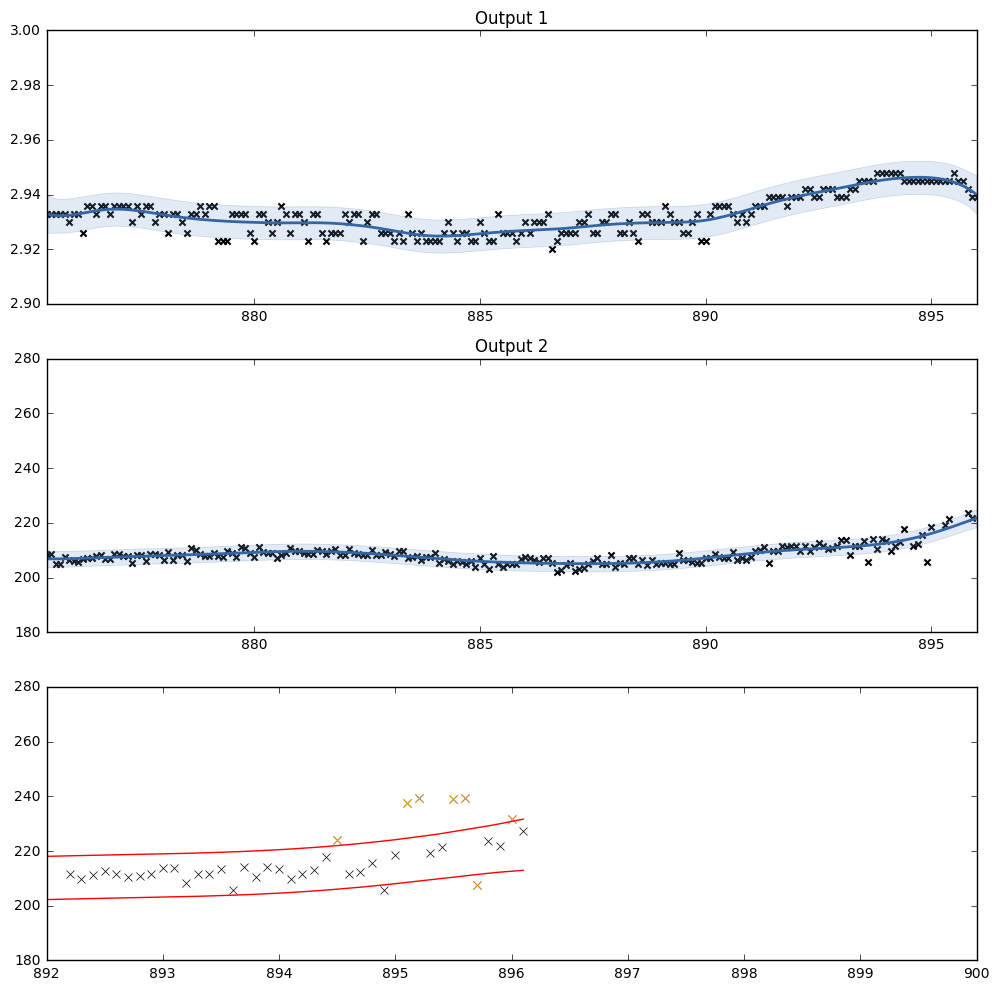

40


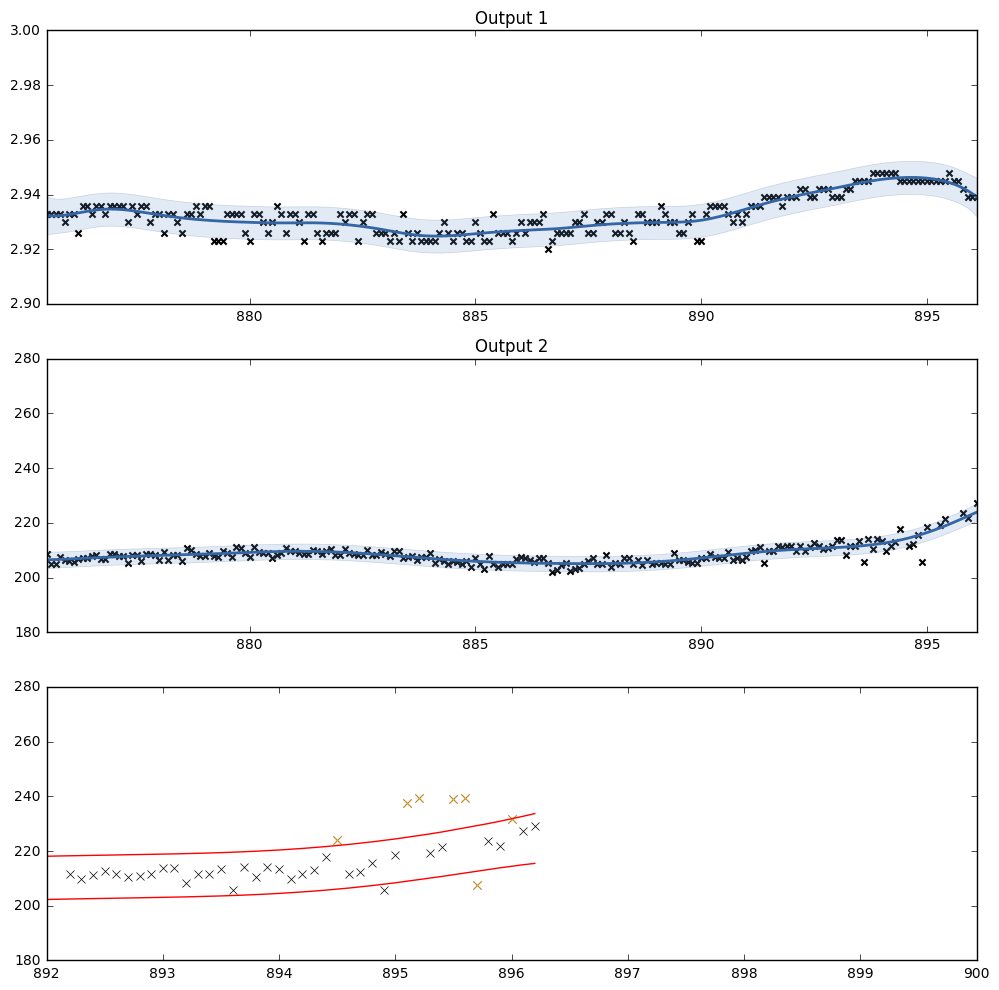

41


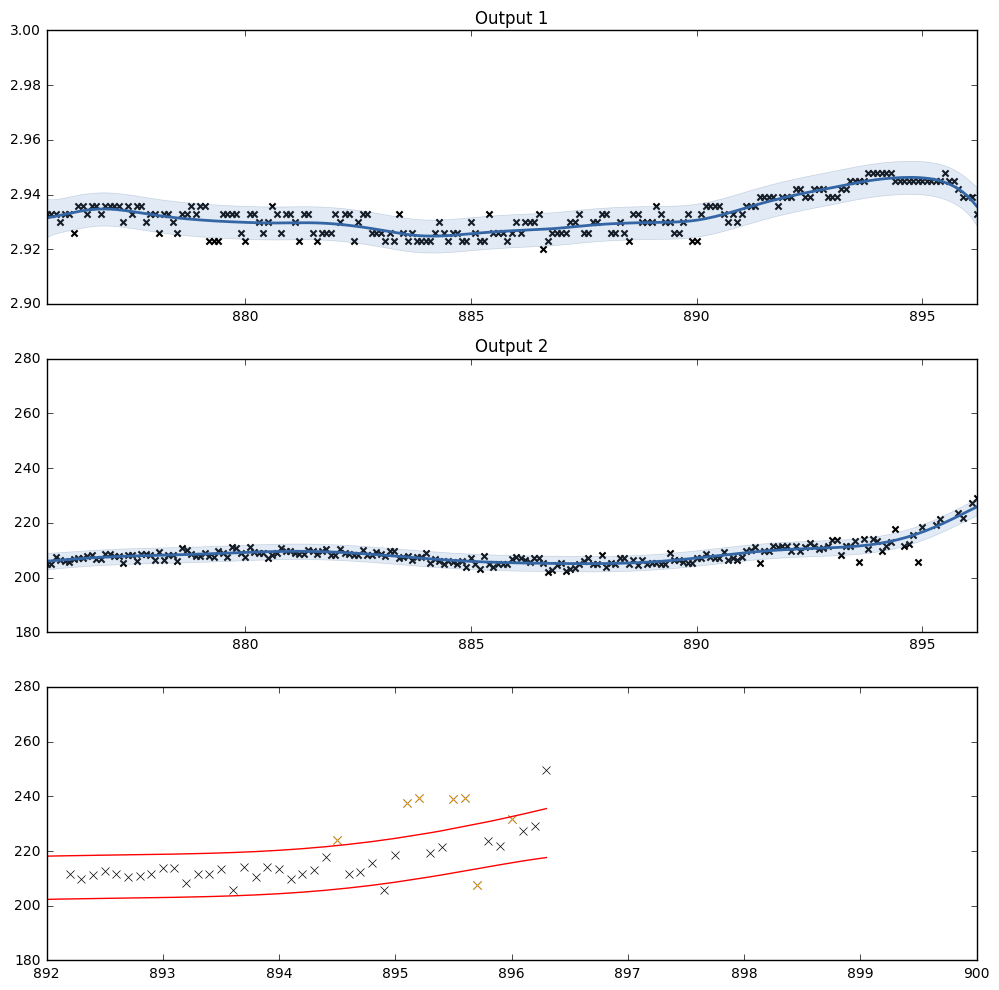

42


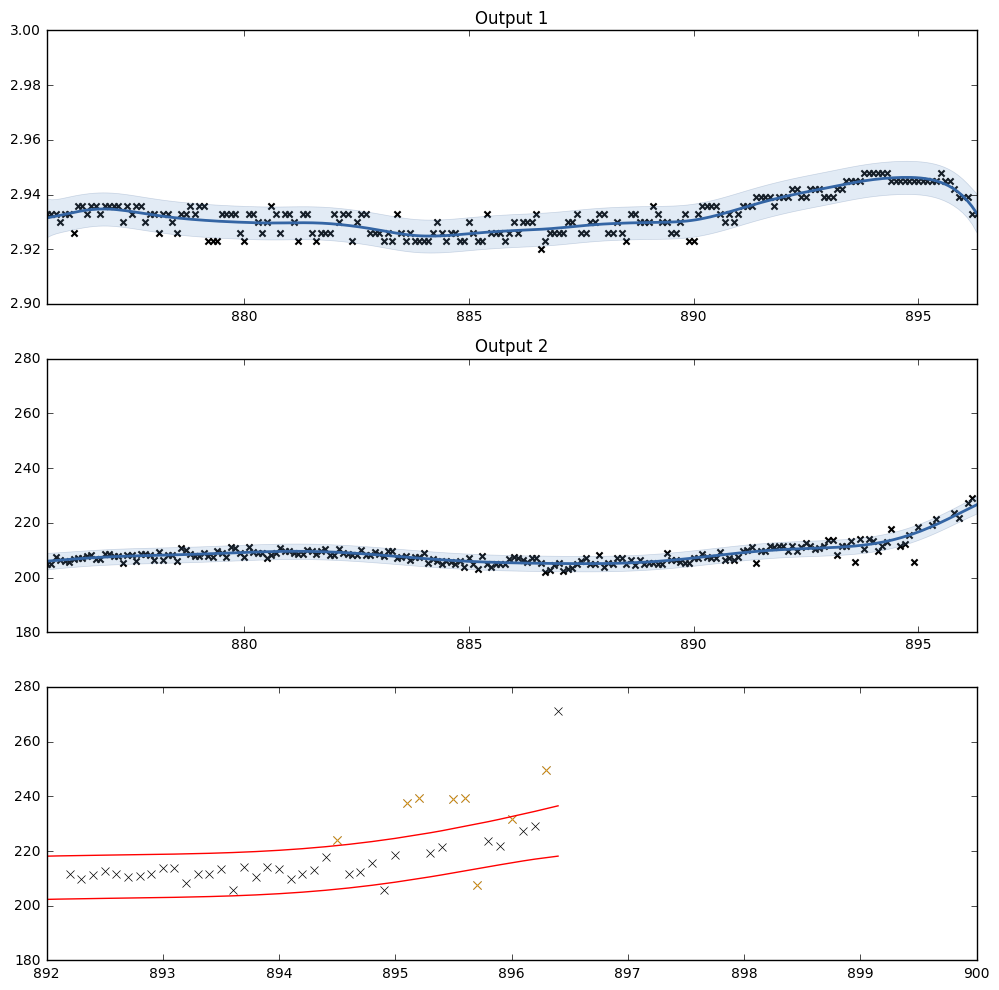

43


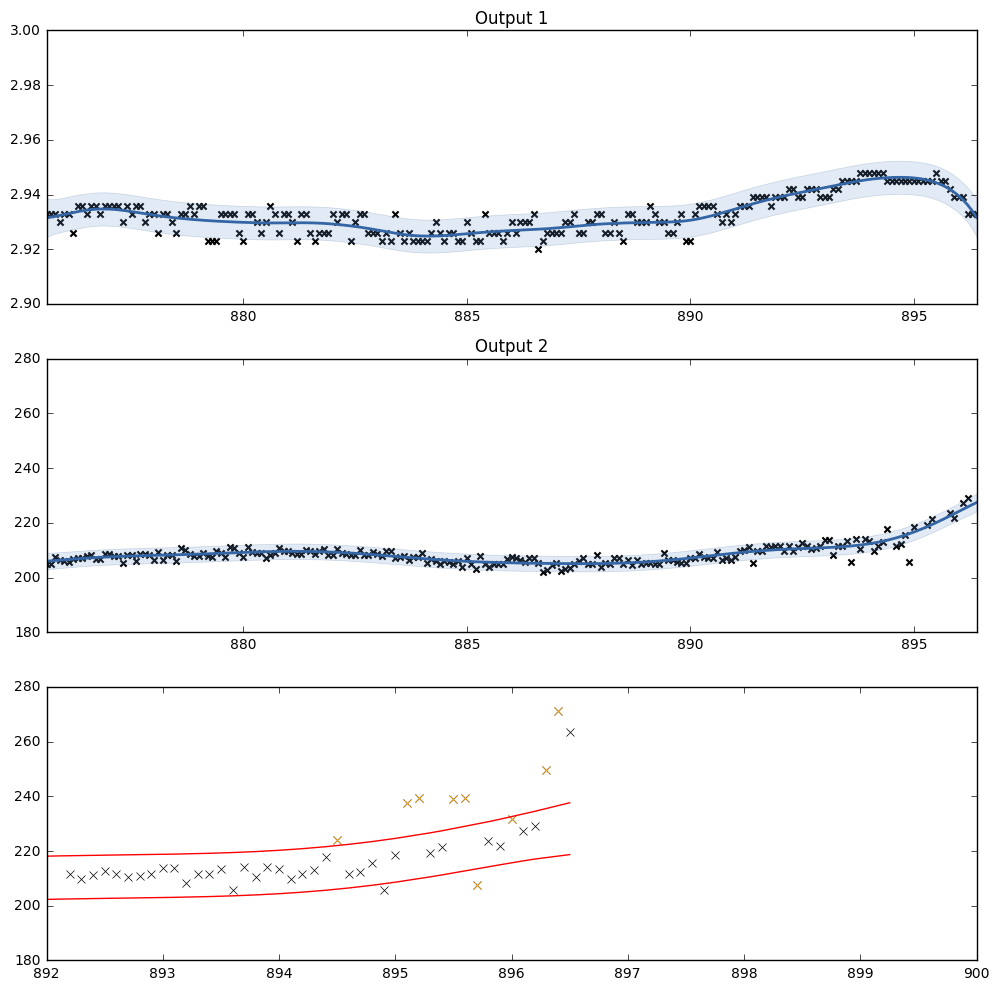

44


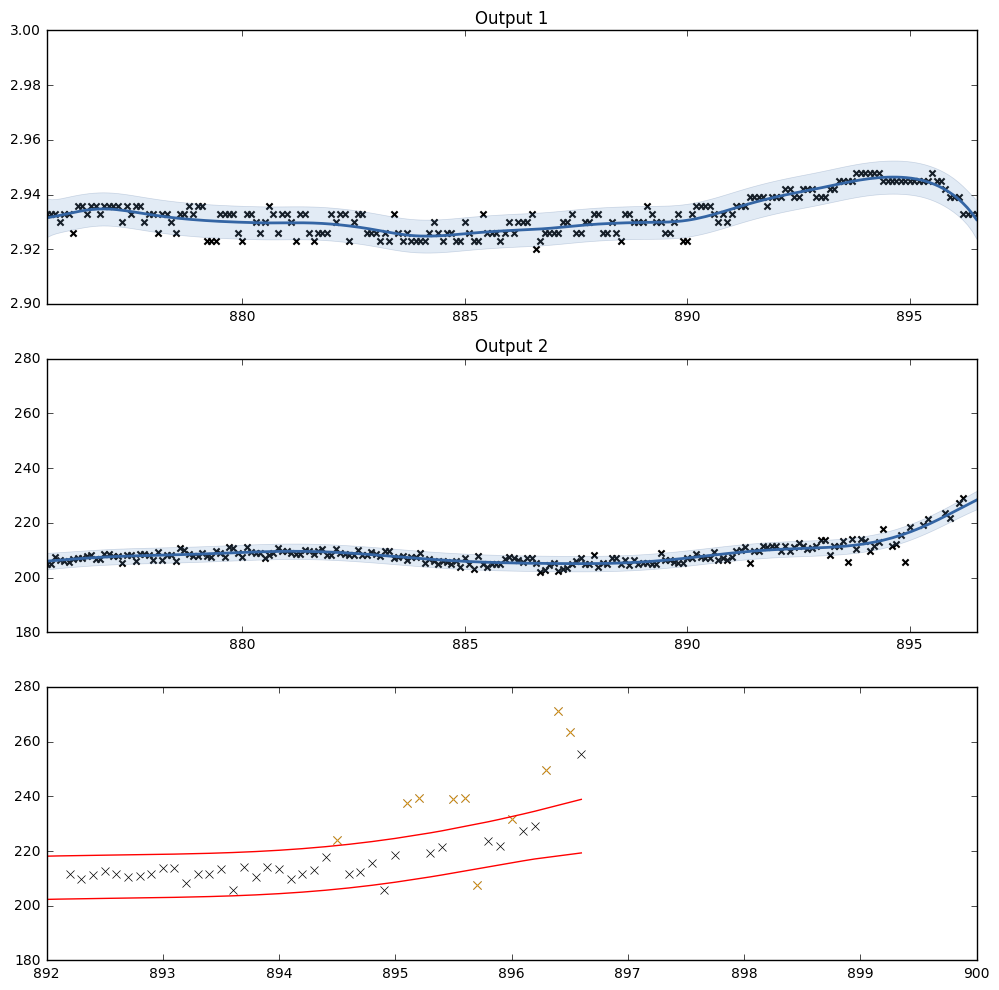

45


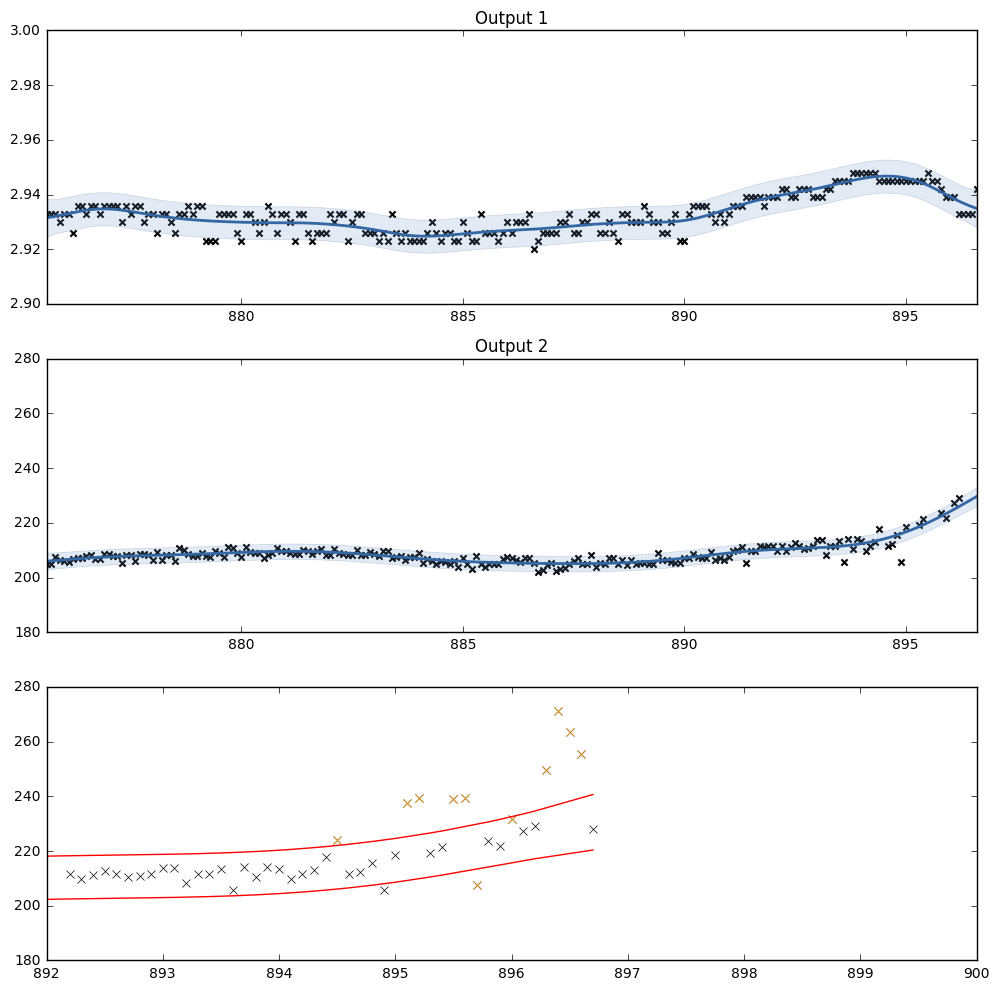

46


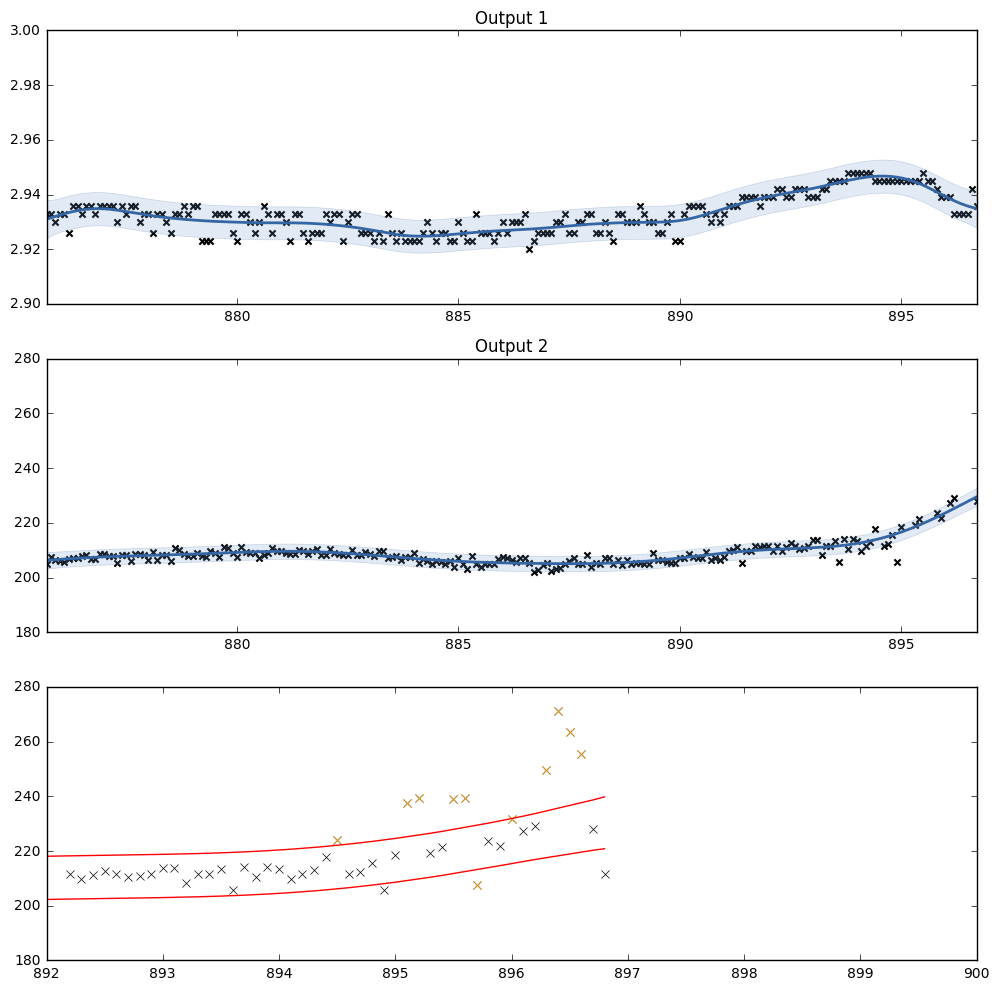

47


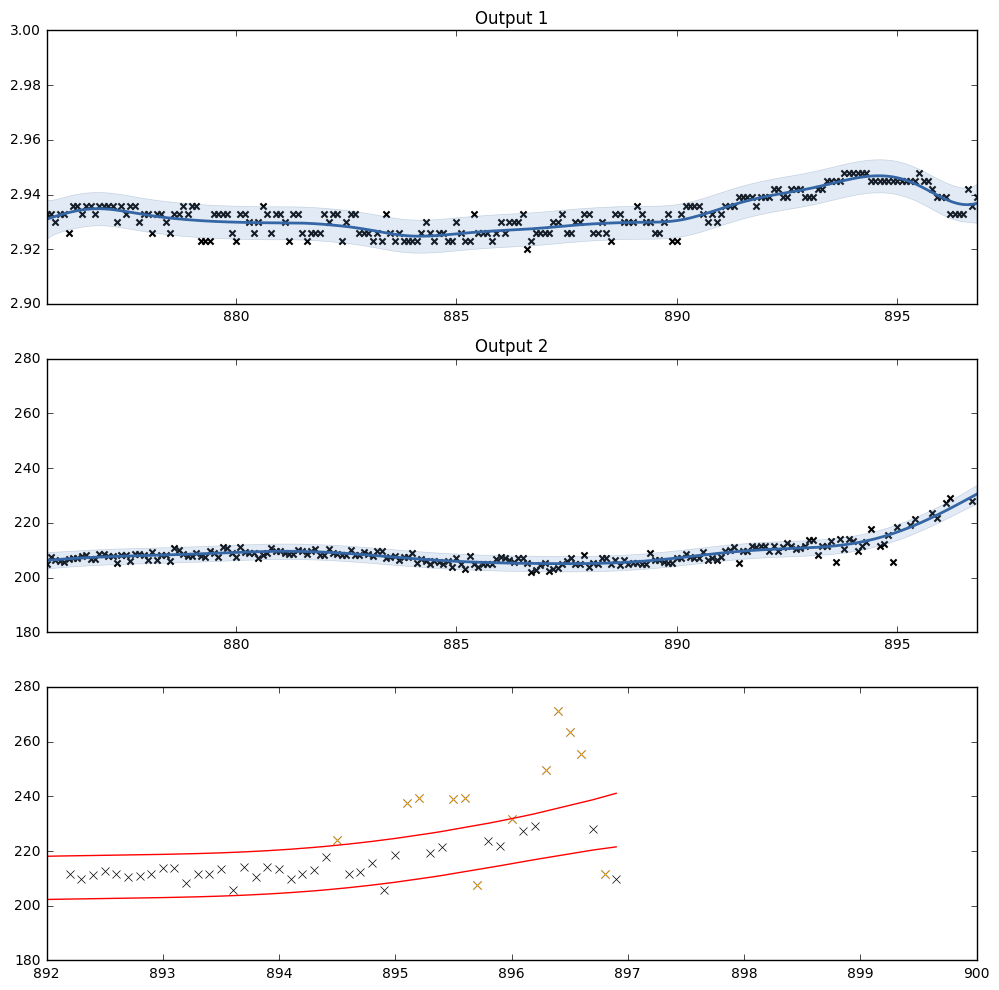

48


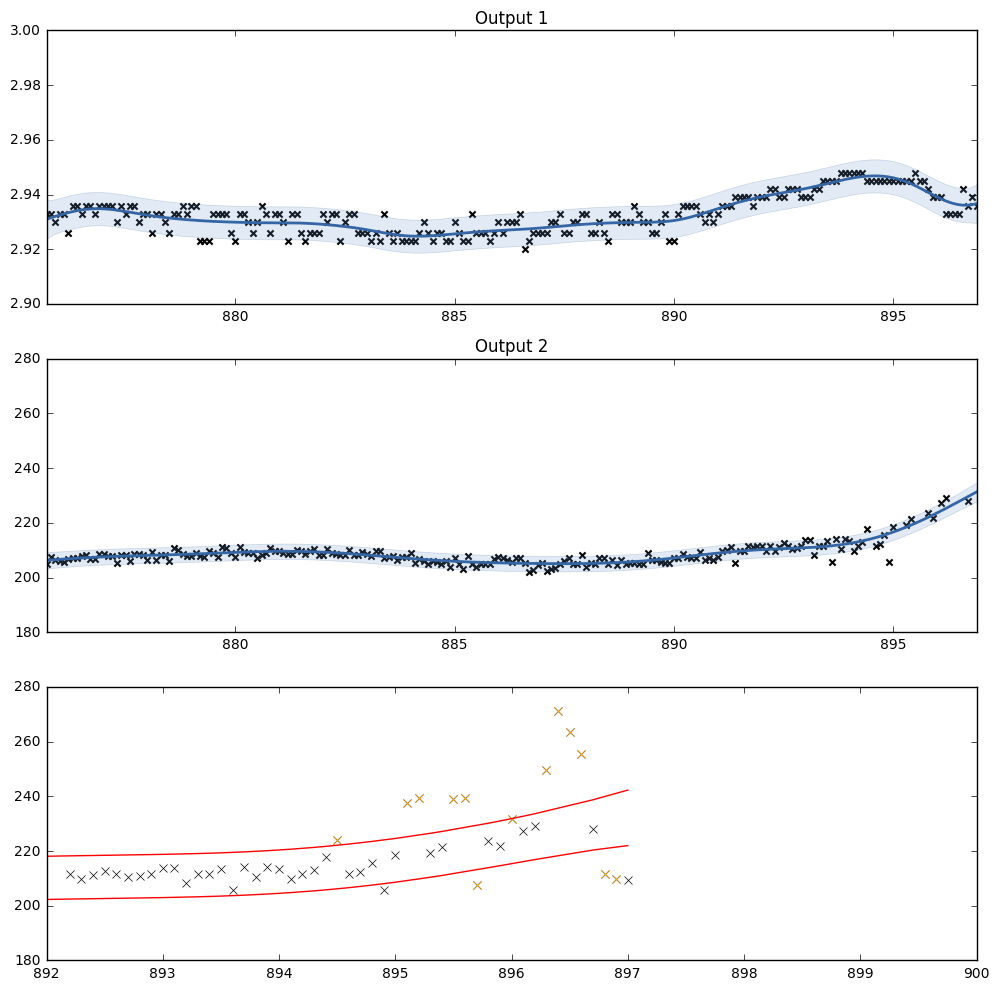

49


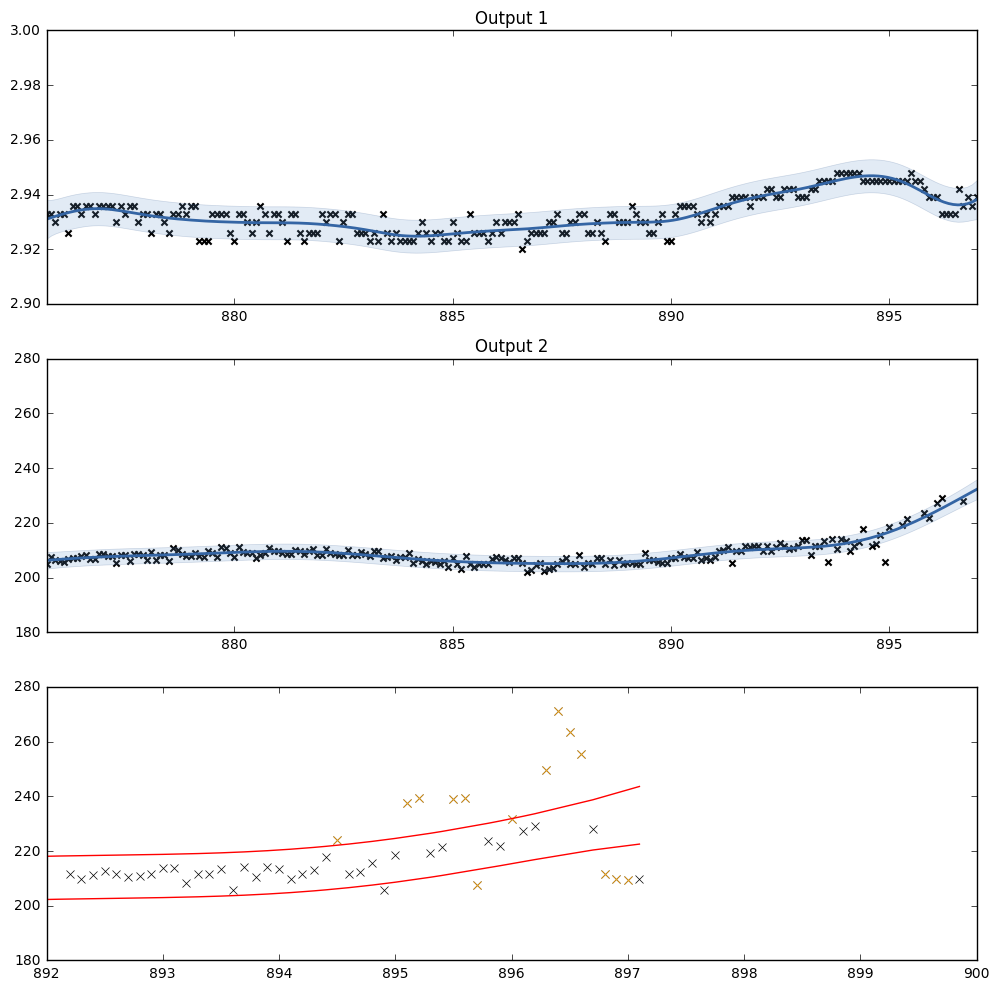

50


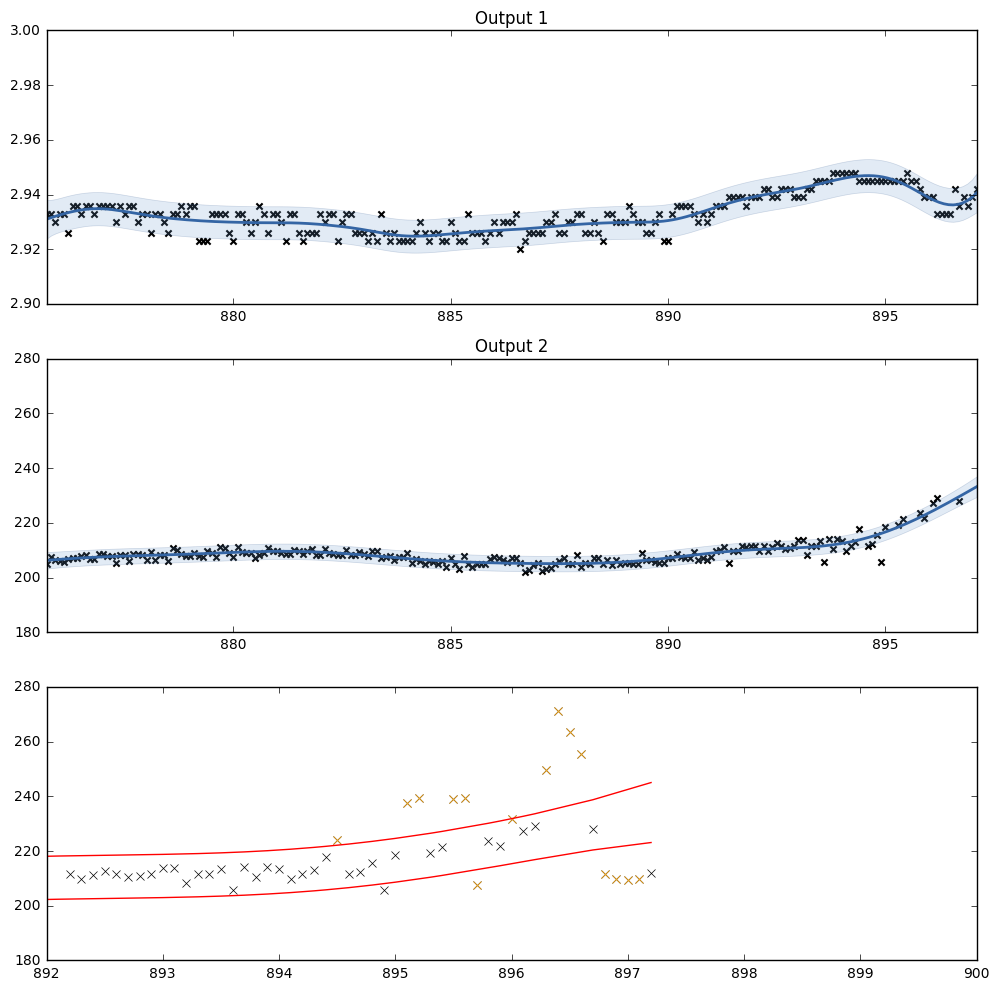

51


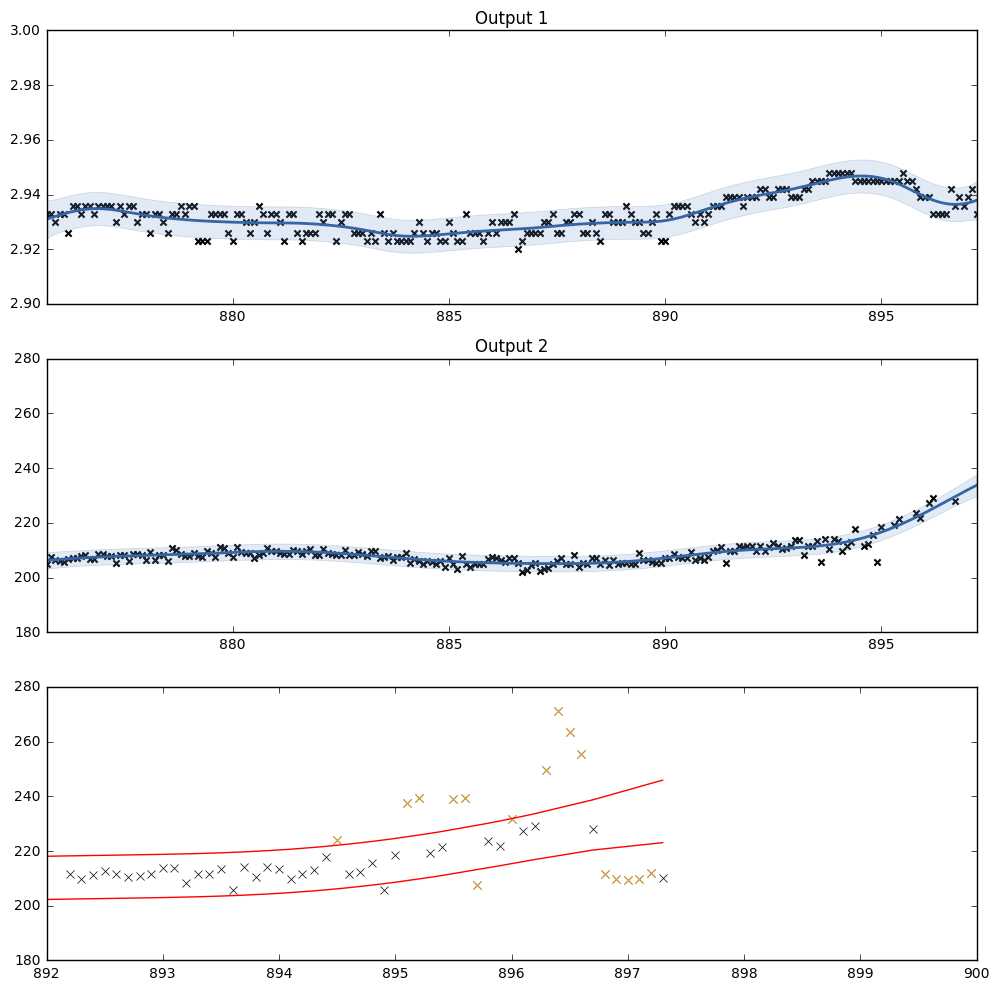

52


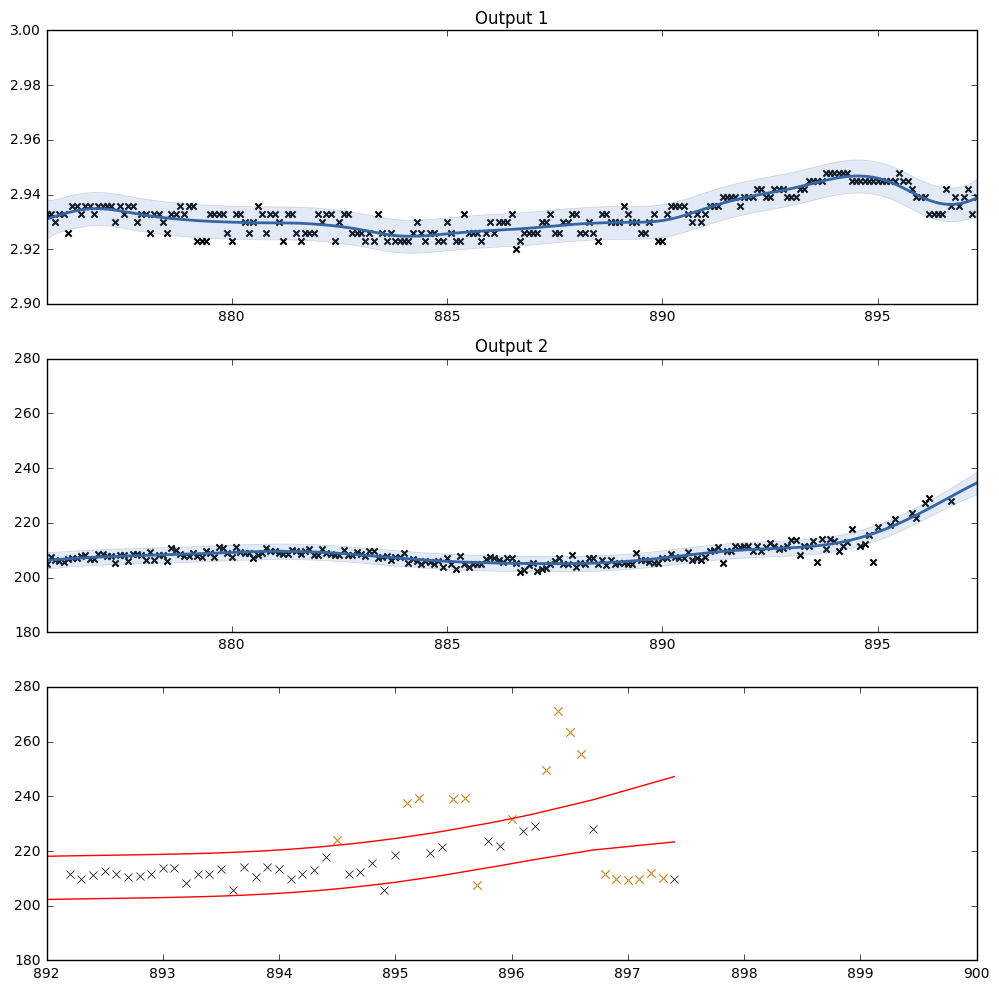

53


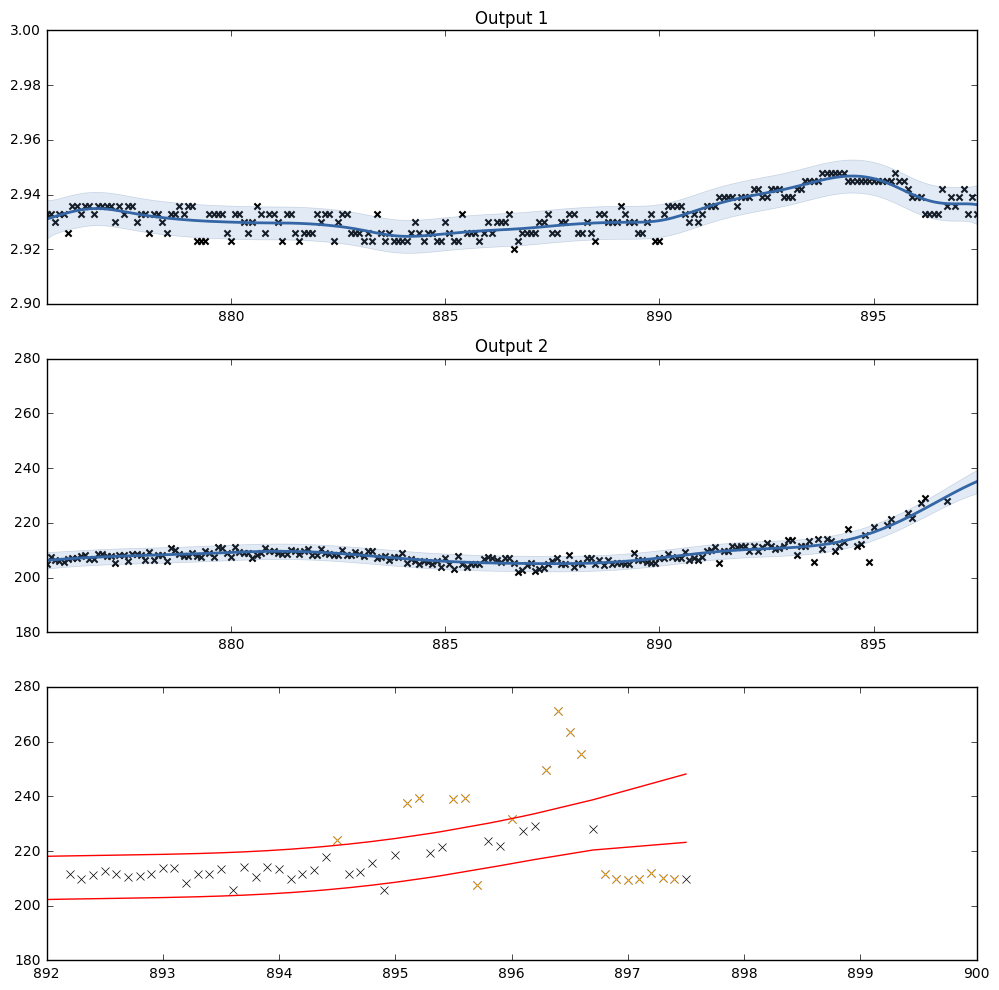

54


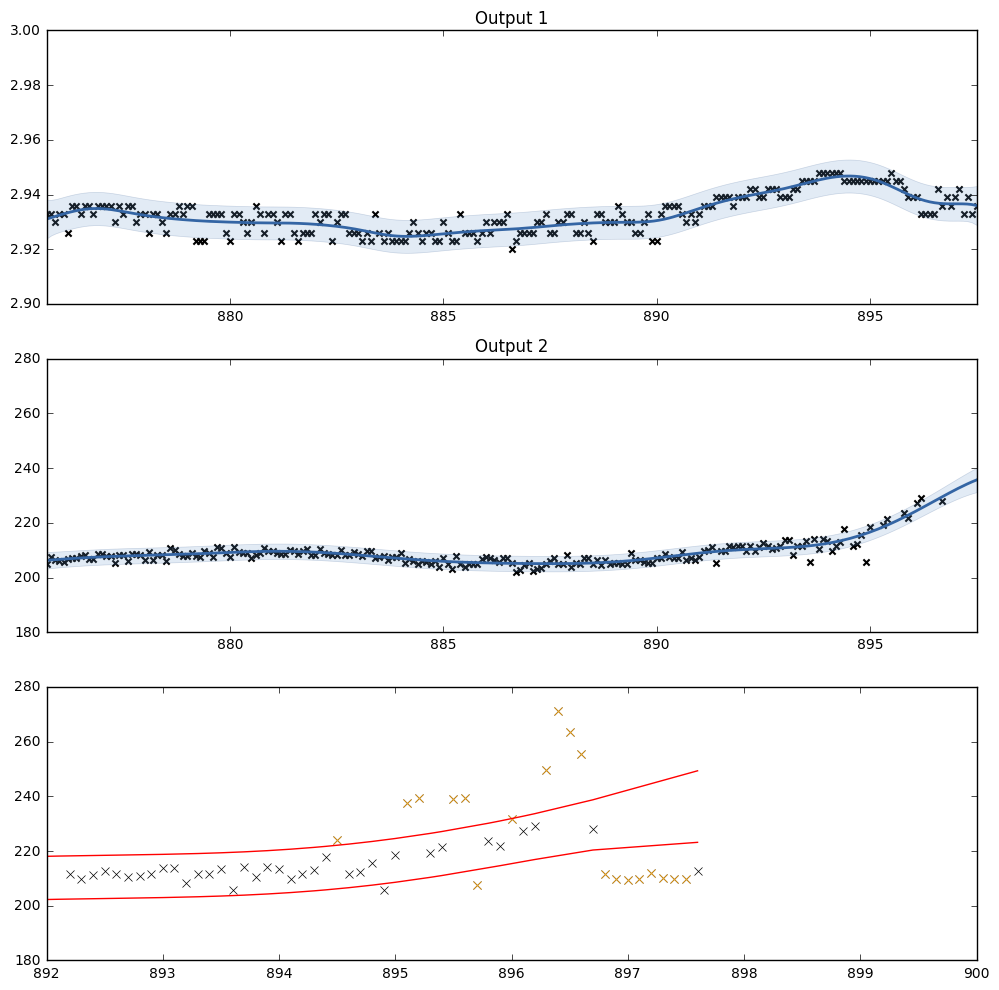

55


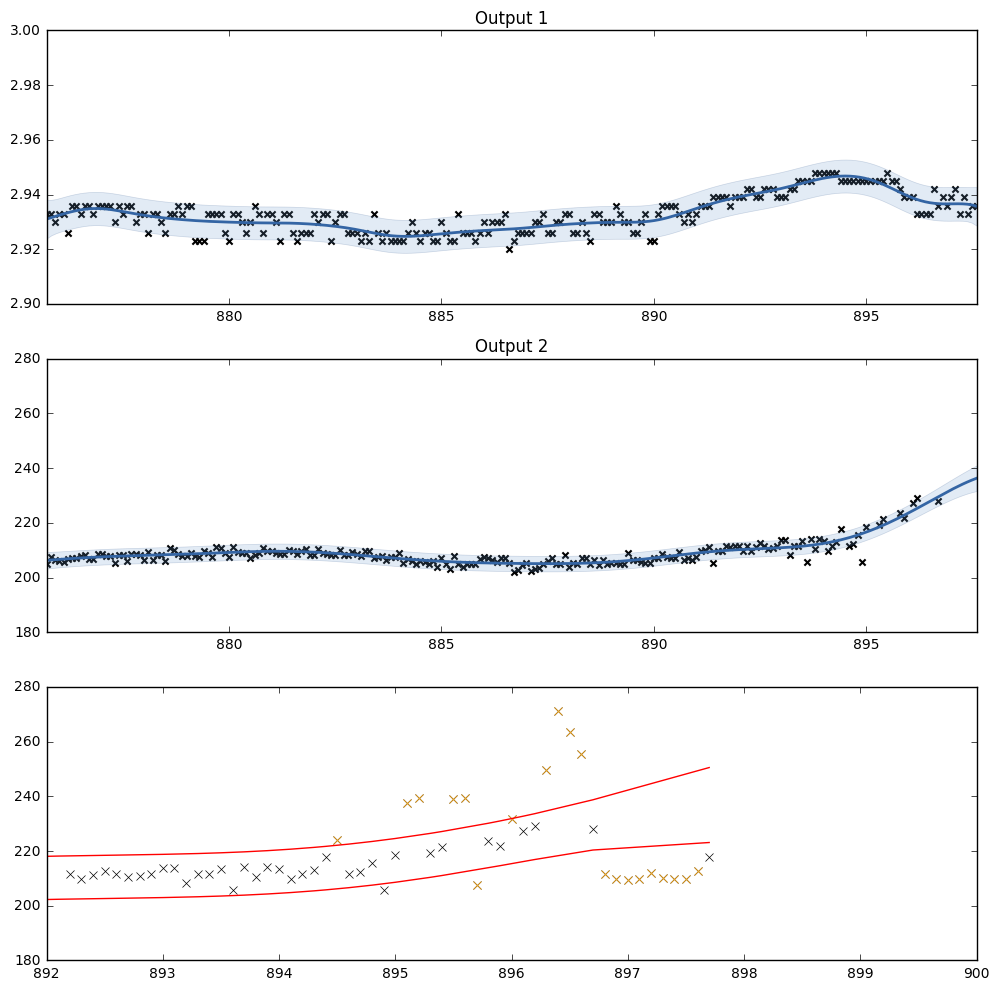

56


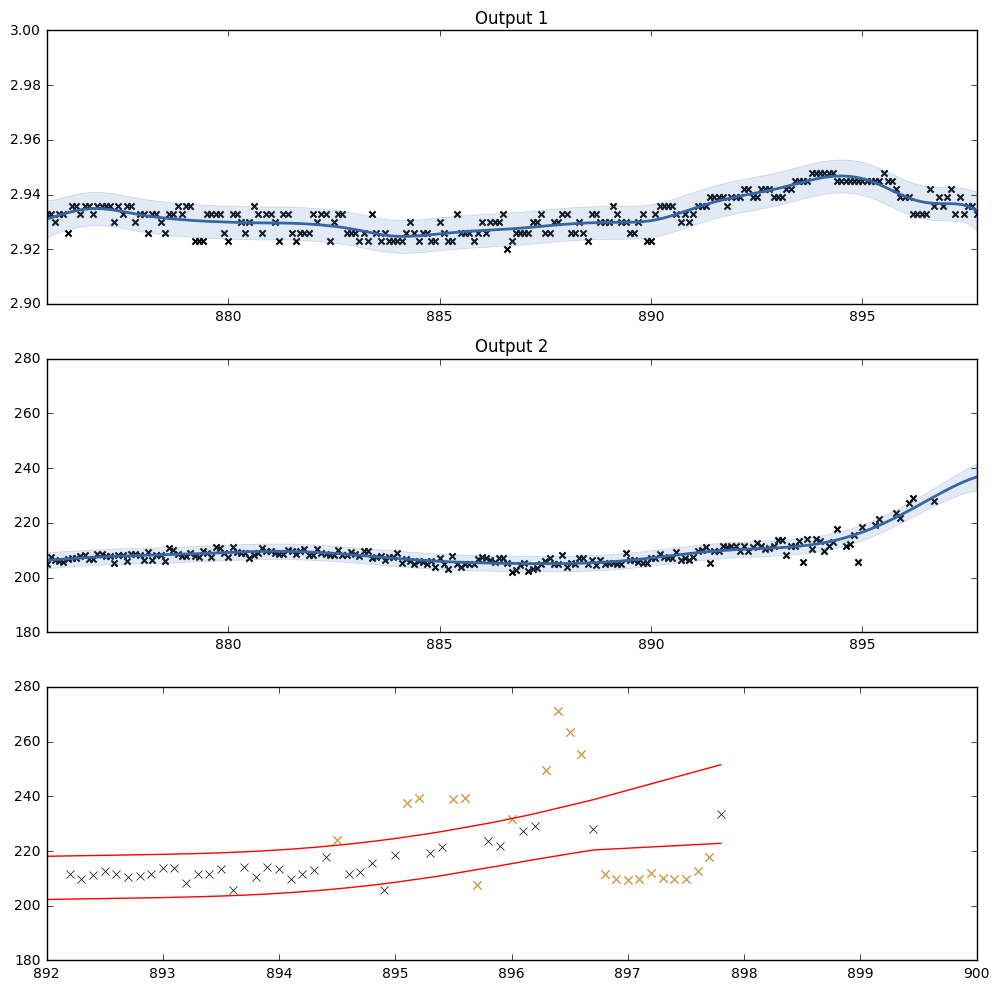

57


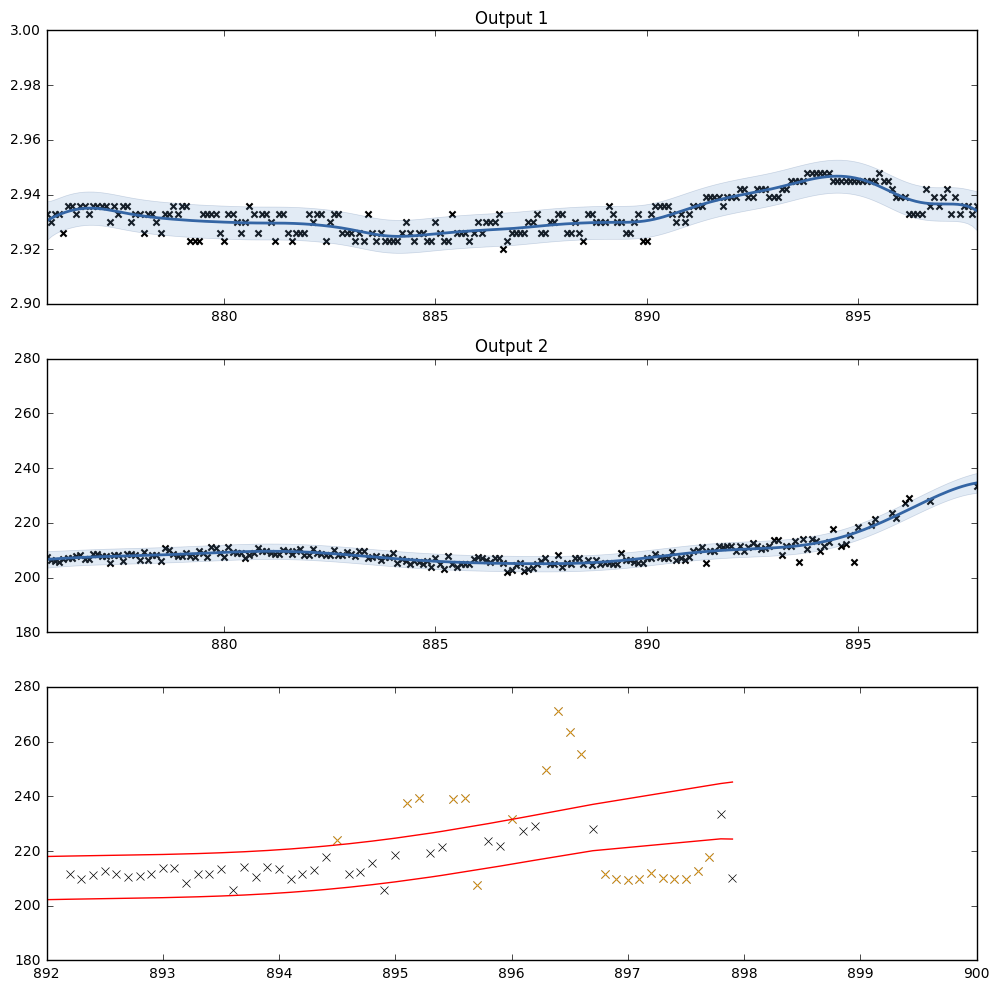

58


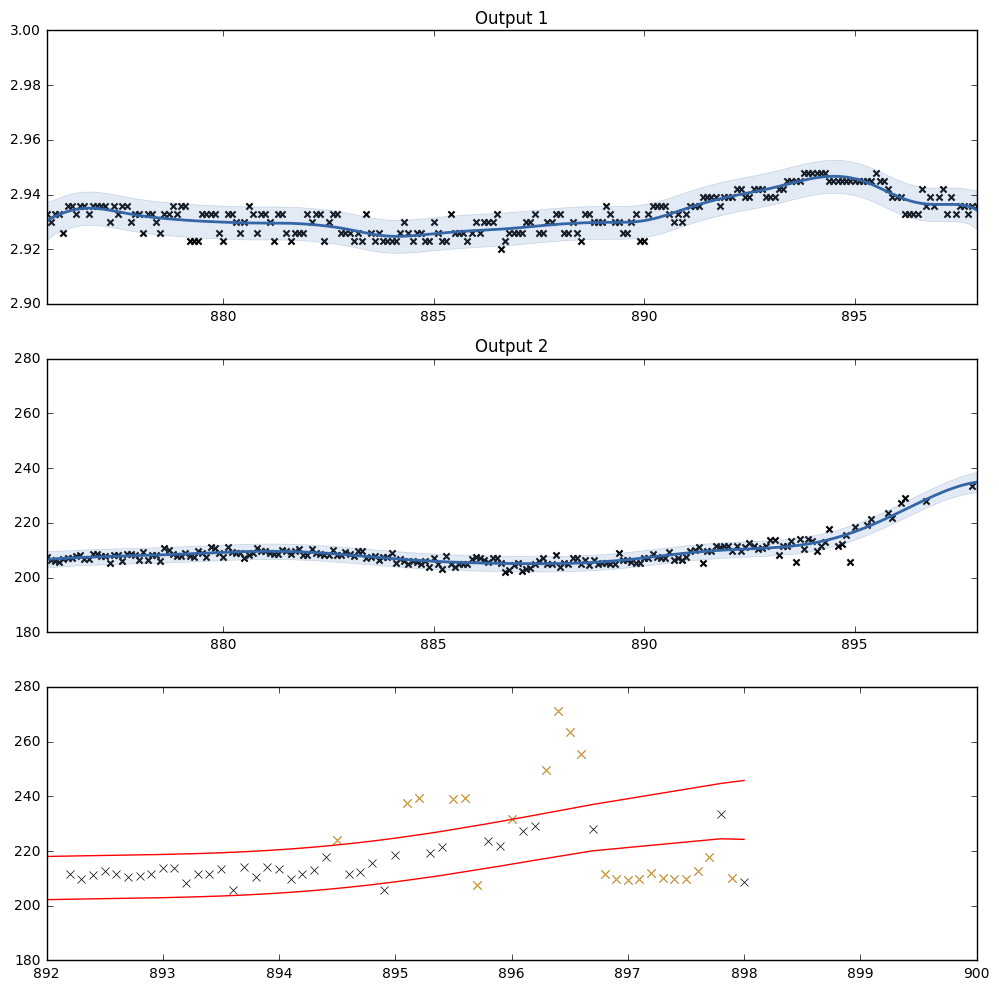

59


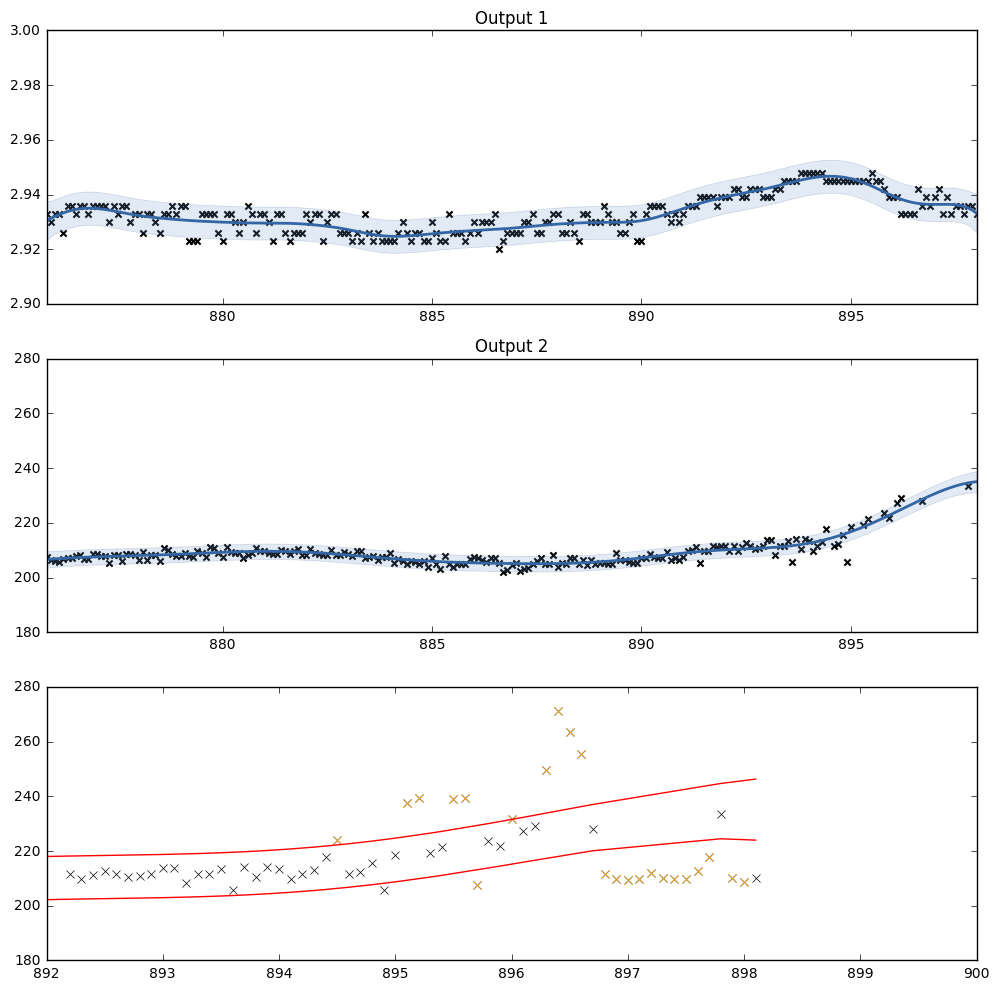

60


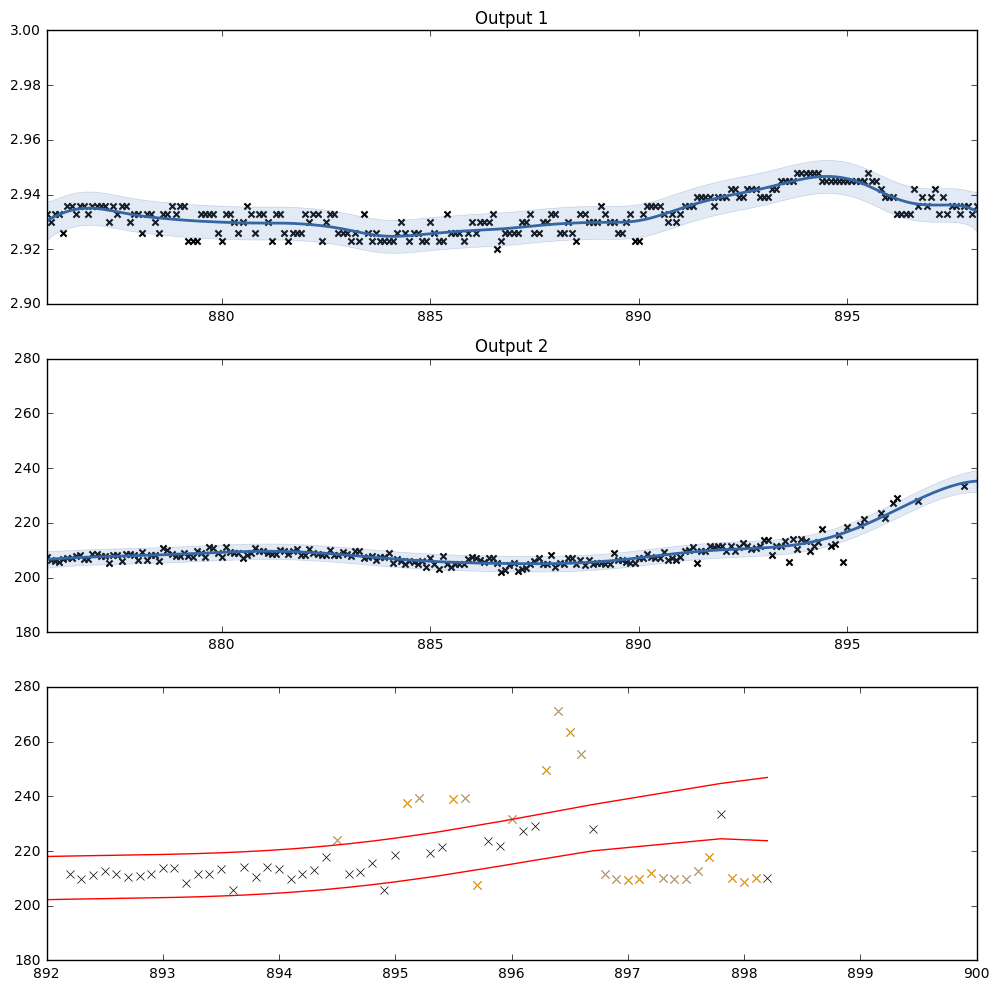

61


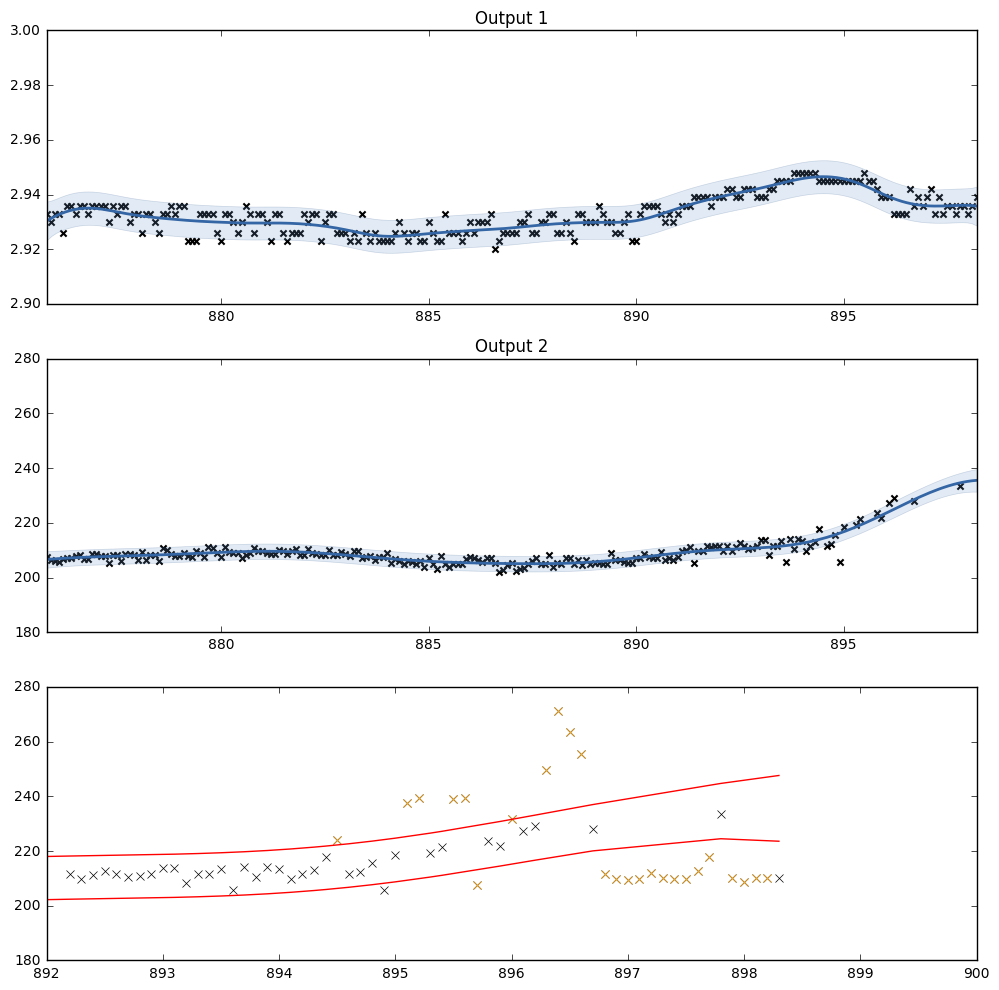

62


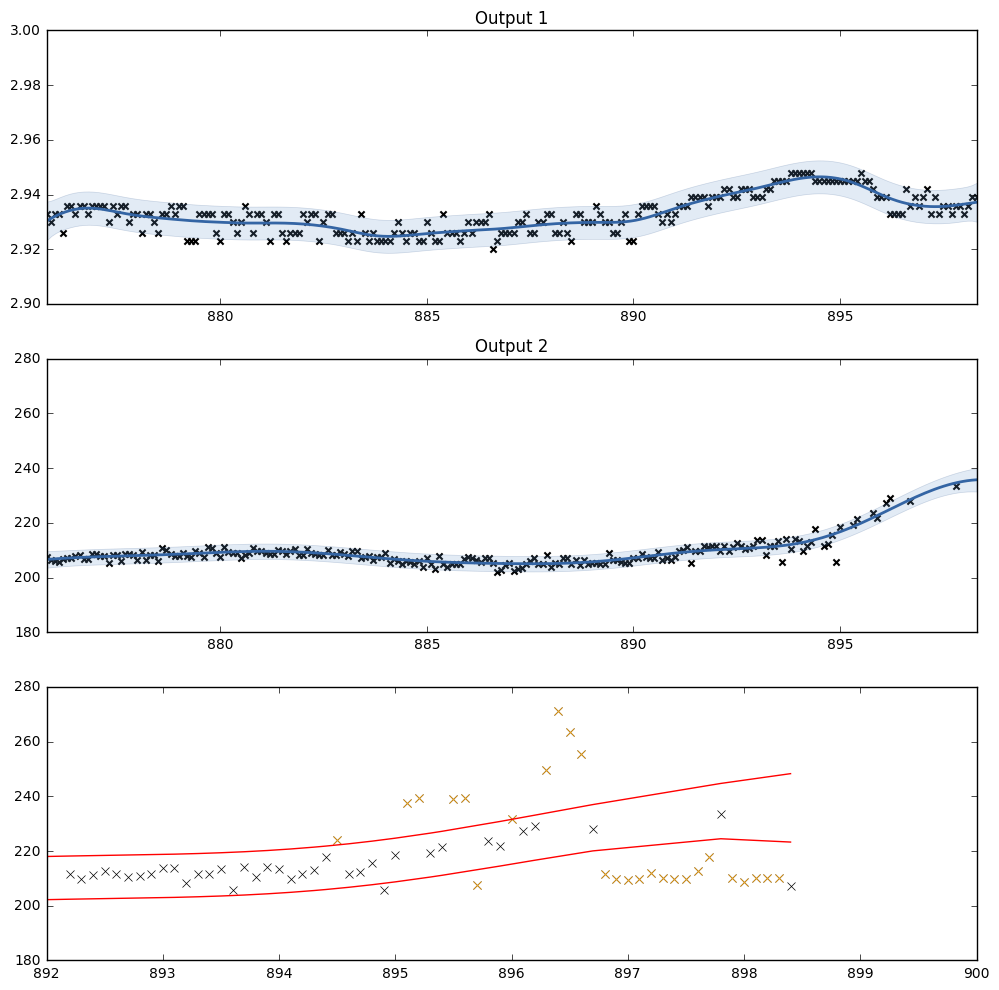

63


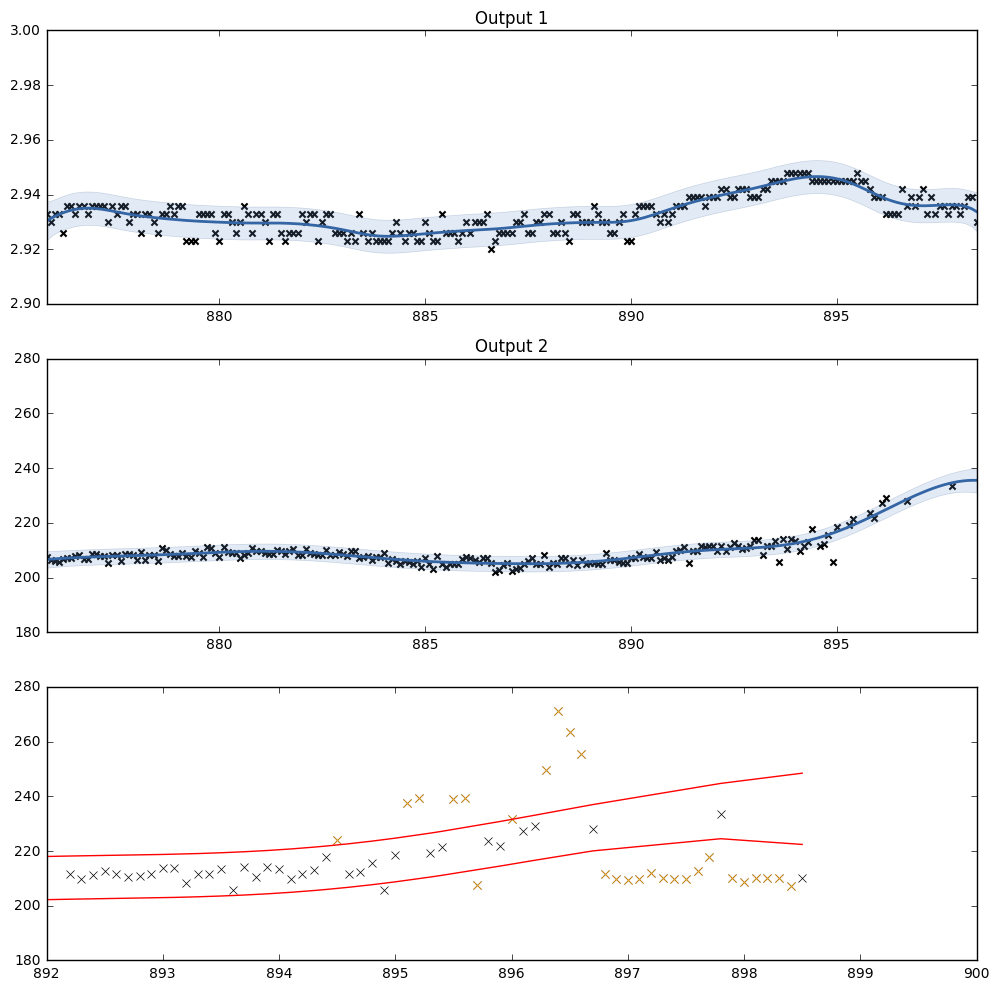

64


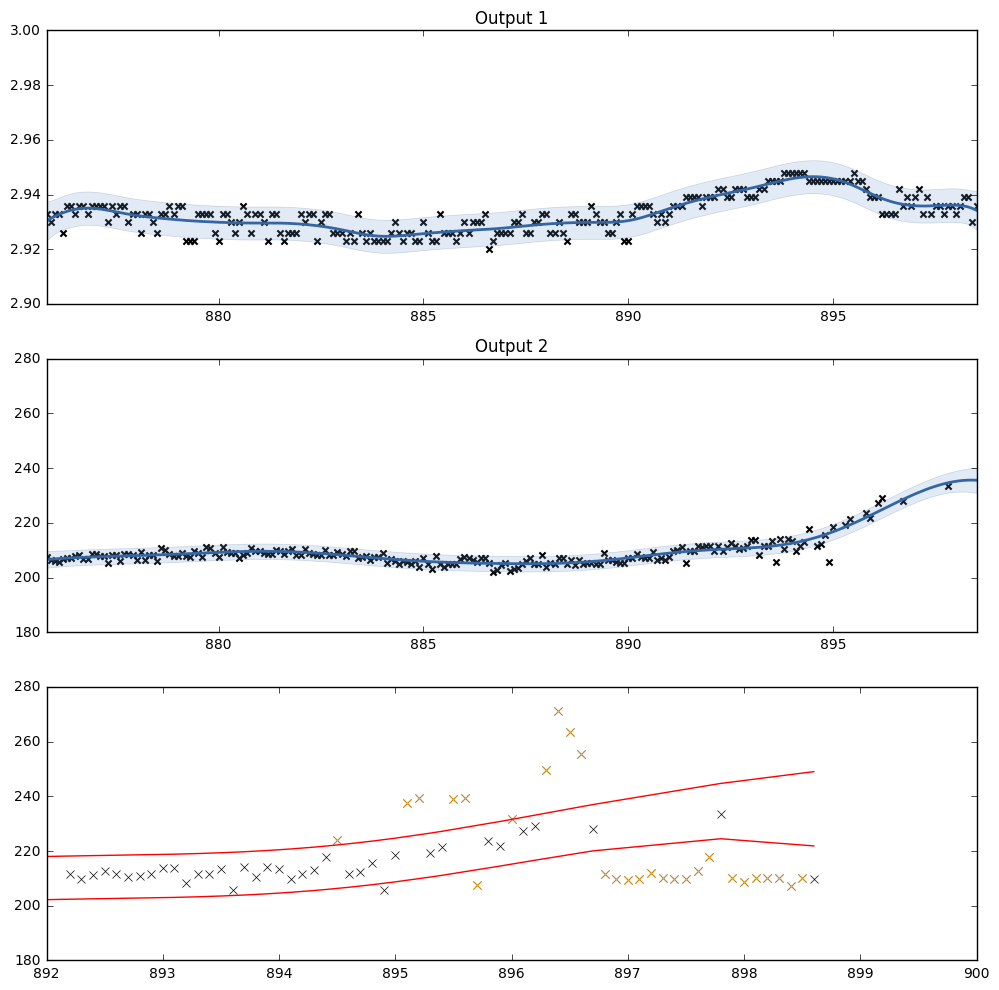

65


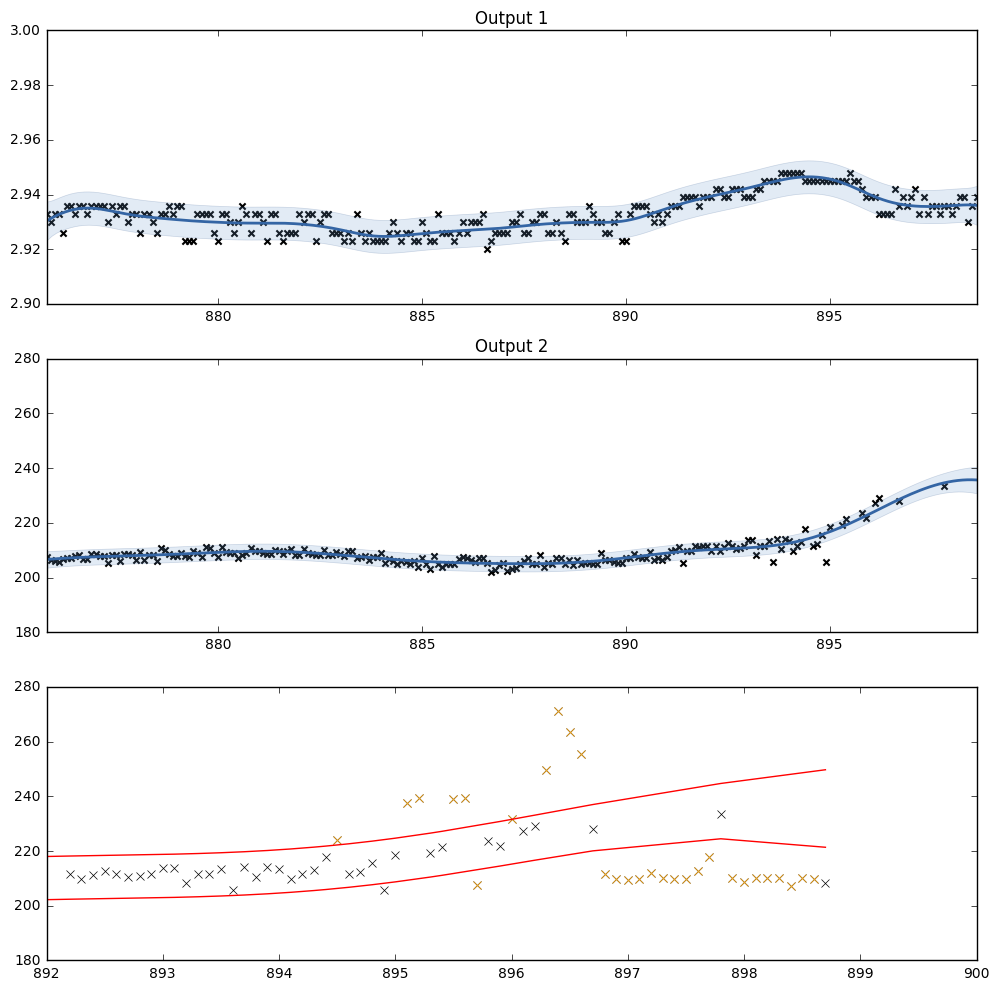

66


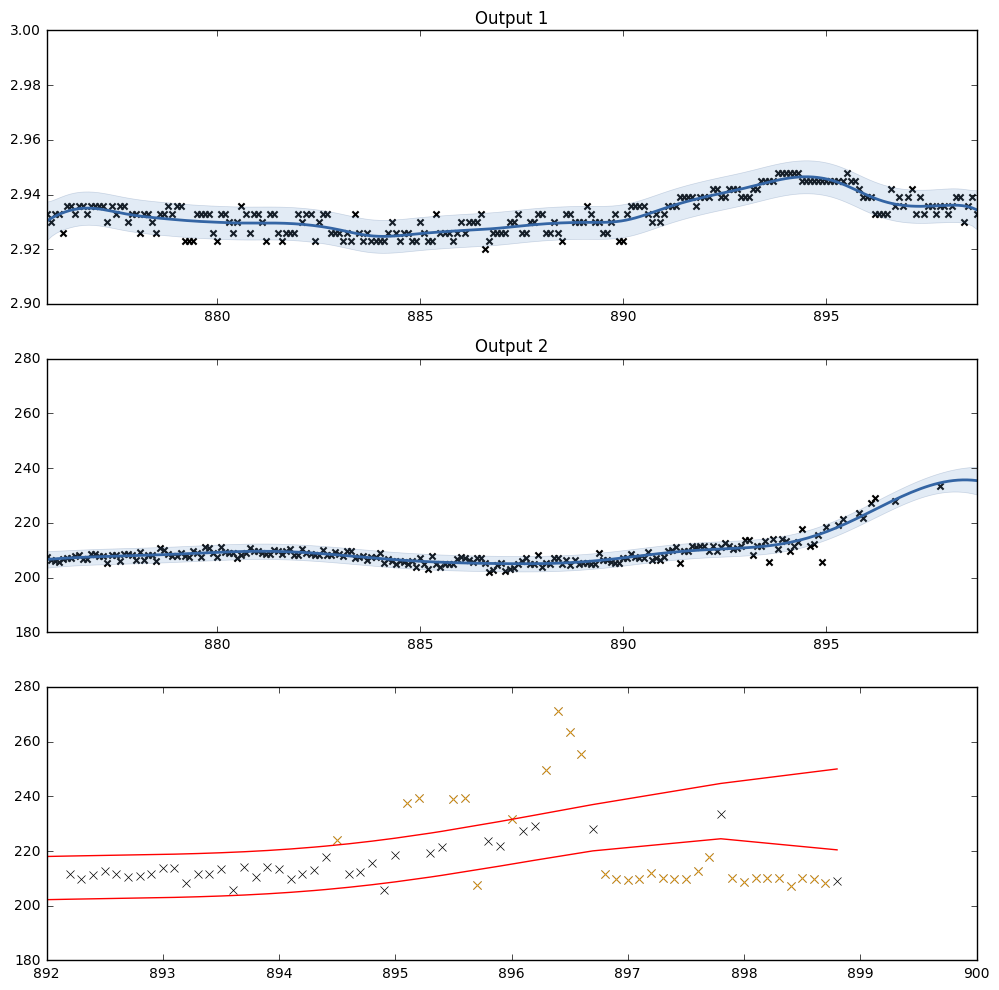

67


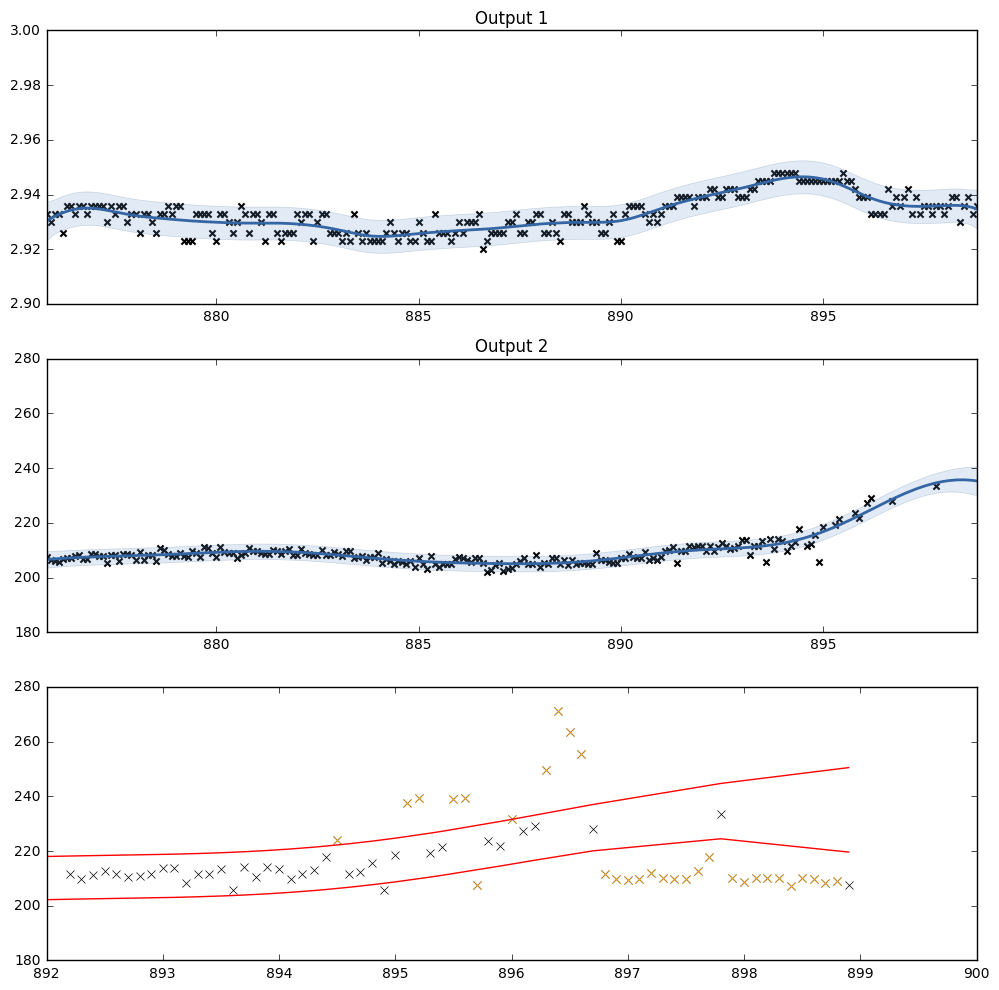

68


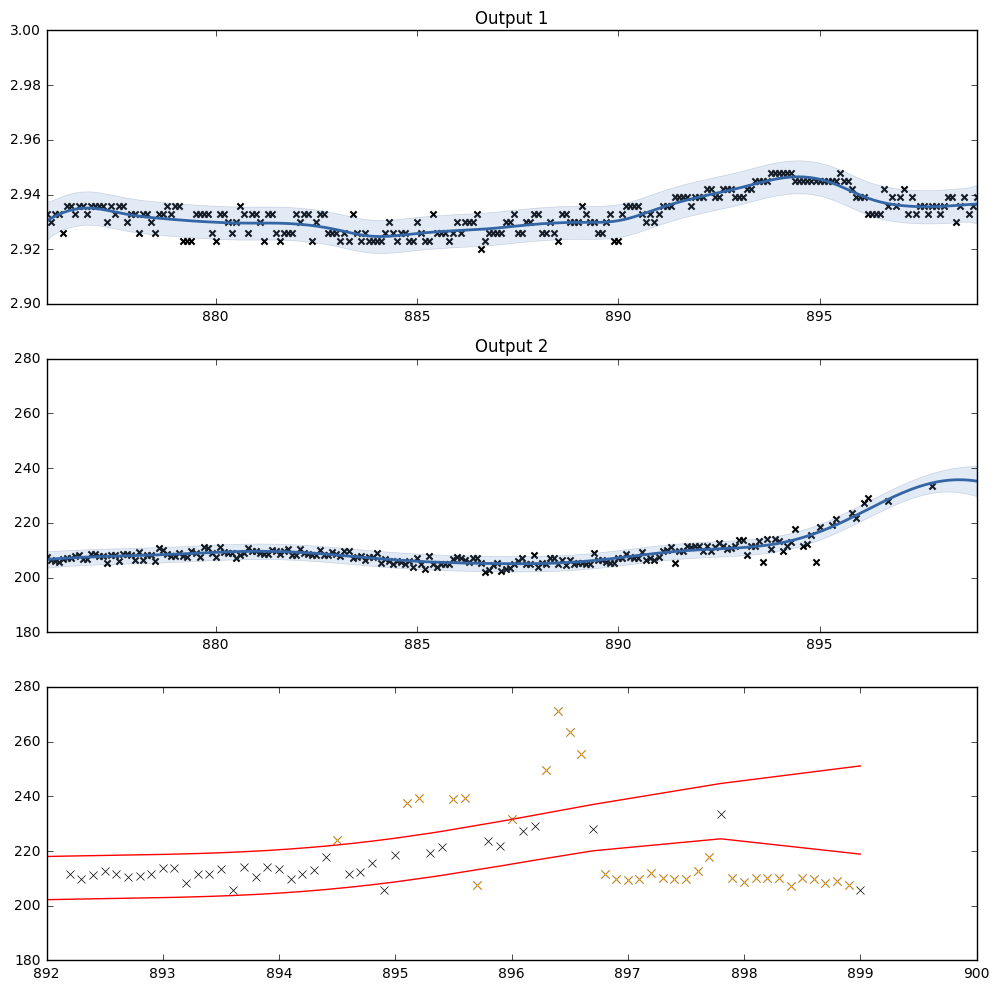

69


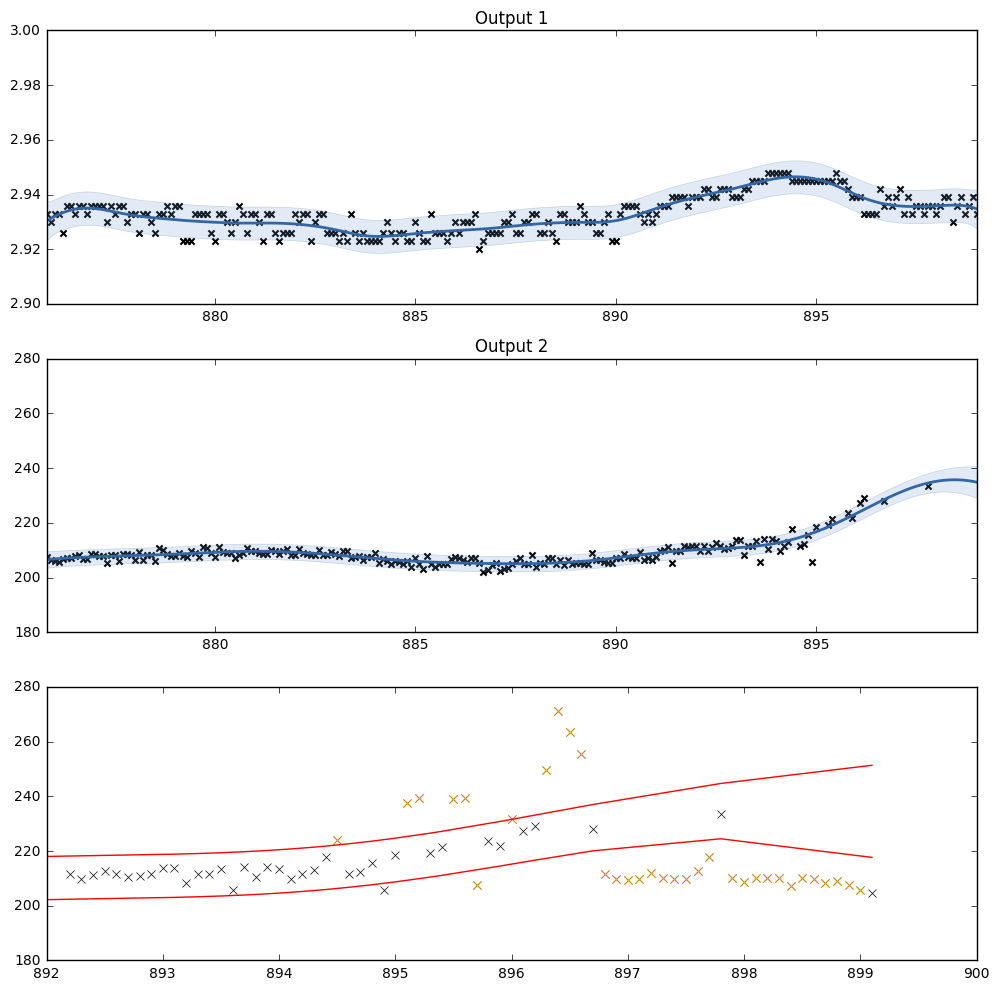

In [12]:
s = 8722
l = 200
it = list(range(s,s+l))
kt = it.copy()
anomal_points = []
test_points = []
chi_sq = []
step = 1
# kt - p1의 training set , 1개씩 이동시키는데 EVT에서 anomal로 나와도 점을 포함시킨다.
# it - p2의 training set , 1개씩 이동시키는데 EVT에서 anomal로 나오면 그대로 냅둔다.

for i in range(70):
    
    print(i)
    # new는 항상 1씩 증가한다
    new = it[len(it)-1]+step
    test_points.append(new)
    
#     print(np.array(kt)-8721)
#     print(np.array(it)-8721)
    mul = GPy.models.GPCoregionalizedRegression([x[kt],x[it]],[p1[kt],p2[it]],kernel = kern)
    mul['.*Gaussian_noise_0.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_0.variance)
    mul['.*Gaussian_noise_1.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_1.variance)
    test_x = x[new]
    n = rbf(x[it],test_x,mul)
    zp = z_score(n)

    # 벗어나는 x찾기
    jt = it + list([new])
    X,I = build_XI([x[jt],x[jt]])
    mu,var = mul.predict(X,Y_metadata=I,kern=mul.kern,likelihood=mul.likelihood)
    mu2 = mu[int(len(mu)/2):len(mu)]
    var2 = var[int(len(mu)/2):len(mu)]
    
    con_ue = mu2 + np.sqrt(var2)*zp
    con_le = mu2 - np.sqrt(var2)*zp

  

    plot_3outputs(mul, xlim=(x[kt[0]],x[kt[len(kt)-1]]),x_1=x[kt],x_2=x[it],con_ue=con_ue,con_le=con_le,n=new)
    plt.show()
    
    
    # 가장 뒤의 20개에 대해서 chi-square test
    
    mul2 = GPy.models.GPCoregionalizedRegression([x[kt],x[it[0:len(it)-20]]],[p1[kt],p2[it[0:len(it)-20]]],kernel = kern)
    mul2['.*Gaussian_noise_0.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_0.variance)
    mul2['.*Gaussian_noise_1.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_1.variance)
    
    ct = it[len(it)-20:len(it)]
    md2 = Mahalanobis_distance(mul2,x[ct],p2[ct])
    cs = chisqprob(md2,len(ct))[0][0]
    chi_sq.append(cs)
    
    
    # list update
    
    if p2[new] > mu2[l] + zp*np.sqrt(var2[l]) or p2[new] < mu2[l] - zp*np.sqrt(var2[l]):
        anomal_points.append(new)
        it = it
        kt = kt + list([new])
        step += 1
    else:
        it.pop(0)
        it = it + list([new])
        kt.pop(0)
        kt = kt + list([new])
        step = 1
    

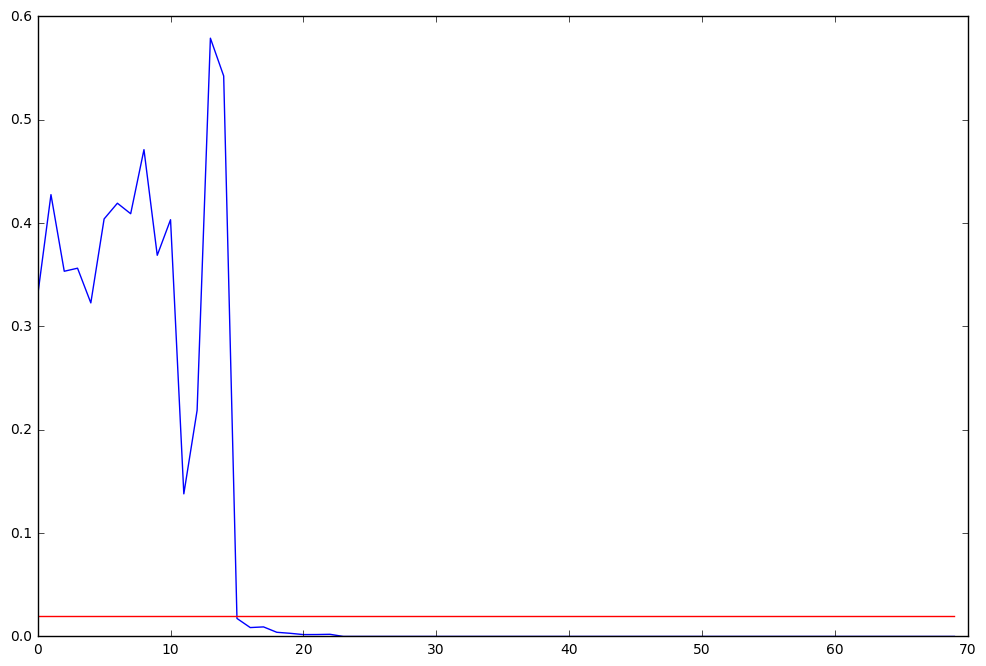

15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69


In [14]:
fig = plt.figure(figsize=(12,8))
plt.plot(chi_sq)
th = np.ones(len(chi_sq))*0.02
plt.plot(th,color='red')
plt.show()

for i in range(len(chi_sq)):
    if chi_sq[i] < 0.02:
        print(i)

In [38]:
chi_sq[0][0][0]

3.3867590184357162e-21

In [10]:
anomal_points

[9120, 9121, 9122, 9123, 9124, 9125, 9126, 9127]

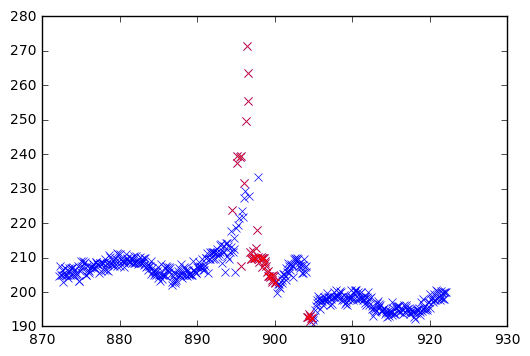

In [16]:
plt.plot(x[8722:9222],p2[8722:9222],'kx',color='blue')
plt.plot(x[anomal_points],p2[anomal_points],'kx',color='red')
plt.show()

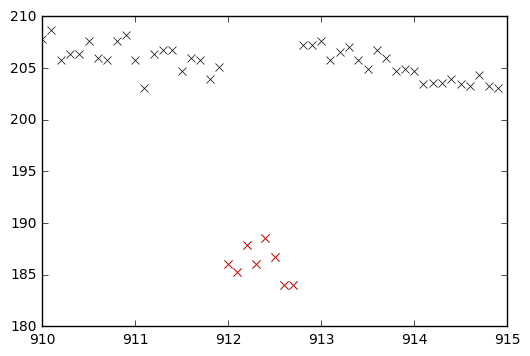

In [12]:
ano = anomal_points[0:11]
plt.plot(x[9100:9150],p2[9100:9150],'kx')
plt.plot(x[ano],p2[ano],'kx',color='red')
plt.show()

In [47]:
mul

In [22]:
np.array(kt)-8869

array([ 92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
       269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 28